# Calibration in wavelength of the  spectra of CTIO Data June 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- date   : 14 Jun 2017


In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
print theNotebook

CalibrateSpectrum


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [4]:
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [6]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [7]:
import sys
sys.path.append("../../common_tools/")
from scan_holo import *

In [8]:
!ls ../../common_tools/

READMEDS9.md                           pipeline_fullprod.py
compute.py                             pipeline_test.py
ctioweatherinfo_jun2017.csv            pressure.pdf
data                                   scan_holo.py
for_olivier_overscandtrim_28juin17     scan_holo.pyc
for_olivier_overscandtrim_28juin17.tgz skylev.py
fwhm_profiles.py                       targets.py
header.py                              telinst.py
holo_specs.py                          telinst.pyc
holo_specs.pyc                         temperature.pdf
humidity.pdf                           tools.py
overscan_subtract_andTrim.py           tools.pyc
overscan_subtract_andTrim.pyc          weatherinfo_fullprod.py
pictures


In [9]:
%load_ext Cython

In [10]:
from IPython.display import Image, display

In [11]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [12]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [13]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [17]:
inputdir="./spectrum_fitsspec"
MIN_IMGNUMBER=74
MAX_IMGNUMBER=108
object_name='HD111980 May 31th 2017'
SelectTagRe='^finalSpectra_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^finalSpectra_20170531_[0-9]+.fits$'
NBIMGPERROW=2

### Output fits file

In [18]:
outputdir="./spectrum_calibspec"

In [19]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [20]:
input_filelist=os.listdir(inputdir) 

In [21]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [22]:
print input_filelist[0:5]

['finalSpectra_20170531_074.fits' 'finalSpectra_20170531_075.fits'
 'finalSpectra_20170531_076.fits' 'finalSpectra_20170531_077.fits'
 'finalSpectra_20170531_078.fits']


In [23]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [24]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [25]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [26]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [27]:
print indexes_files

[ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108]


In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]


In [31]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [32]:
sorted_files[0:5]

array(['./spectrum_fitsspec/finalSpectra_20170531_074.fits',
       './spectrum_fitsspec/finalSpectra_20170531_075.fits',
       './spectrum_fitsspec/finalSpectra_20170531_076.fits',
       './spectrum_fitsspec/finalSpectra_20170531_077.fits',
       './spectrum_fitsspec/finalSpectra_20170531_078.fits'], 
      dtype='|S50')

## Build full filename
----------------------------

In [33]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [34]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [35]:
print sorted_filenames.shape

(35,)


## Acces to spectrum data
----------------------------------

In [36]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_totleftspectra = []
    all_totrightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        filters = header['FILTERS'].split(' ')[1]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        tot_left_spectrum=table_data.field('TotLeftSpec')
        tot_right_spectrum=table_data.field('TotRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_totleftspectra.append(tot_left_spectrum)
        all_totrightspectra.append(tot_right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_totleftspectra,all_totrightspectra,all_filt

In [37]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_totleftspectra,all_totrightspectra,all_filt=BuildRawSpec(sorted_files,sorted_numbers,object_name)

In [38]:
print all_filt

['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']


## Show Spectra
-----------------------

In [39]:
len(all_rightspectra)

35

In [63]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
import math as m



from matplotlib.backends.backend_pdf import PdfPages

def ShowSpectra(all_spectra,all_totspectra,all_titles,object_name,dir_top_img,all_filt,figname):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    
    NBIMGPERROW=2
    NBSPEC=len(all_spectra)
    
    MAXIMGROW=max(2,int(m.ceil(float(NBSPEC)/float(NBIMGPERROW))))
    
    
    # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_img,figname)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    title='Raw 1D Spectra 1D for {}'.format(object_name)
    
    
      
    for index in np.arange(0,NBSPEC):
        
        
        # new pdf page    
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20)
            
        # index of image in the pdf page    
        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
    
  
        spectrum=all_spectra[index]
        totspectrum=all_totspectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].plot(totspectrum,'k:',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
       
        axarr[iy,ix].grid(True)
      
        max_y_to_plot=spectrum[:].max()*1.2
        
        axarr[iy,ix].set_ylim(0.,max_y_to_plot)
        axarr[iy,ix].text(0.,max_y_to_plot*1.1/1.2, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
    
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()    
    

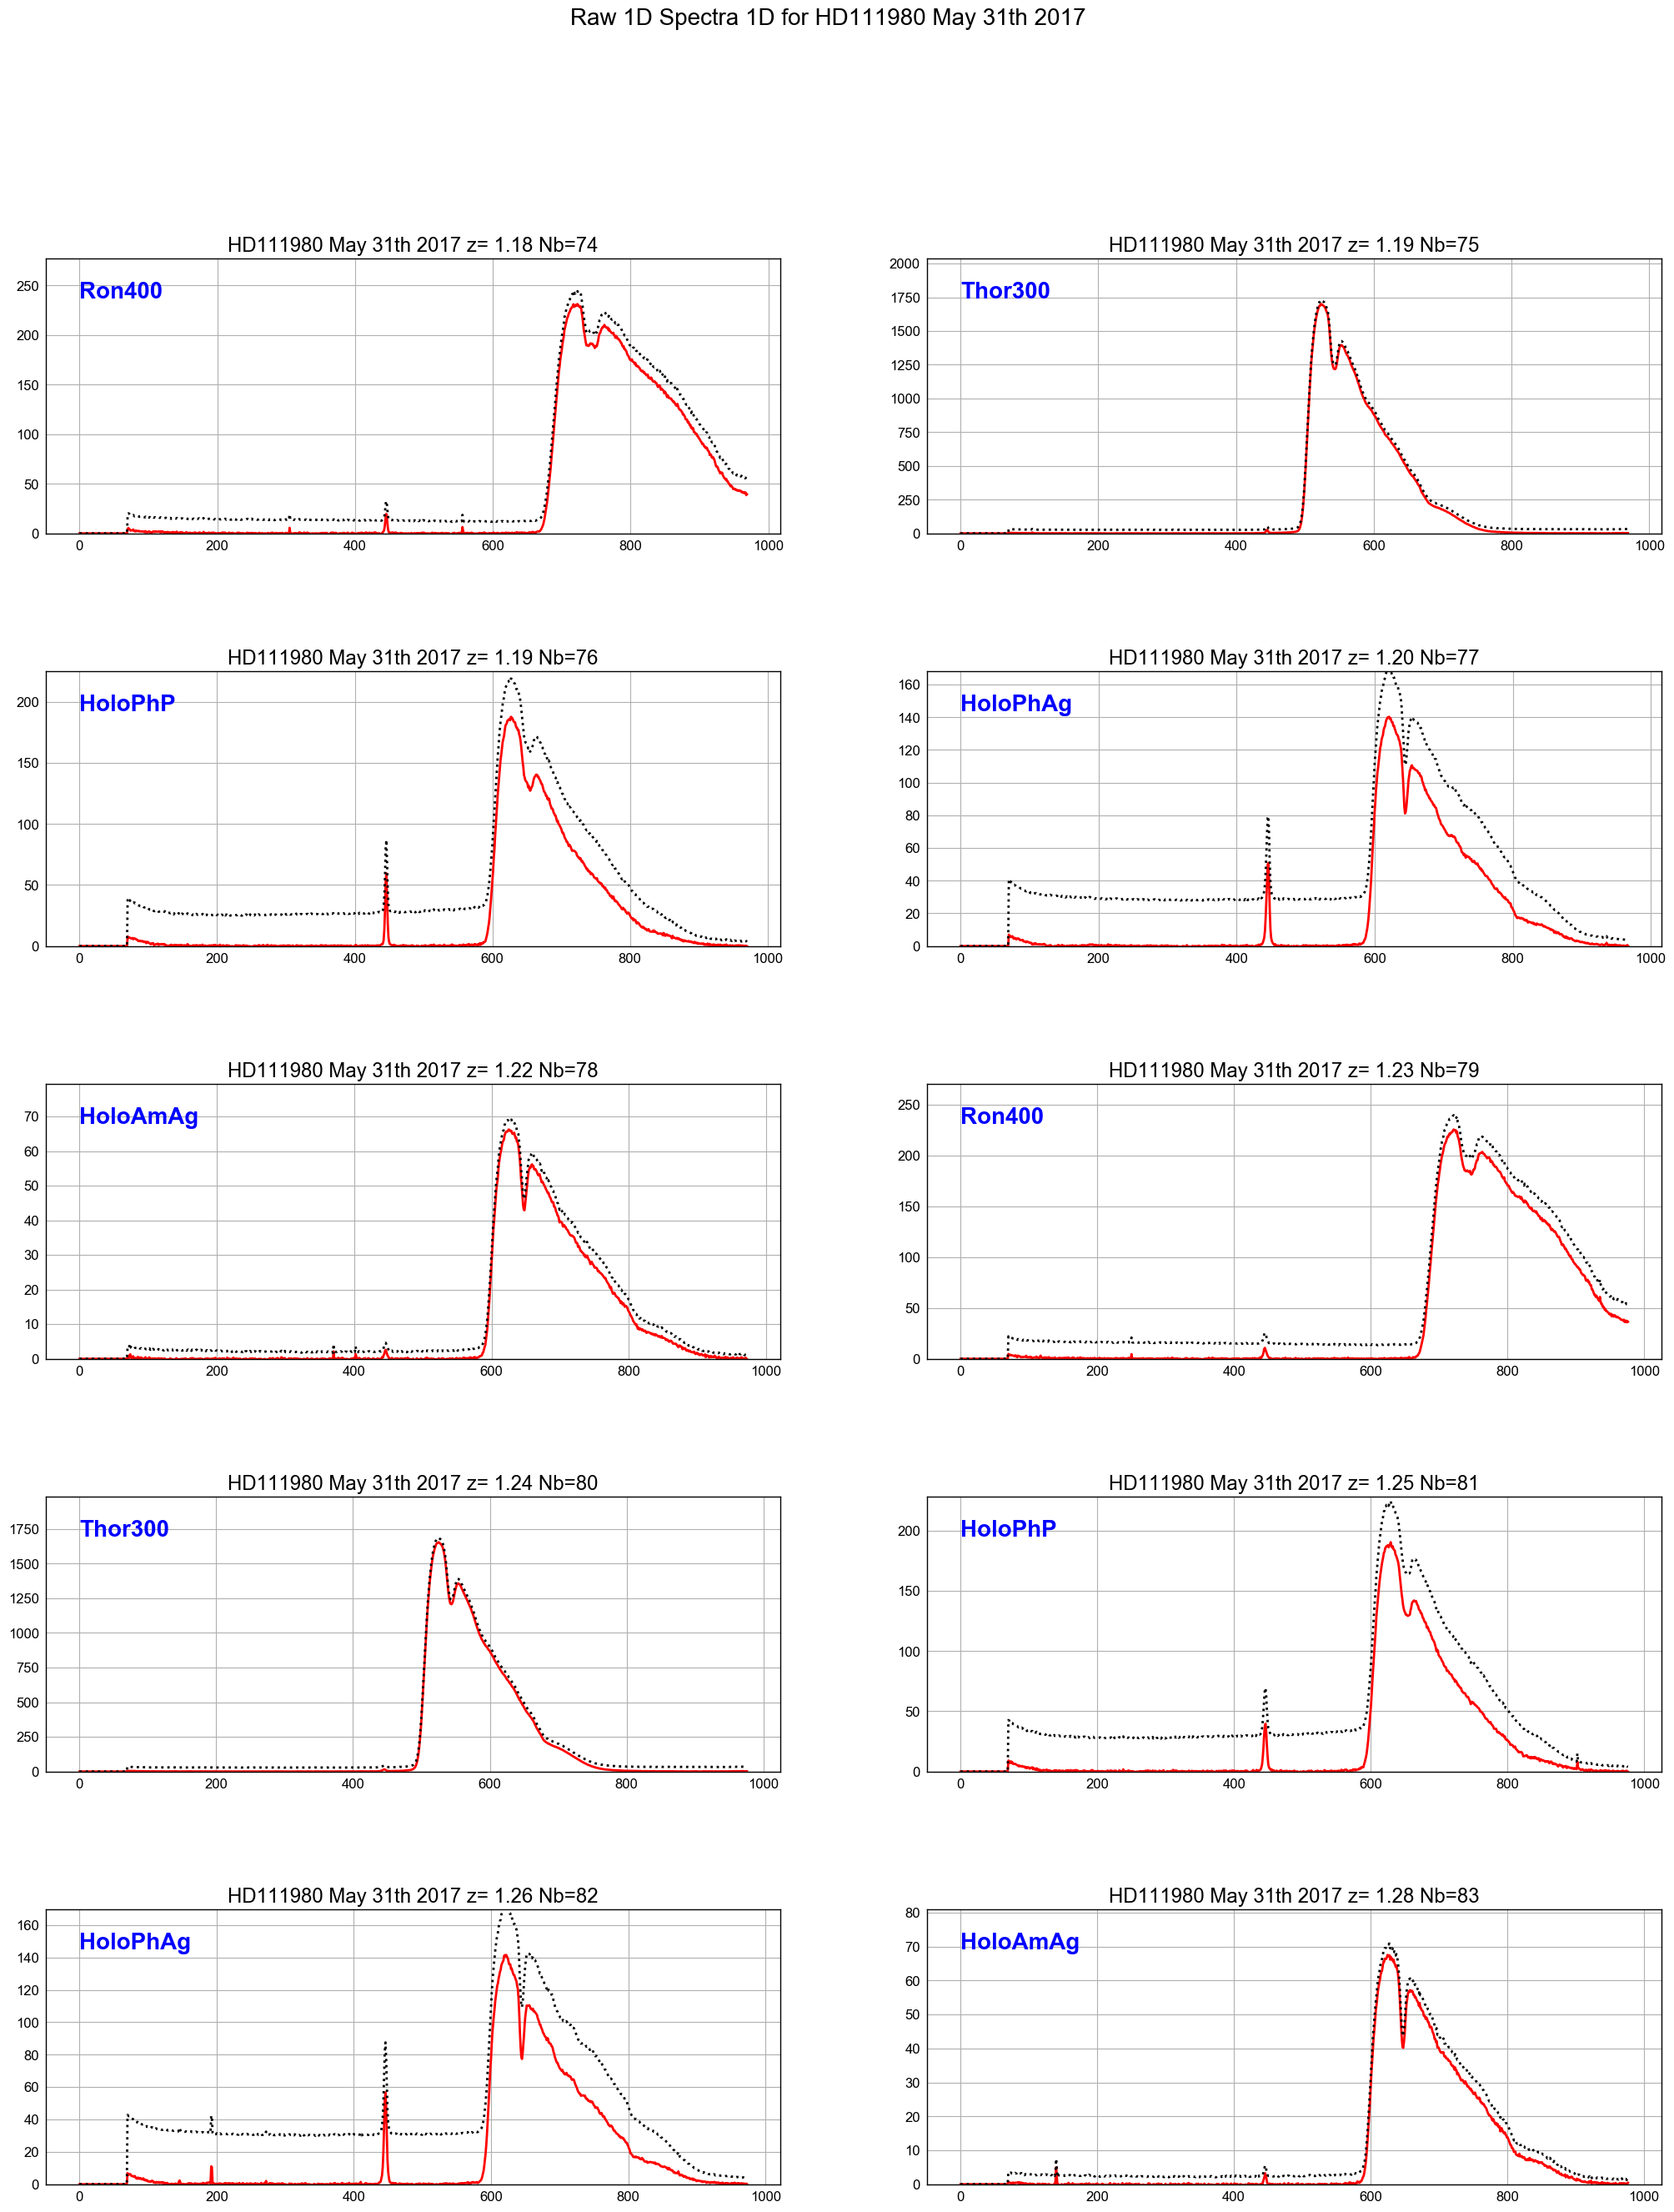

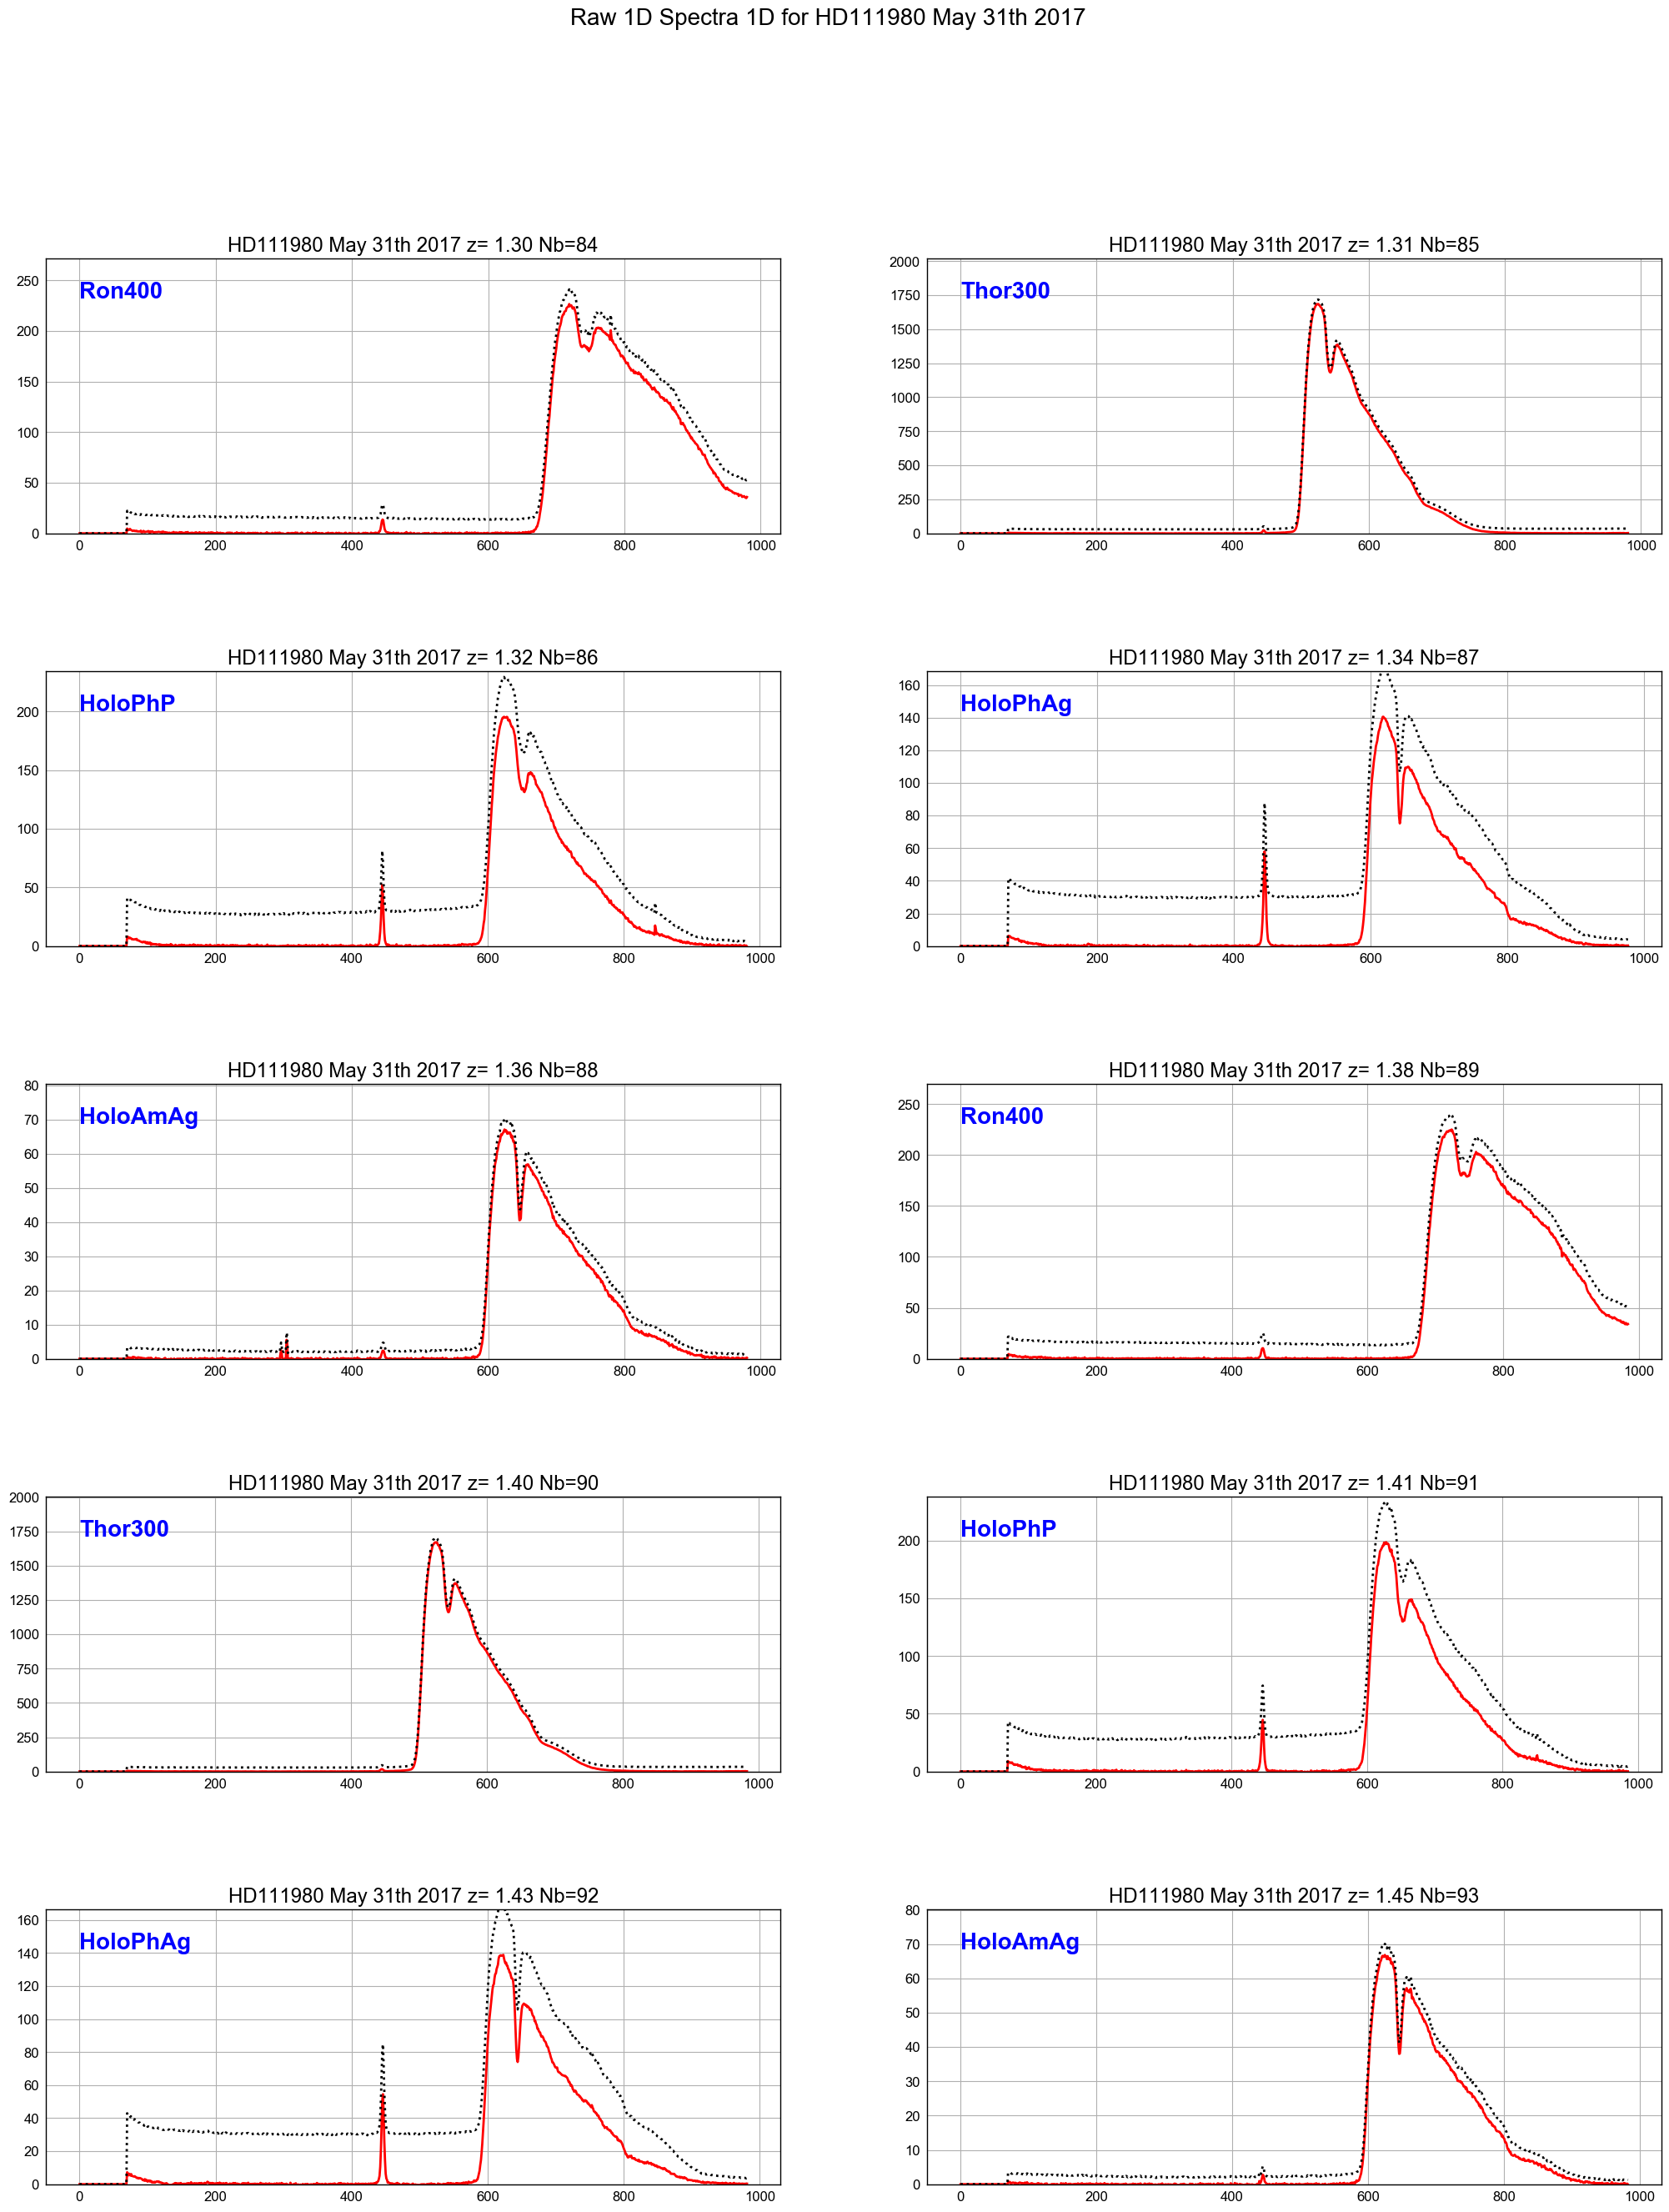

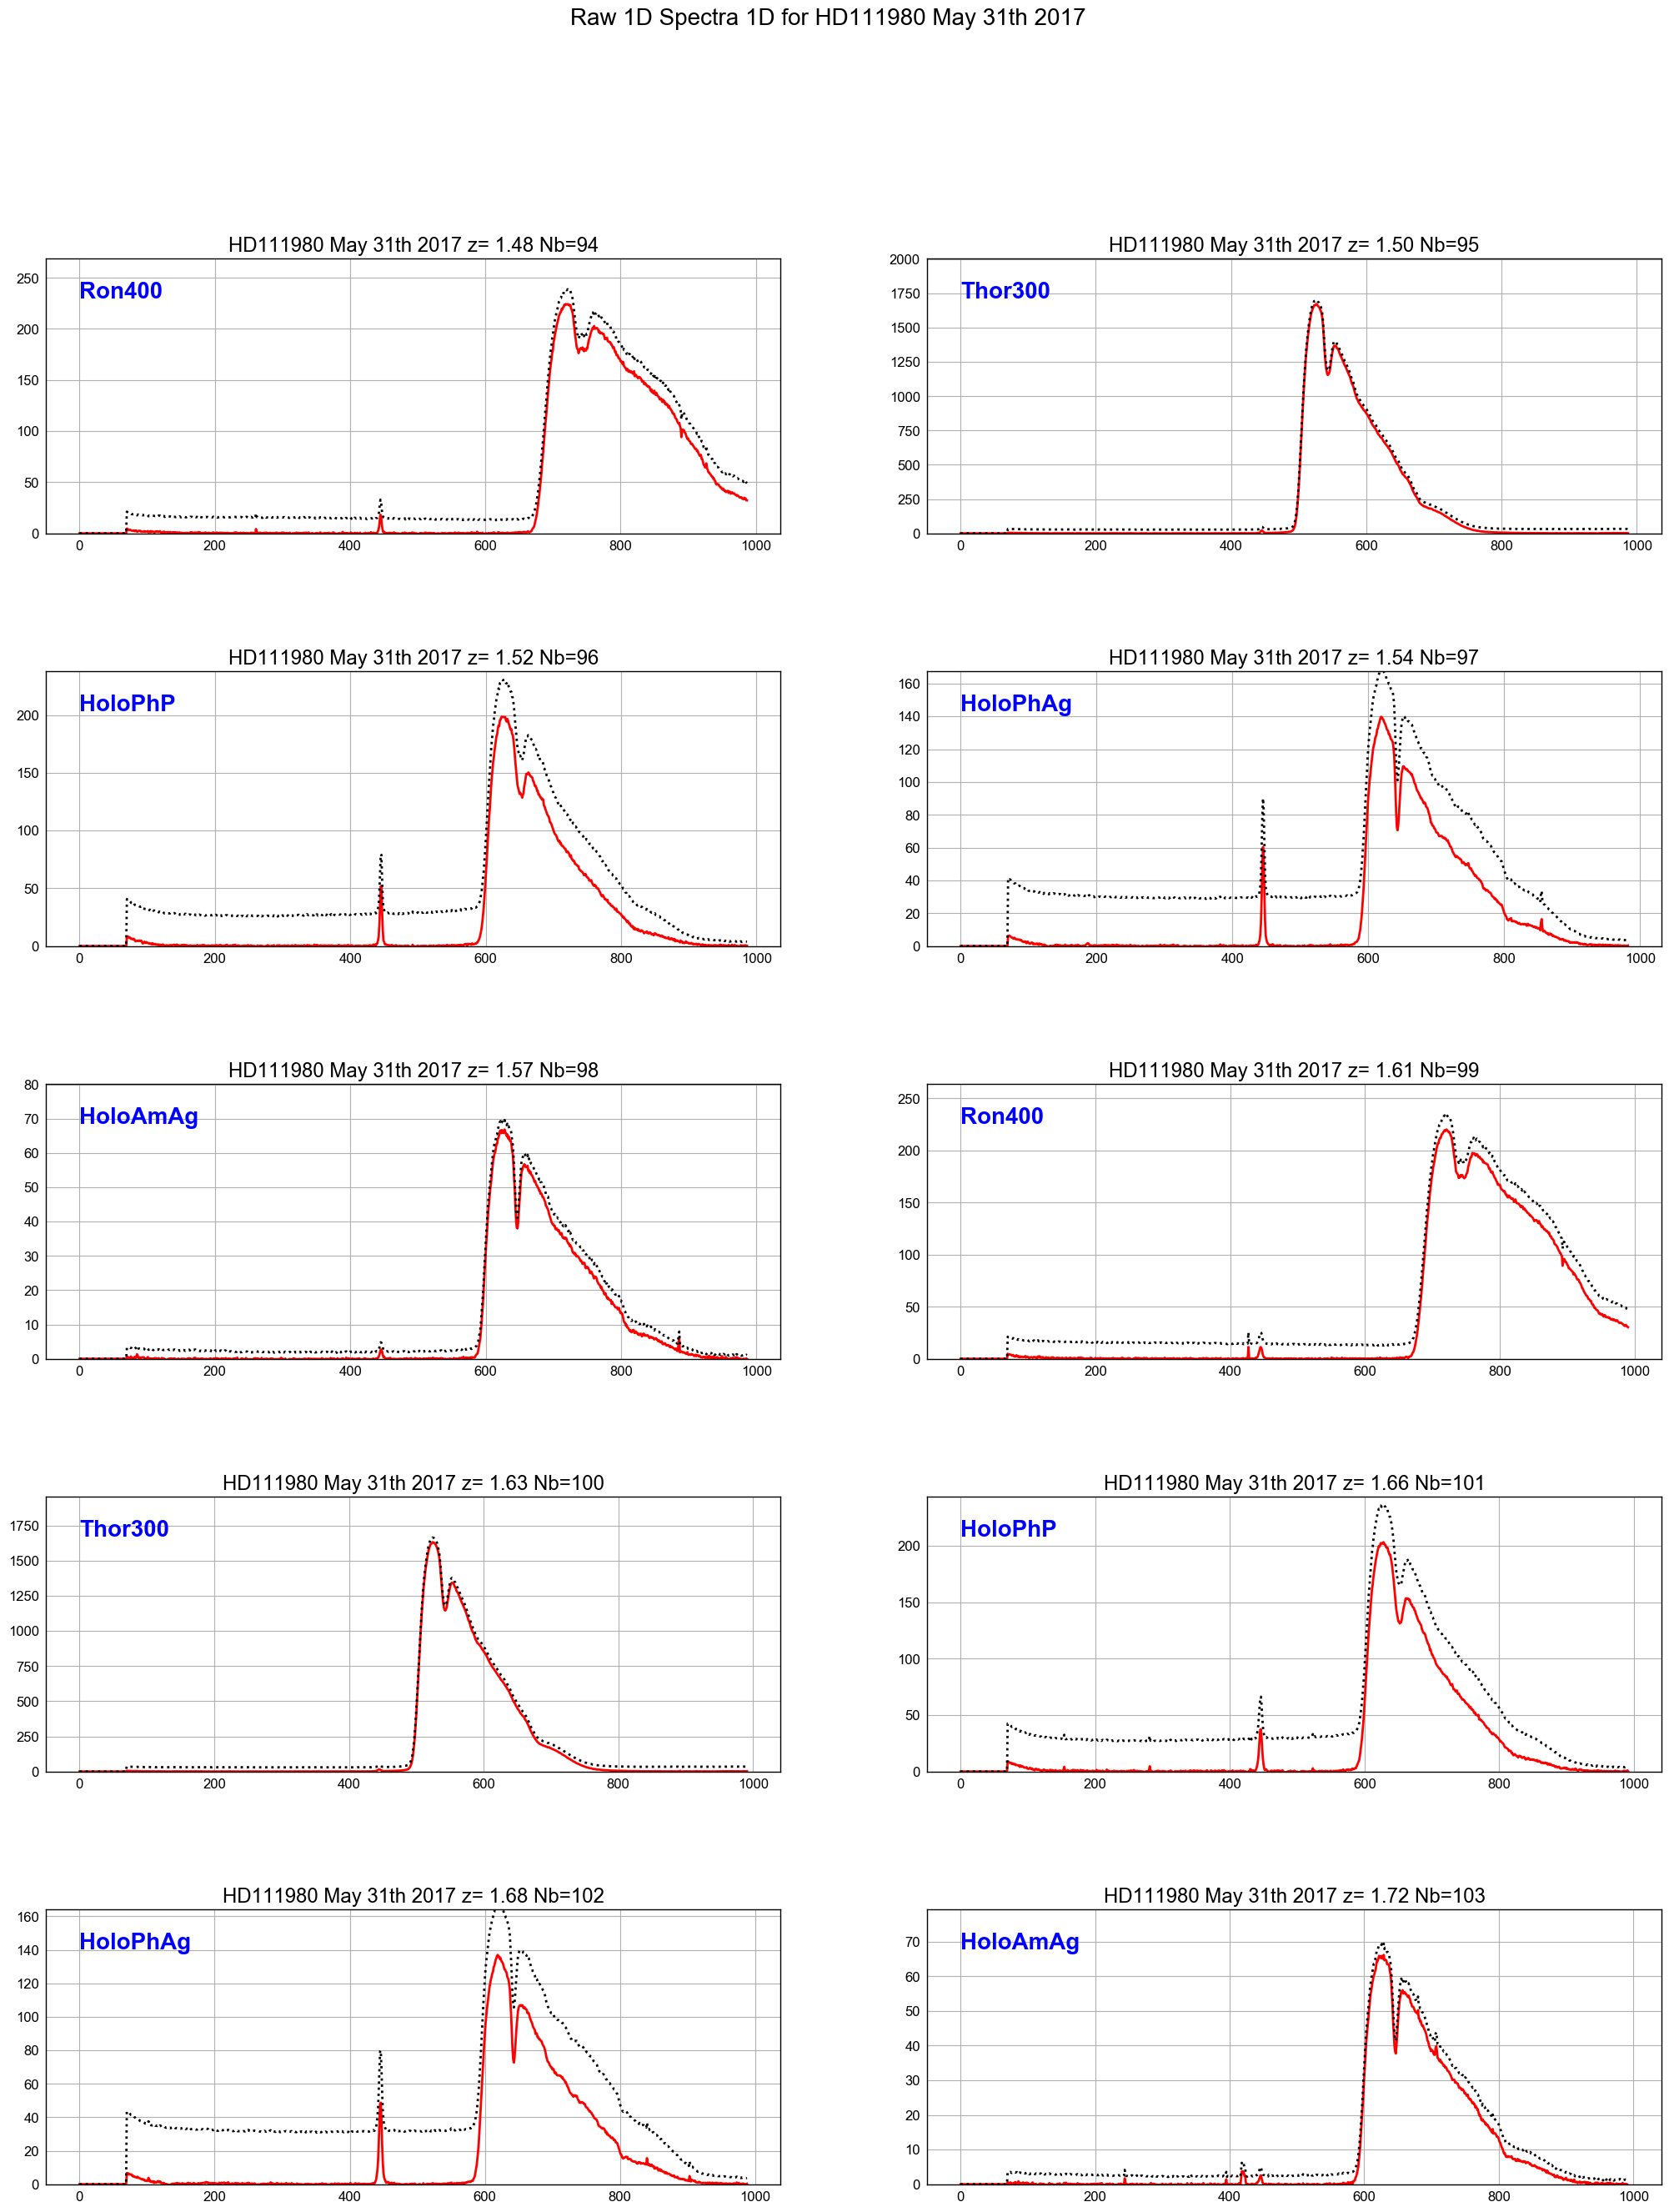

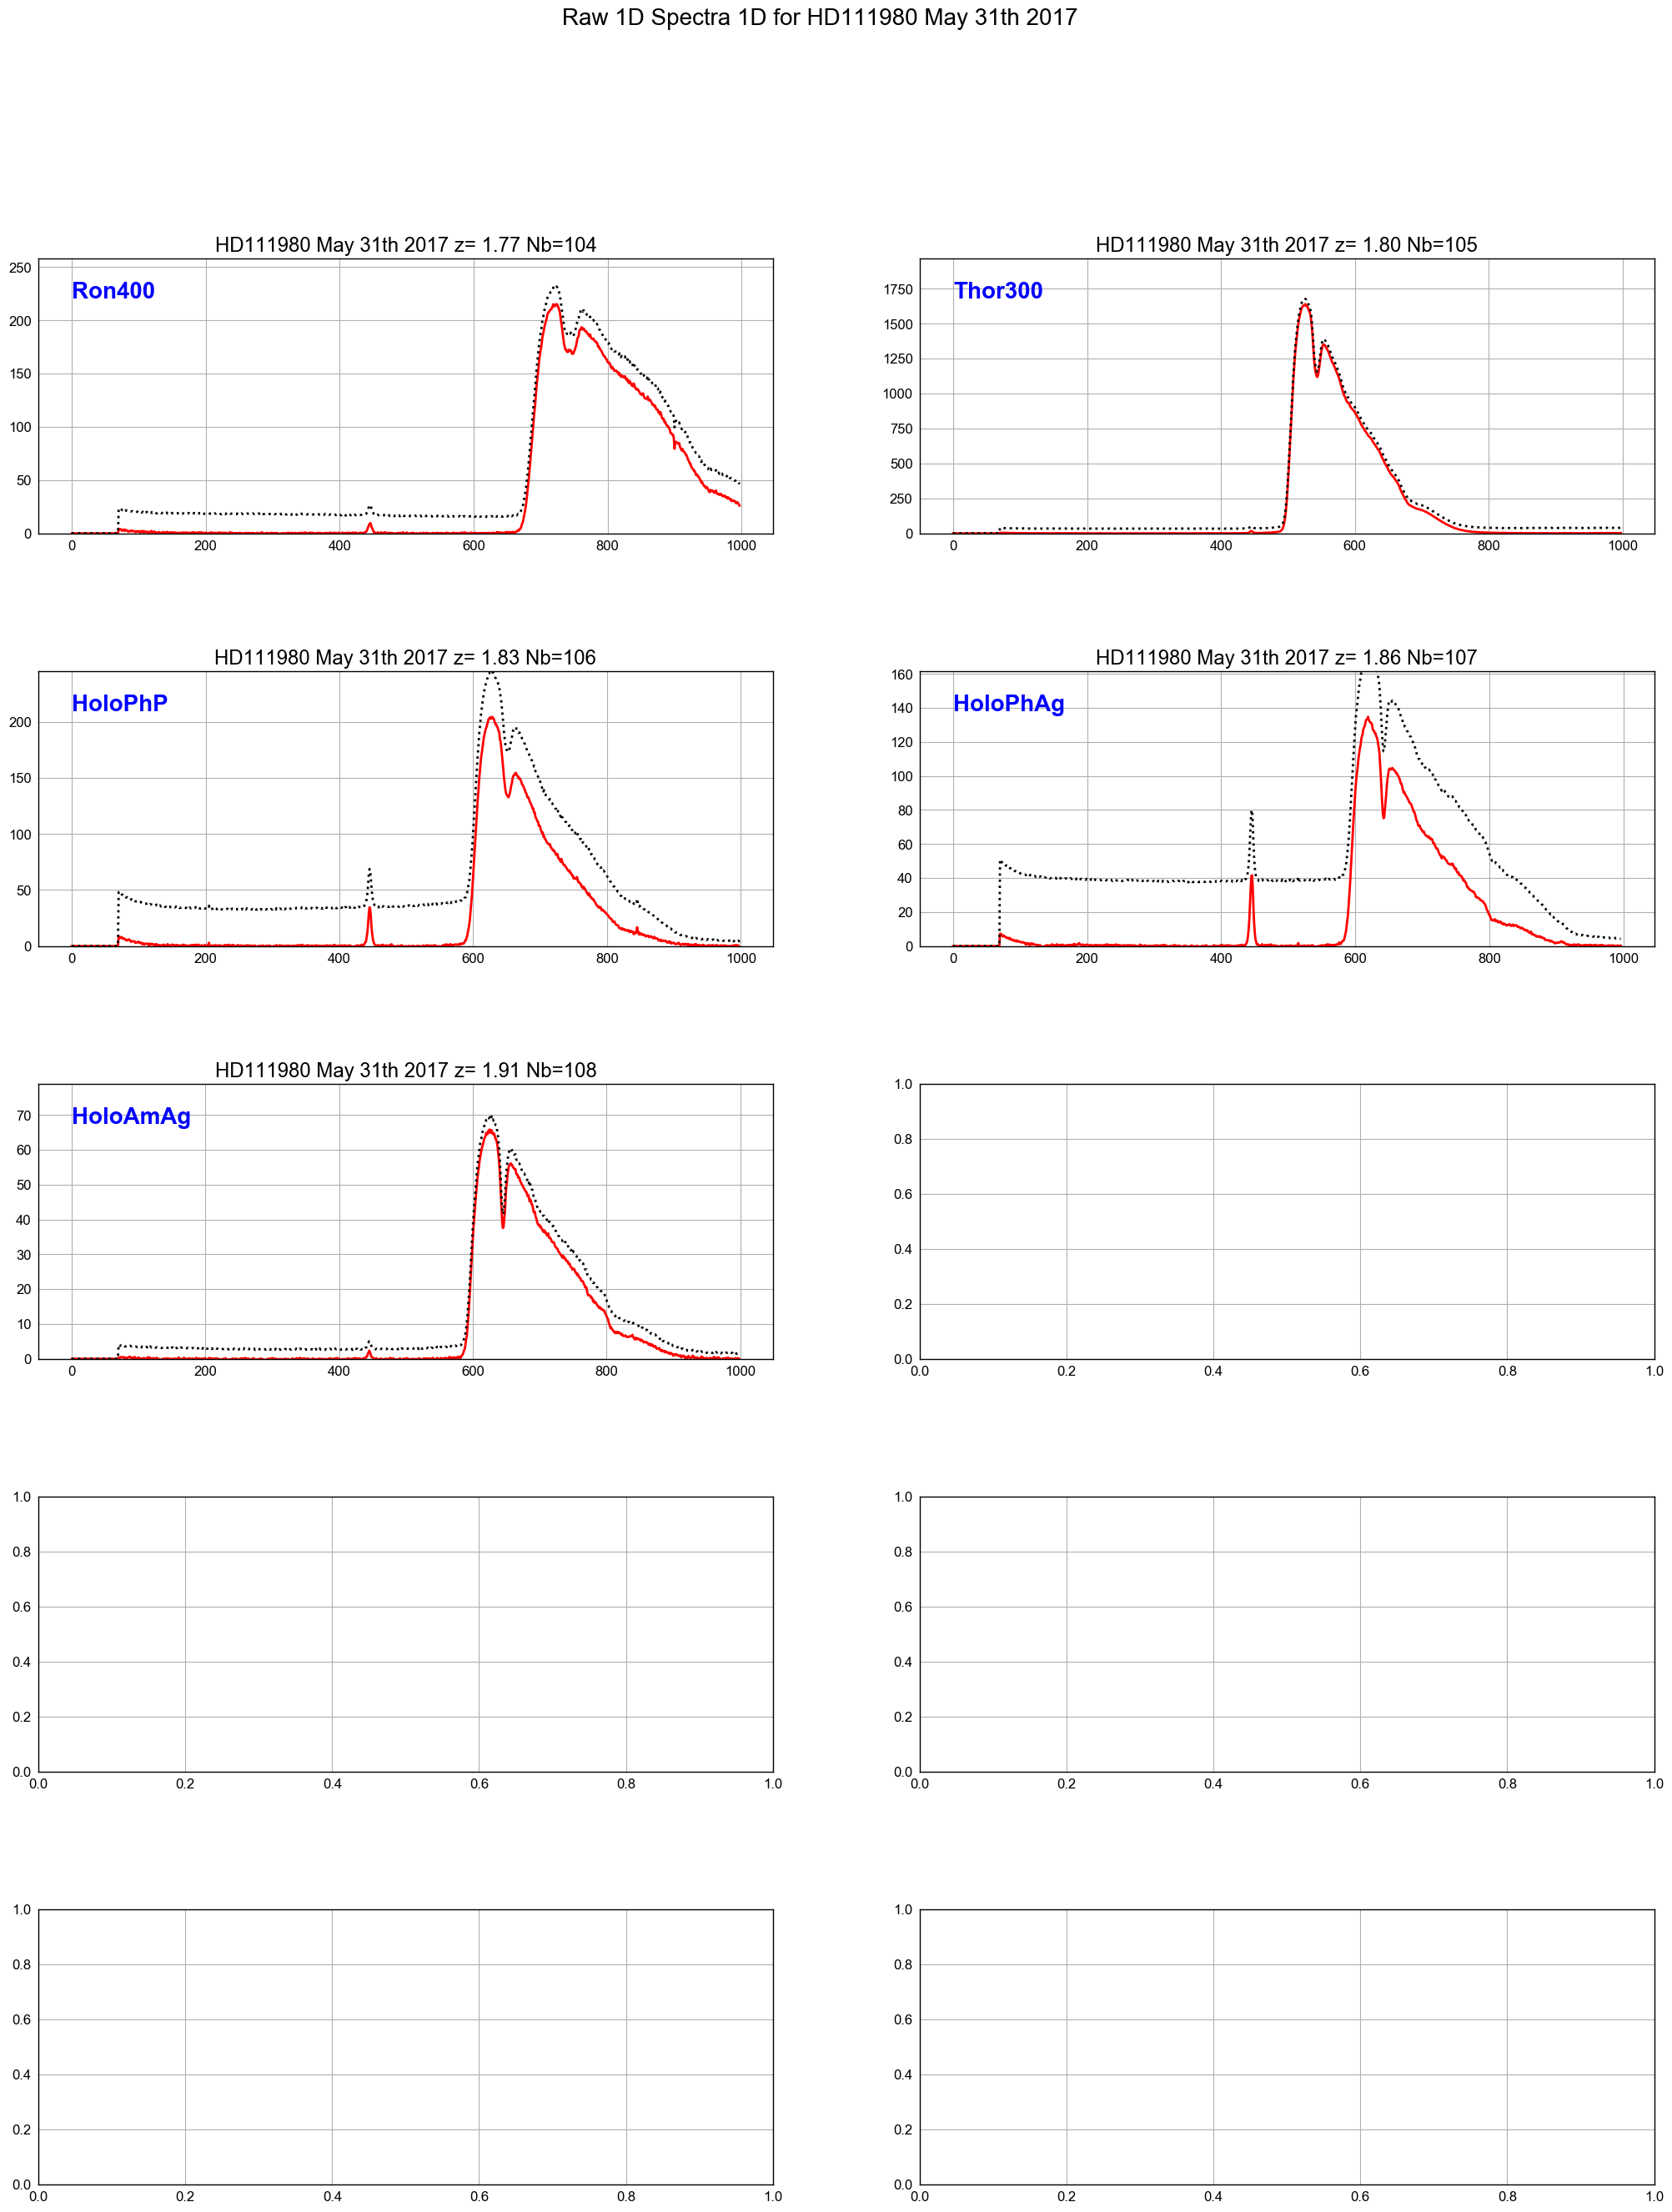

In [64]:
ShowSpectra(all_rightspectra,all_totrightspectra,all_titles,object_name,dir_top_images,all_filt,'raw1Dspectra_right.pdf')

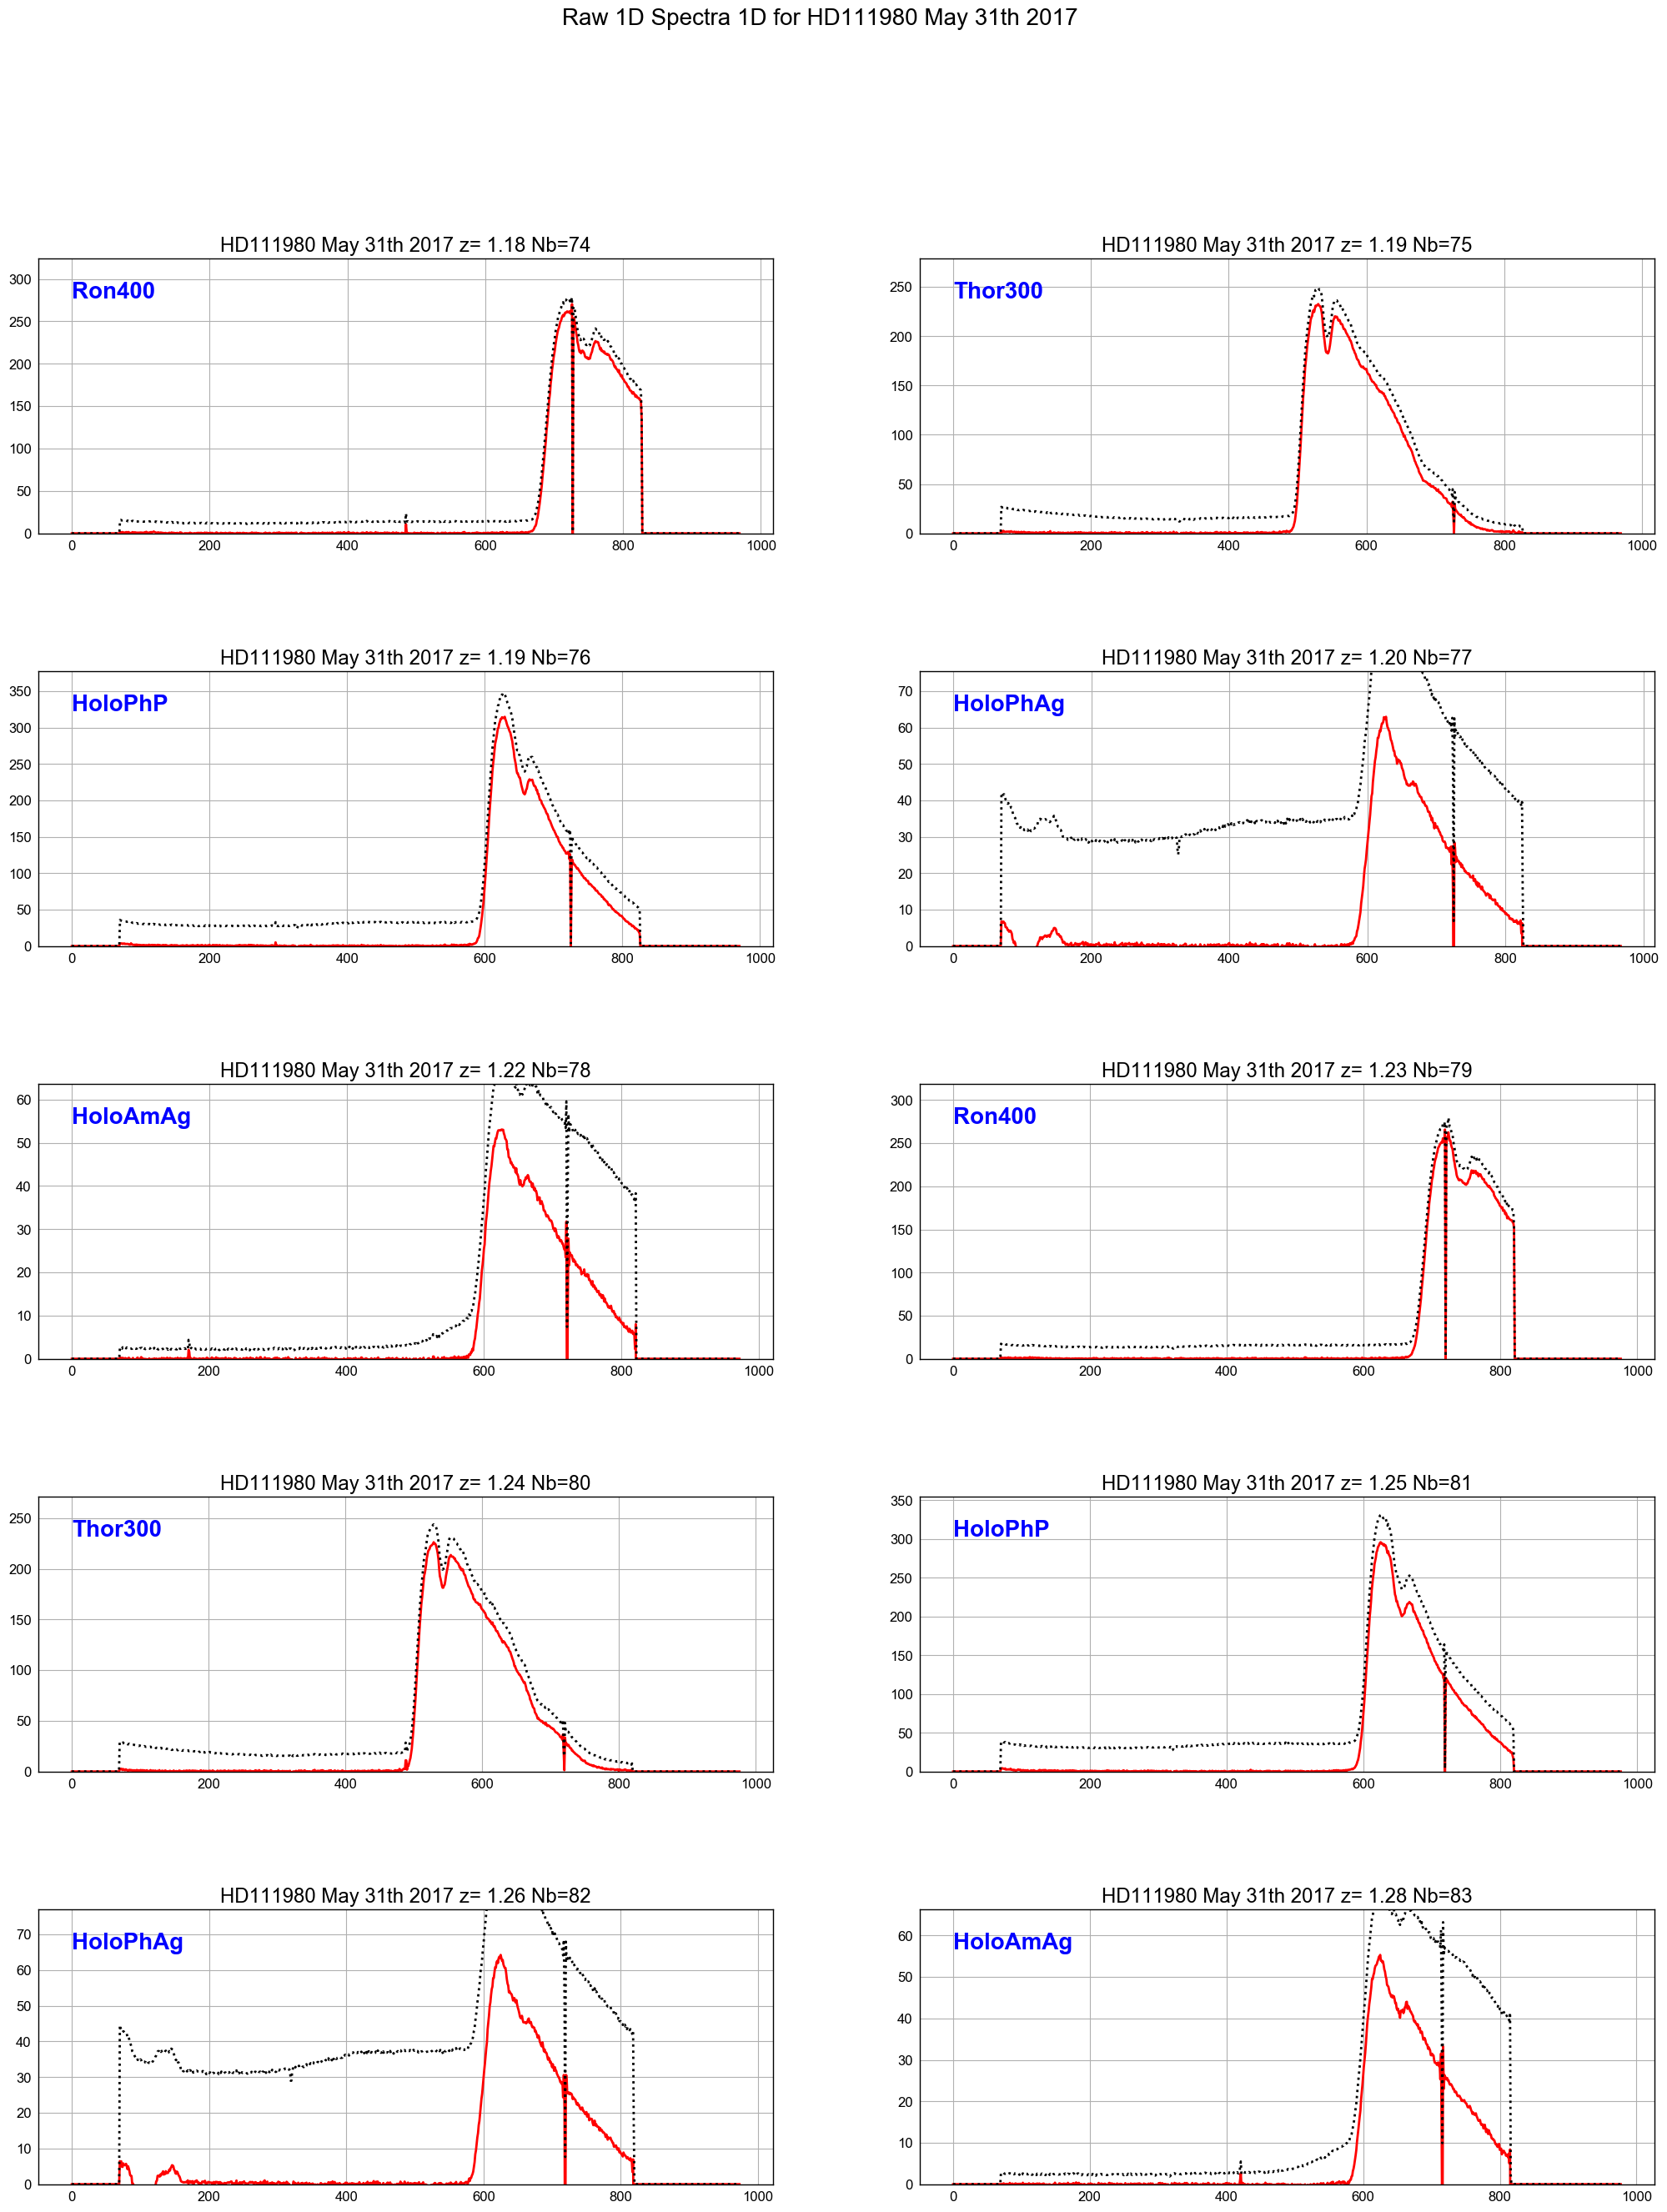

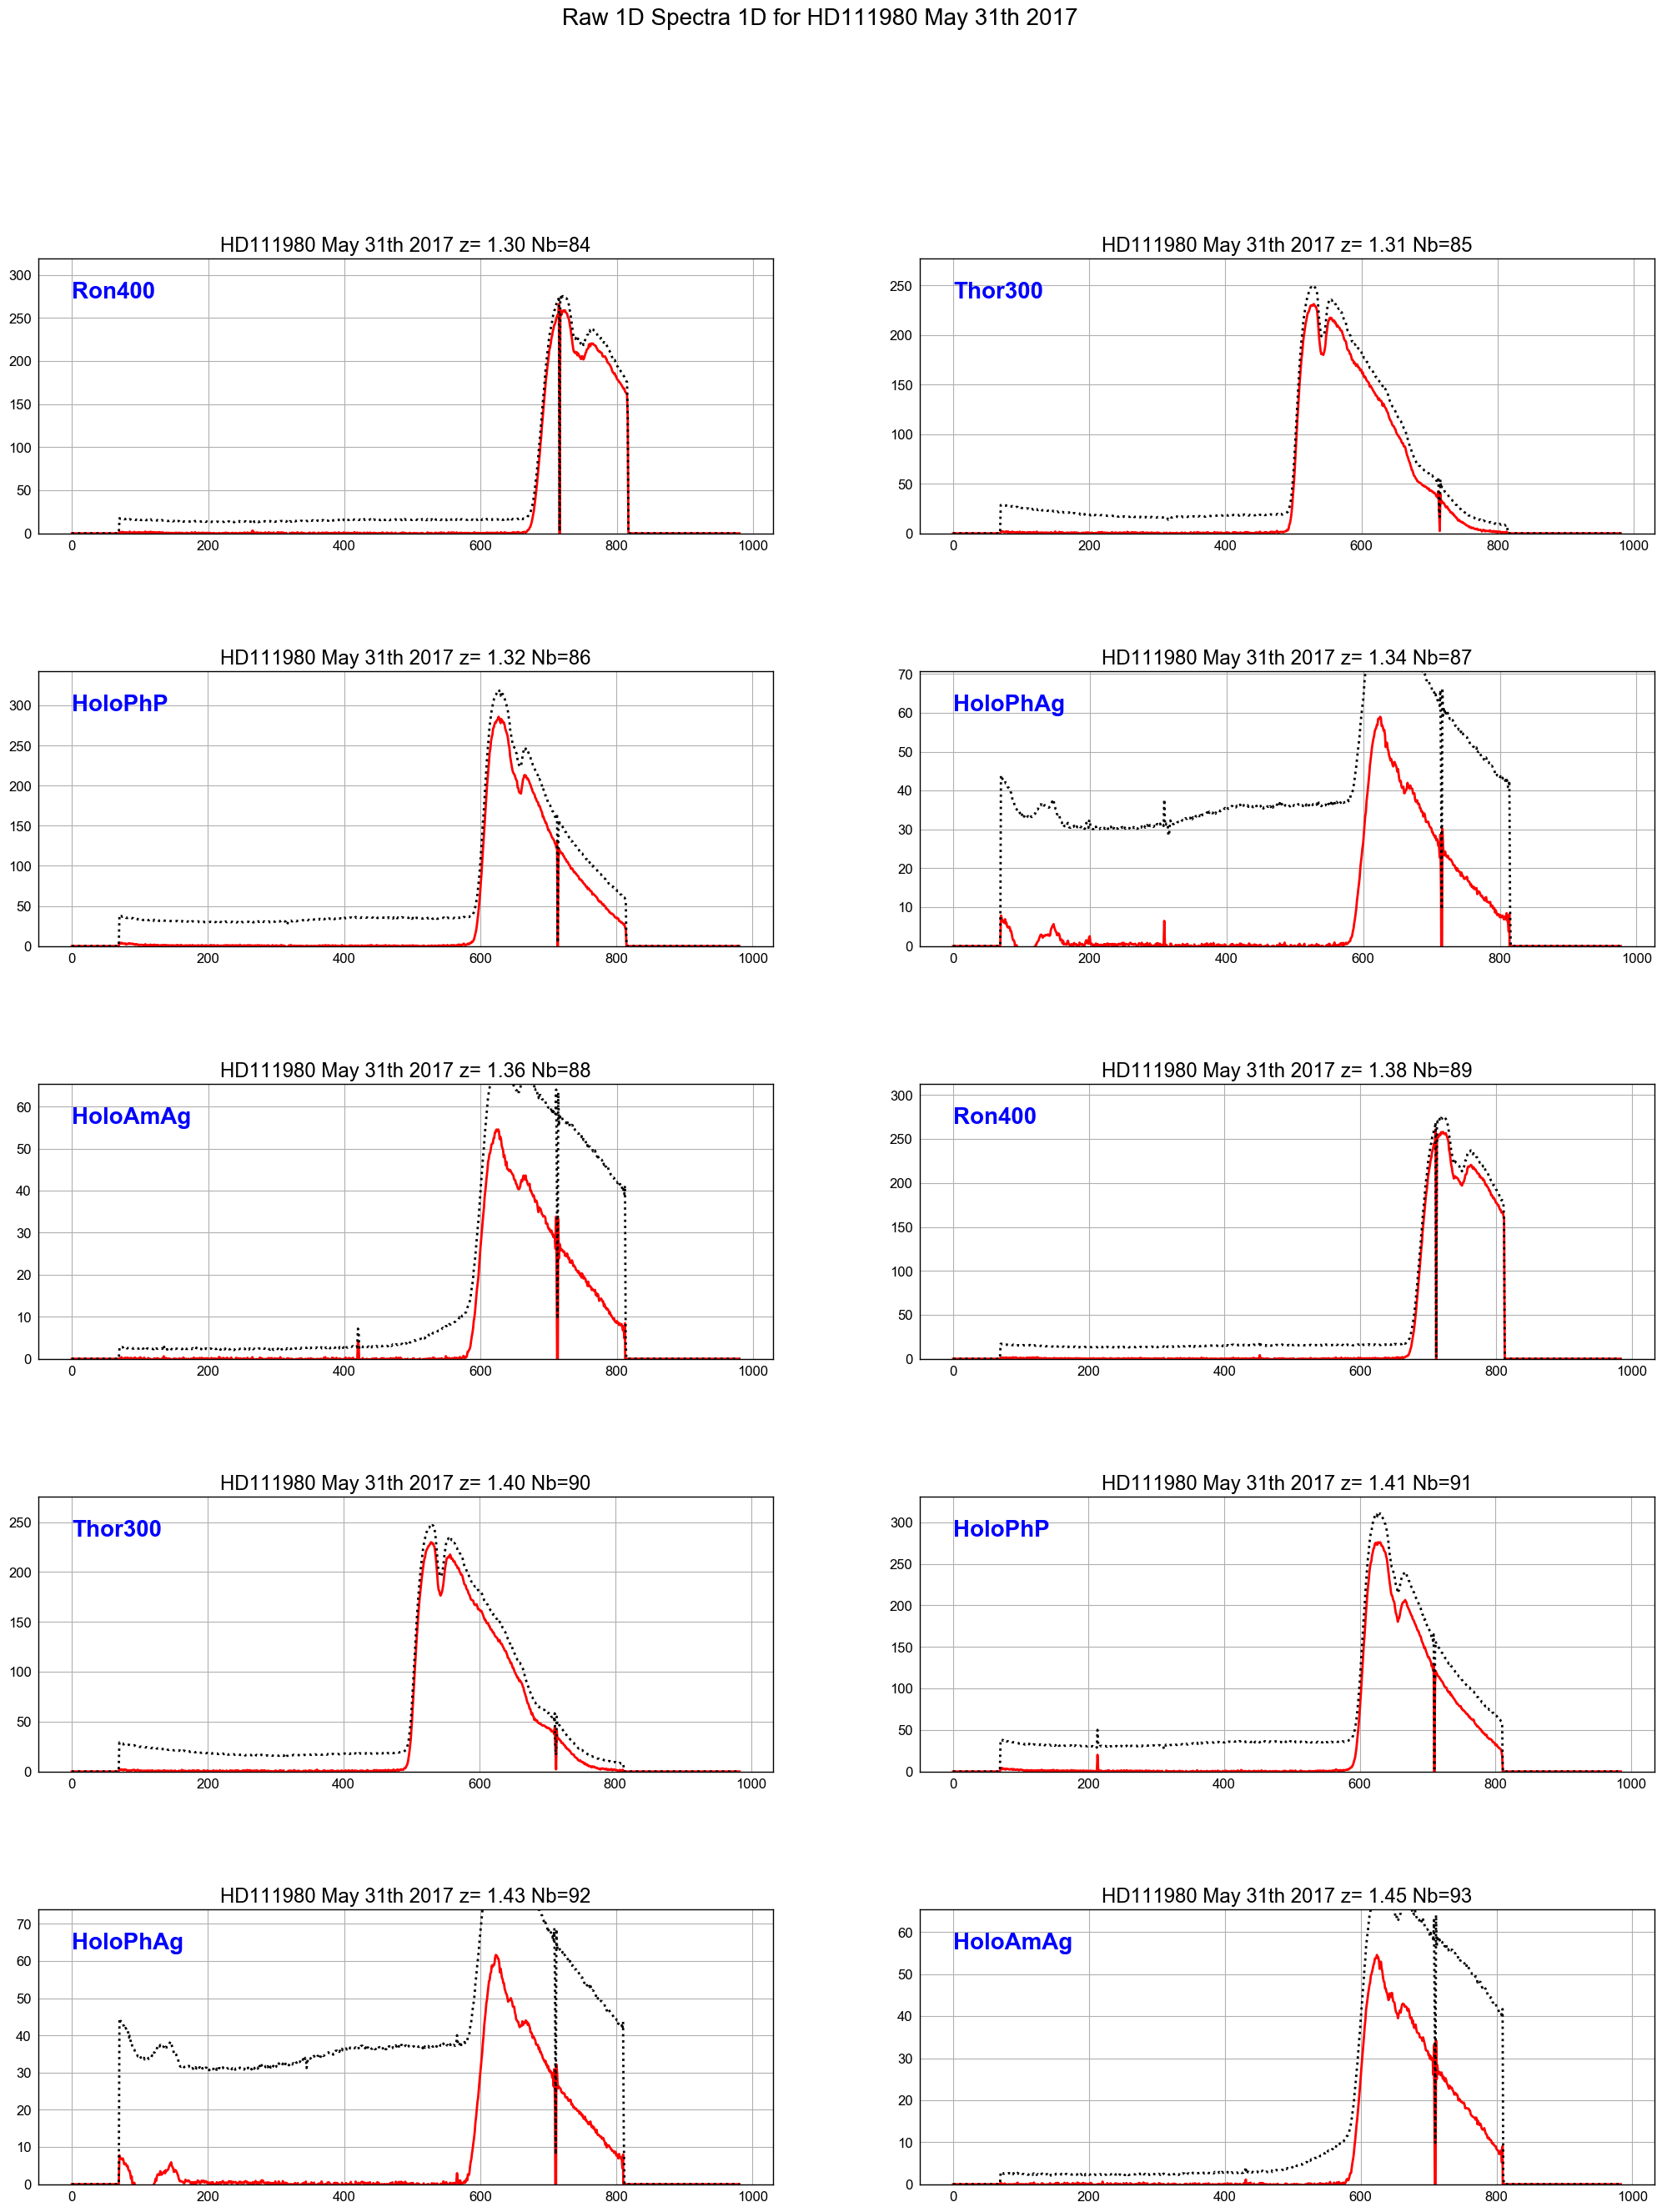

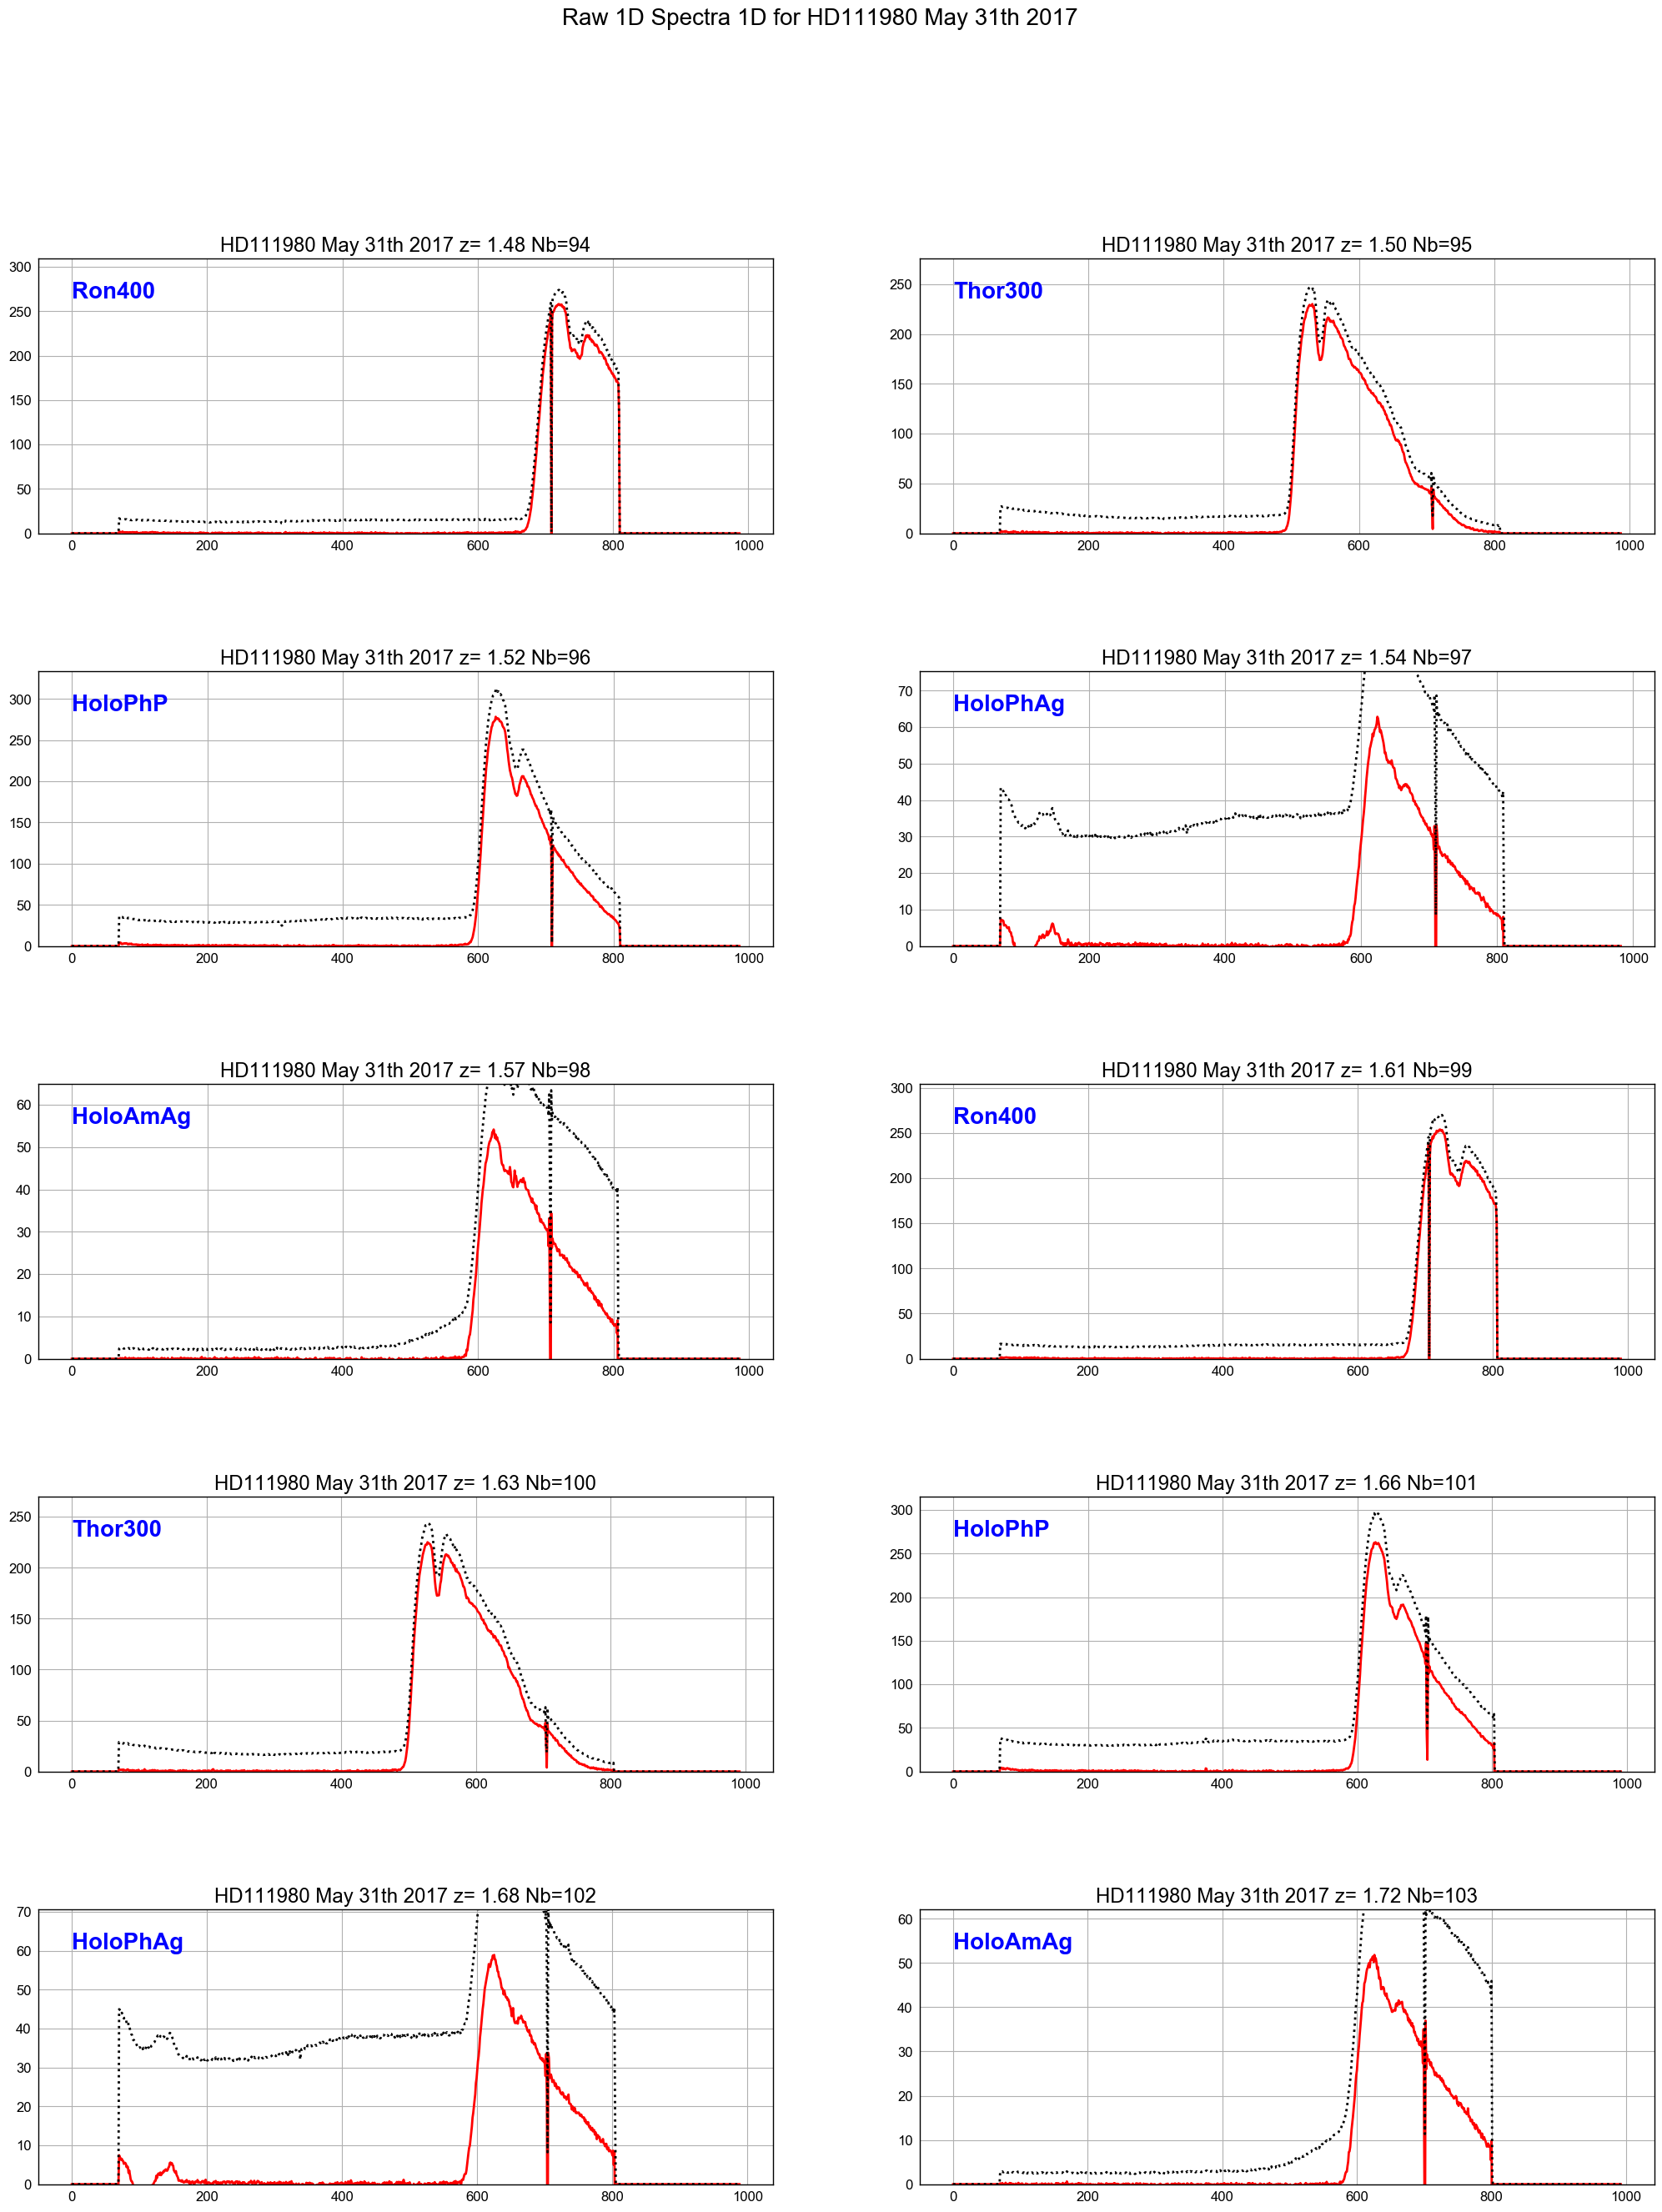

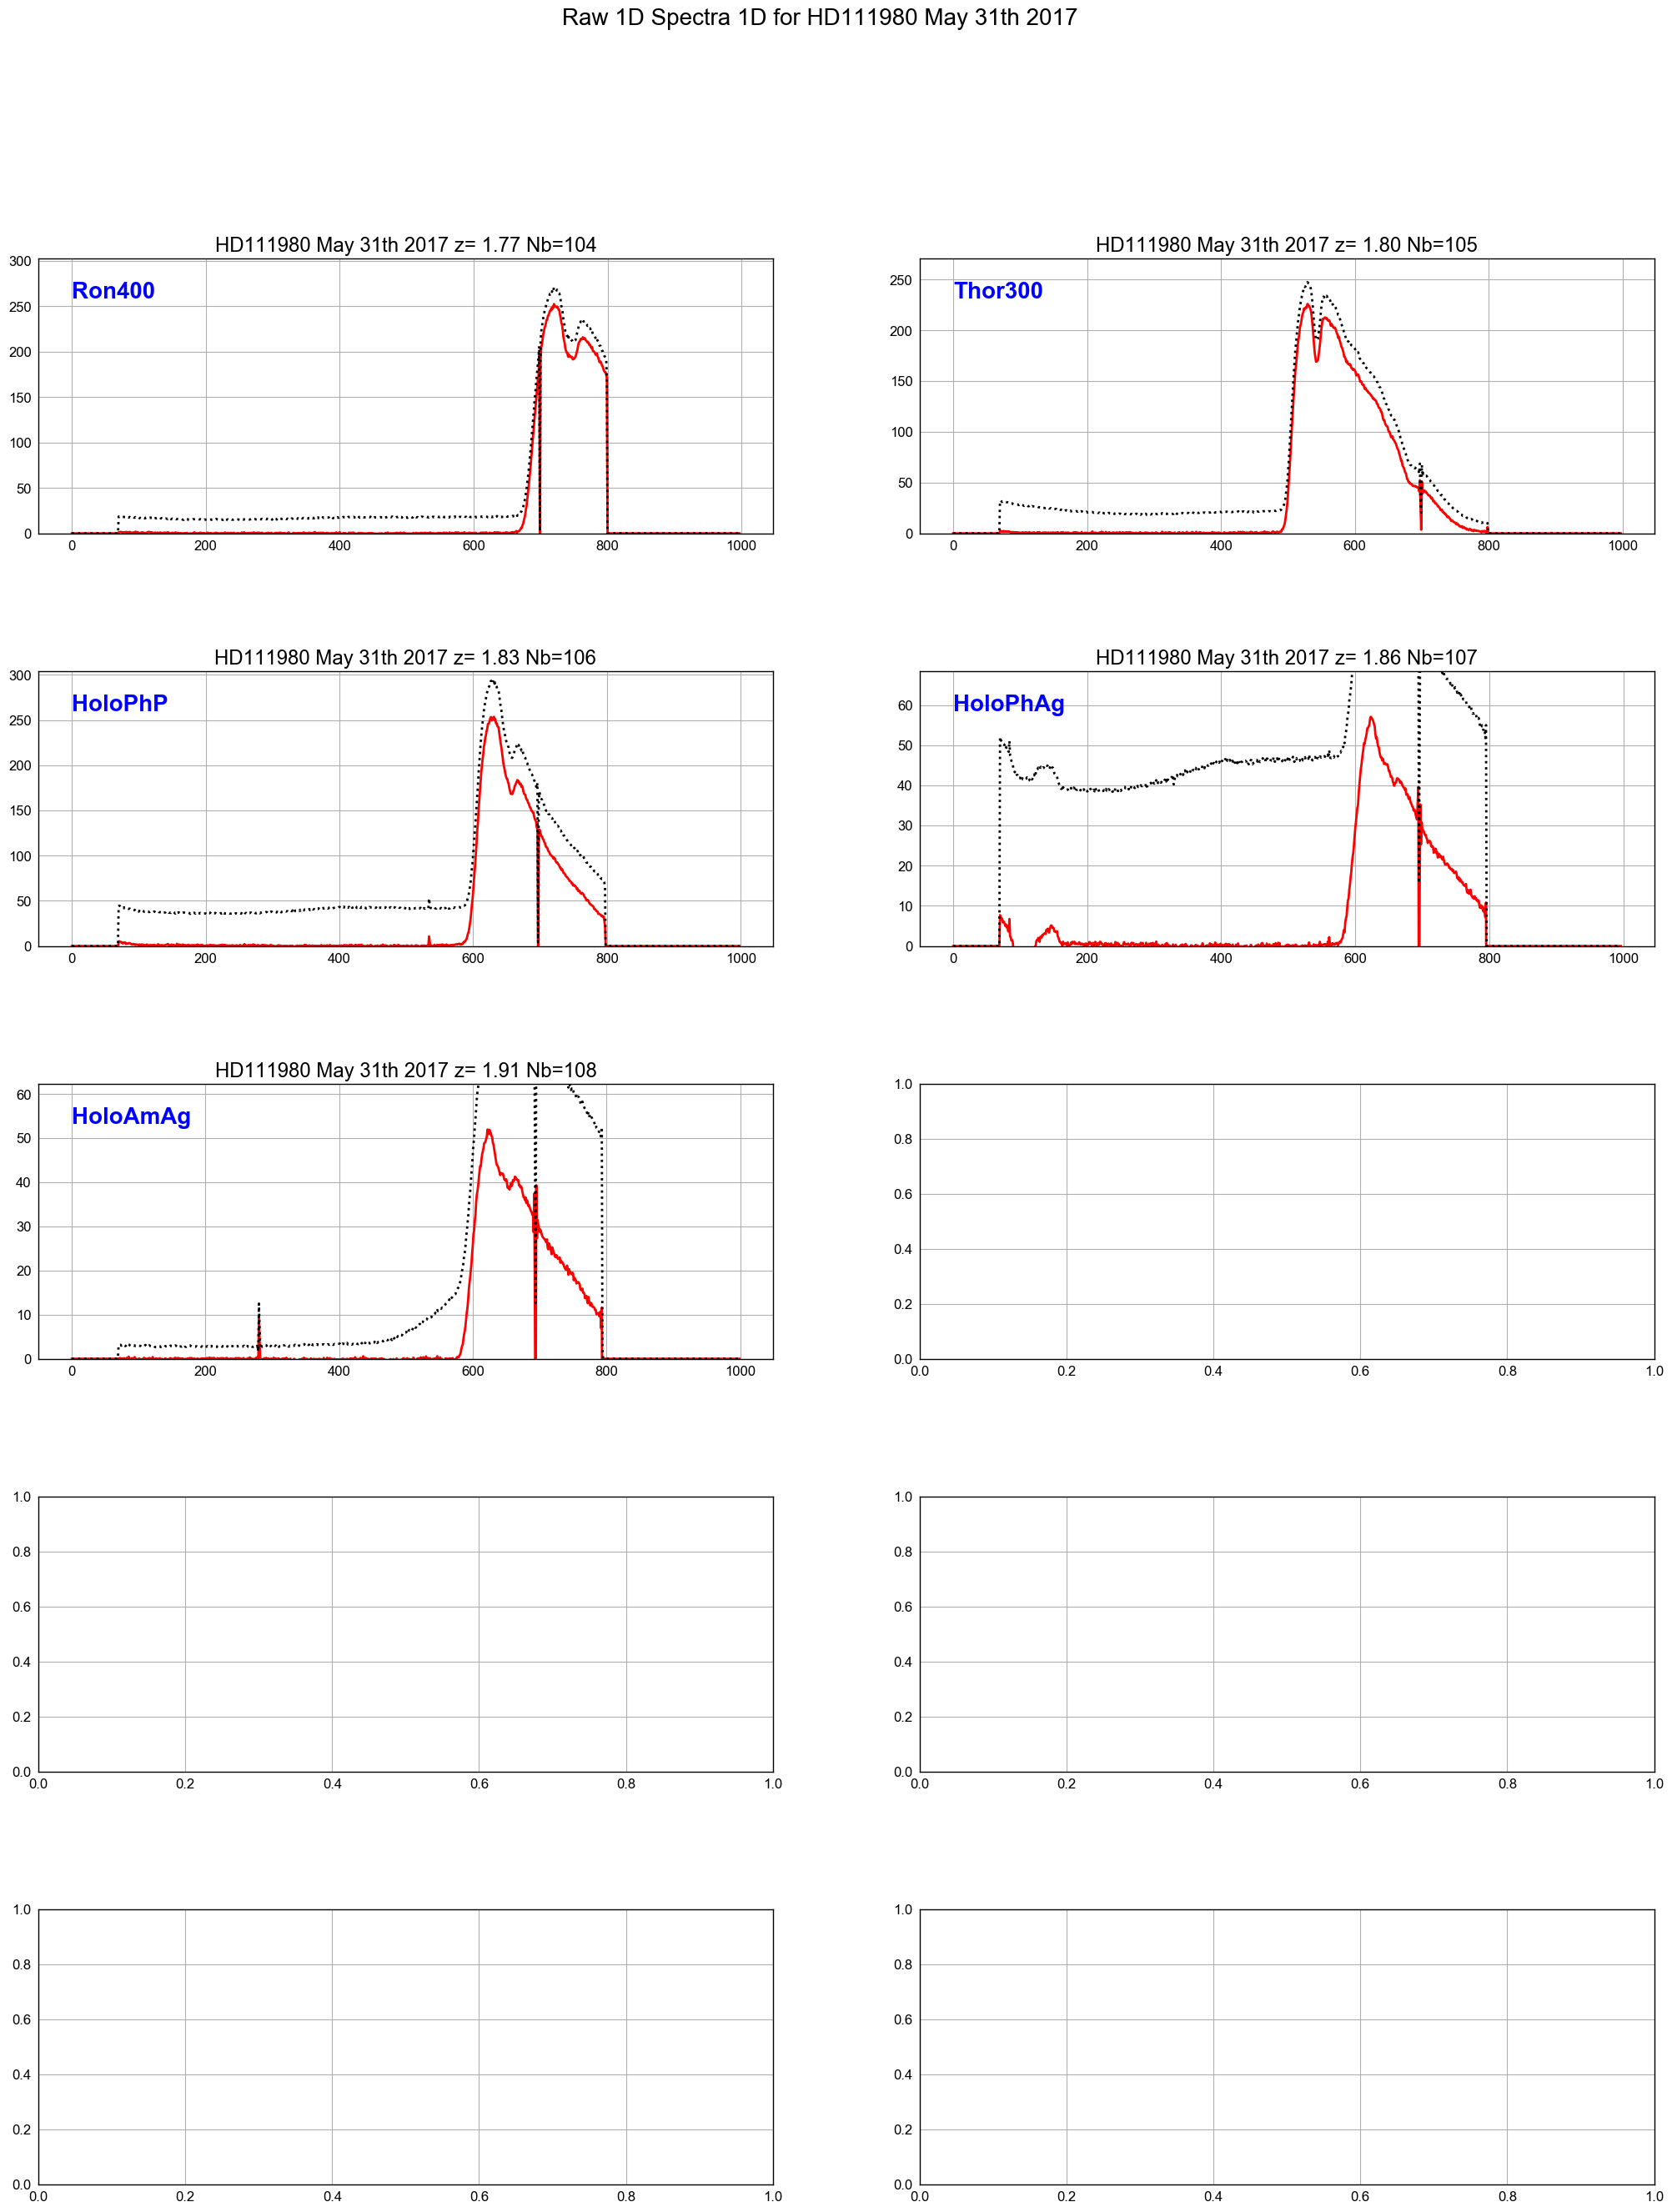

In [65]:
ShowSpectra(all_leftspectra,all_totleftspectra,all_titles,object_name,dir_top_images,all_filt,'raw1Dspectra_left.pdf')

In [66]:
sel=2

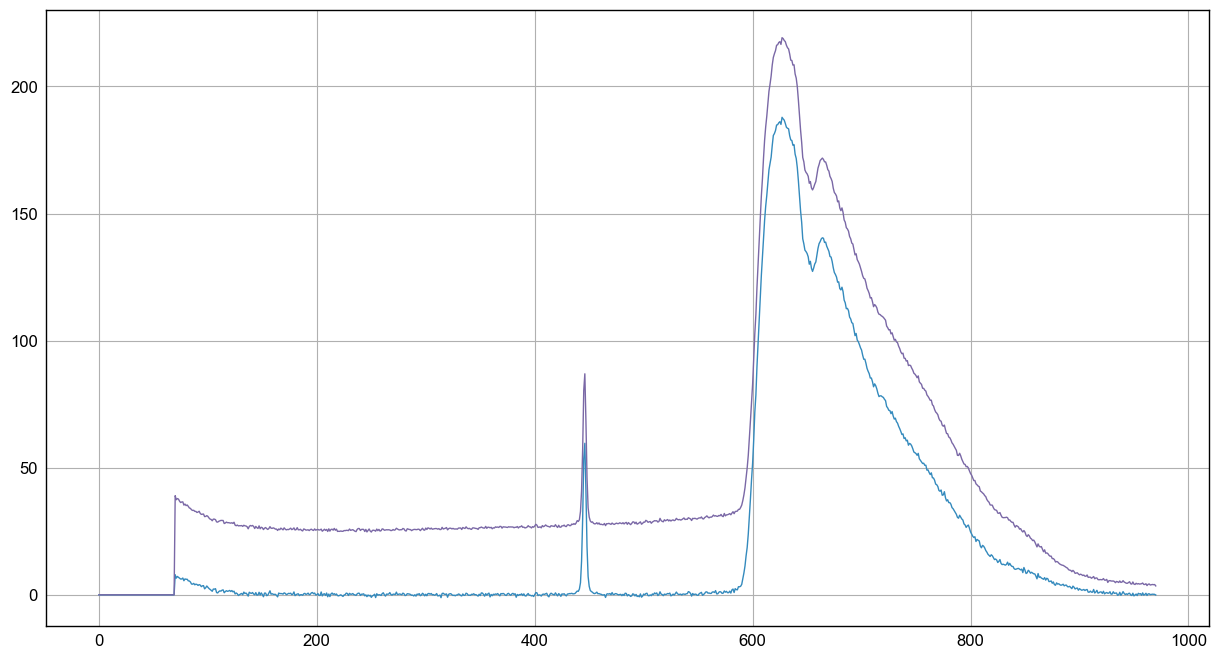

In [67]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[sel])
plt.plot(all_totrightspectra[sel])
#plt.xlim(0,500)
plt.grid(True)

## Calibrate in wavelength

In [45]:
from holo_specs import *

In [46]:
#%%cython
%load_ext autoreload
%autoreload 2
#import numpy as np
#import matplotlib.pyplot as plt
#import os

from holo_specs import *

def CALSPECAbsLineIdentification(spectra,redshift,all_titles,object_name,dir_top_images,all_filt,figname,tagname):
    """
    CALSPECAbsLineIdentification show the right part of spectrum with identified lines
    =====================
    """
    
    
    NBSPEC=len(spectra)
    NBIMGPERROW=2
    
    MAXIMGROW=max(2,int(m.ceil(float(NBSPEC)/float(NBIMGPERROW))))
    
    
    # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_images,figname)
   
    pp = PdfPages(figfilename) # create a pdf file
    
    
    title='WL calibrated 1D Spectra 1D for {} {}'.format(object_name,tagname)
    
    
    all_wl= []  # containers for wavelength
    
    ###############################
    left_cut = 0
    right_cut = 1800
    ################################
    
    
    for index in np.arange(0,NBSPEC):
        
             
        # new pdf page    
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20)
            
        # index of image in the pdf page    
        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
        
        
        
        spec = spectra[index]
        ######## convert pixels to wavelengths #########
        print '-----------------------------------------------------'
        print all_filt[index]
        holo = Hologram(all_filt[index])
        print '-----------------------------------------------------'
        #pixels = np.arange(left_cut,right_cut,1)
        pixels = np.arange(left_cut,left_cut+spec.shape[0],1)
        lambdas = holo.grating_pixel_to_lambda(pixels)
        
        all_wl.append(lambdas)
        
        axarr[iy,ix].plot(lambdas,spec,'r-',lw=2,label=tagname)
    
        ######## plot QSO emission lines ############
        axarr[iy,ix].plot([HALPHA*(1+redshift),HALPHA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\alpha$')
        axarr[iy,ix].plot([HBETA*(1+redshift),HBETA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\beta$')
        axarr[iy,ix].plot([HGAMMA*(1+redshift),HGAMMA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\gamma$')
        axarr[iy,ix].plot([HDELTA*(1+redshift),HDELTA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\delta$')
        
        axarr[iy,ix].plot([760,760],[0.,spec.max()*1.2],lw=2,label='$O_2$')
        
        
        #plot_atomic_lines(axarr[index],spec.max()*1.2,redshift=redshift,atmospheric_lines=False)
        ######## set plot
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].text(600.,spec.max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
        axarr[iy,ix].legend(loc='best',fontsize=16)
        axarr[iy,ix].set_xlabel('Wavelength [nm]', fontsize=16)
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spec.max()*1.2)
        axarr[iy,ix].set_xlim(np.min(lambdas),np.max(lambdas))
    
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
    
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()   
   
    return all_wl


In [47]:
redshift=0

-----------------------------------------------------
Ron400
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 401.60 +/- 1.14 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
-----------------------------------------------------
Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.43 +/- 0.88 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 5

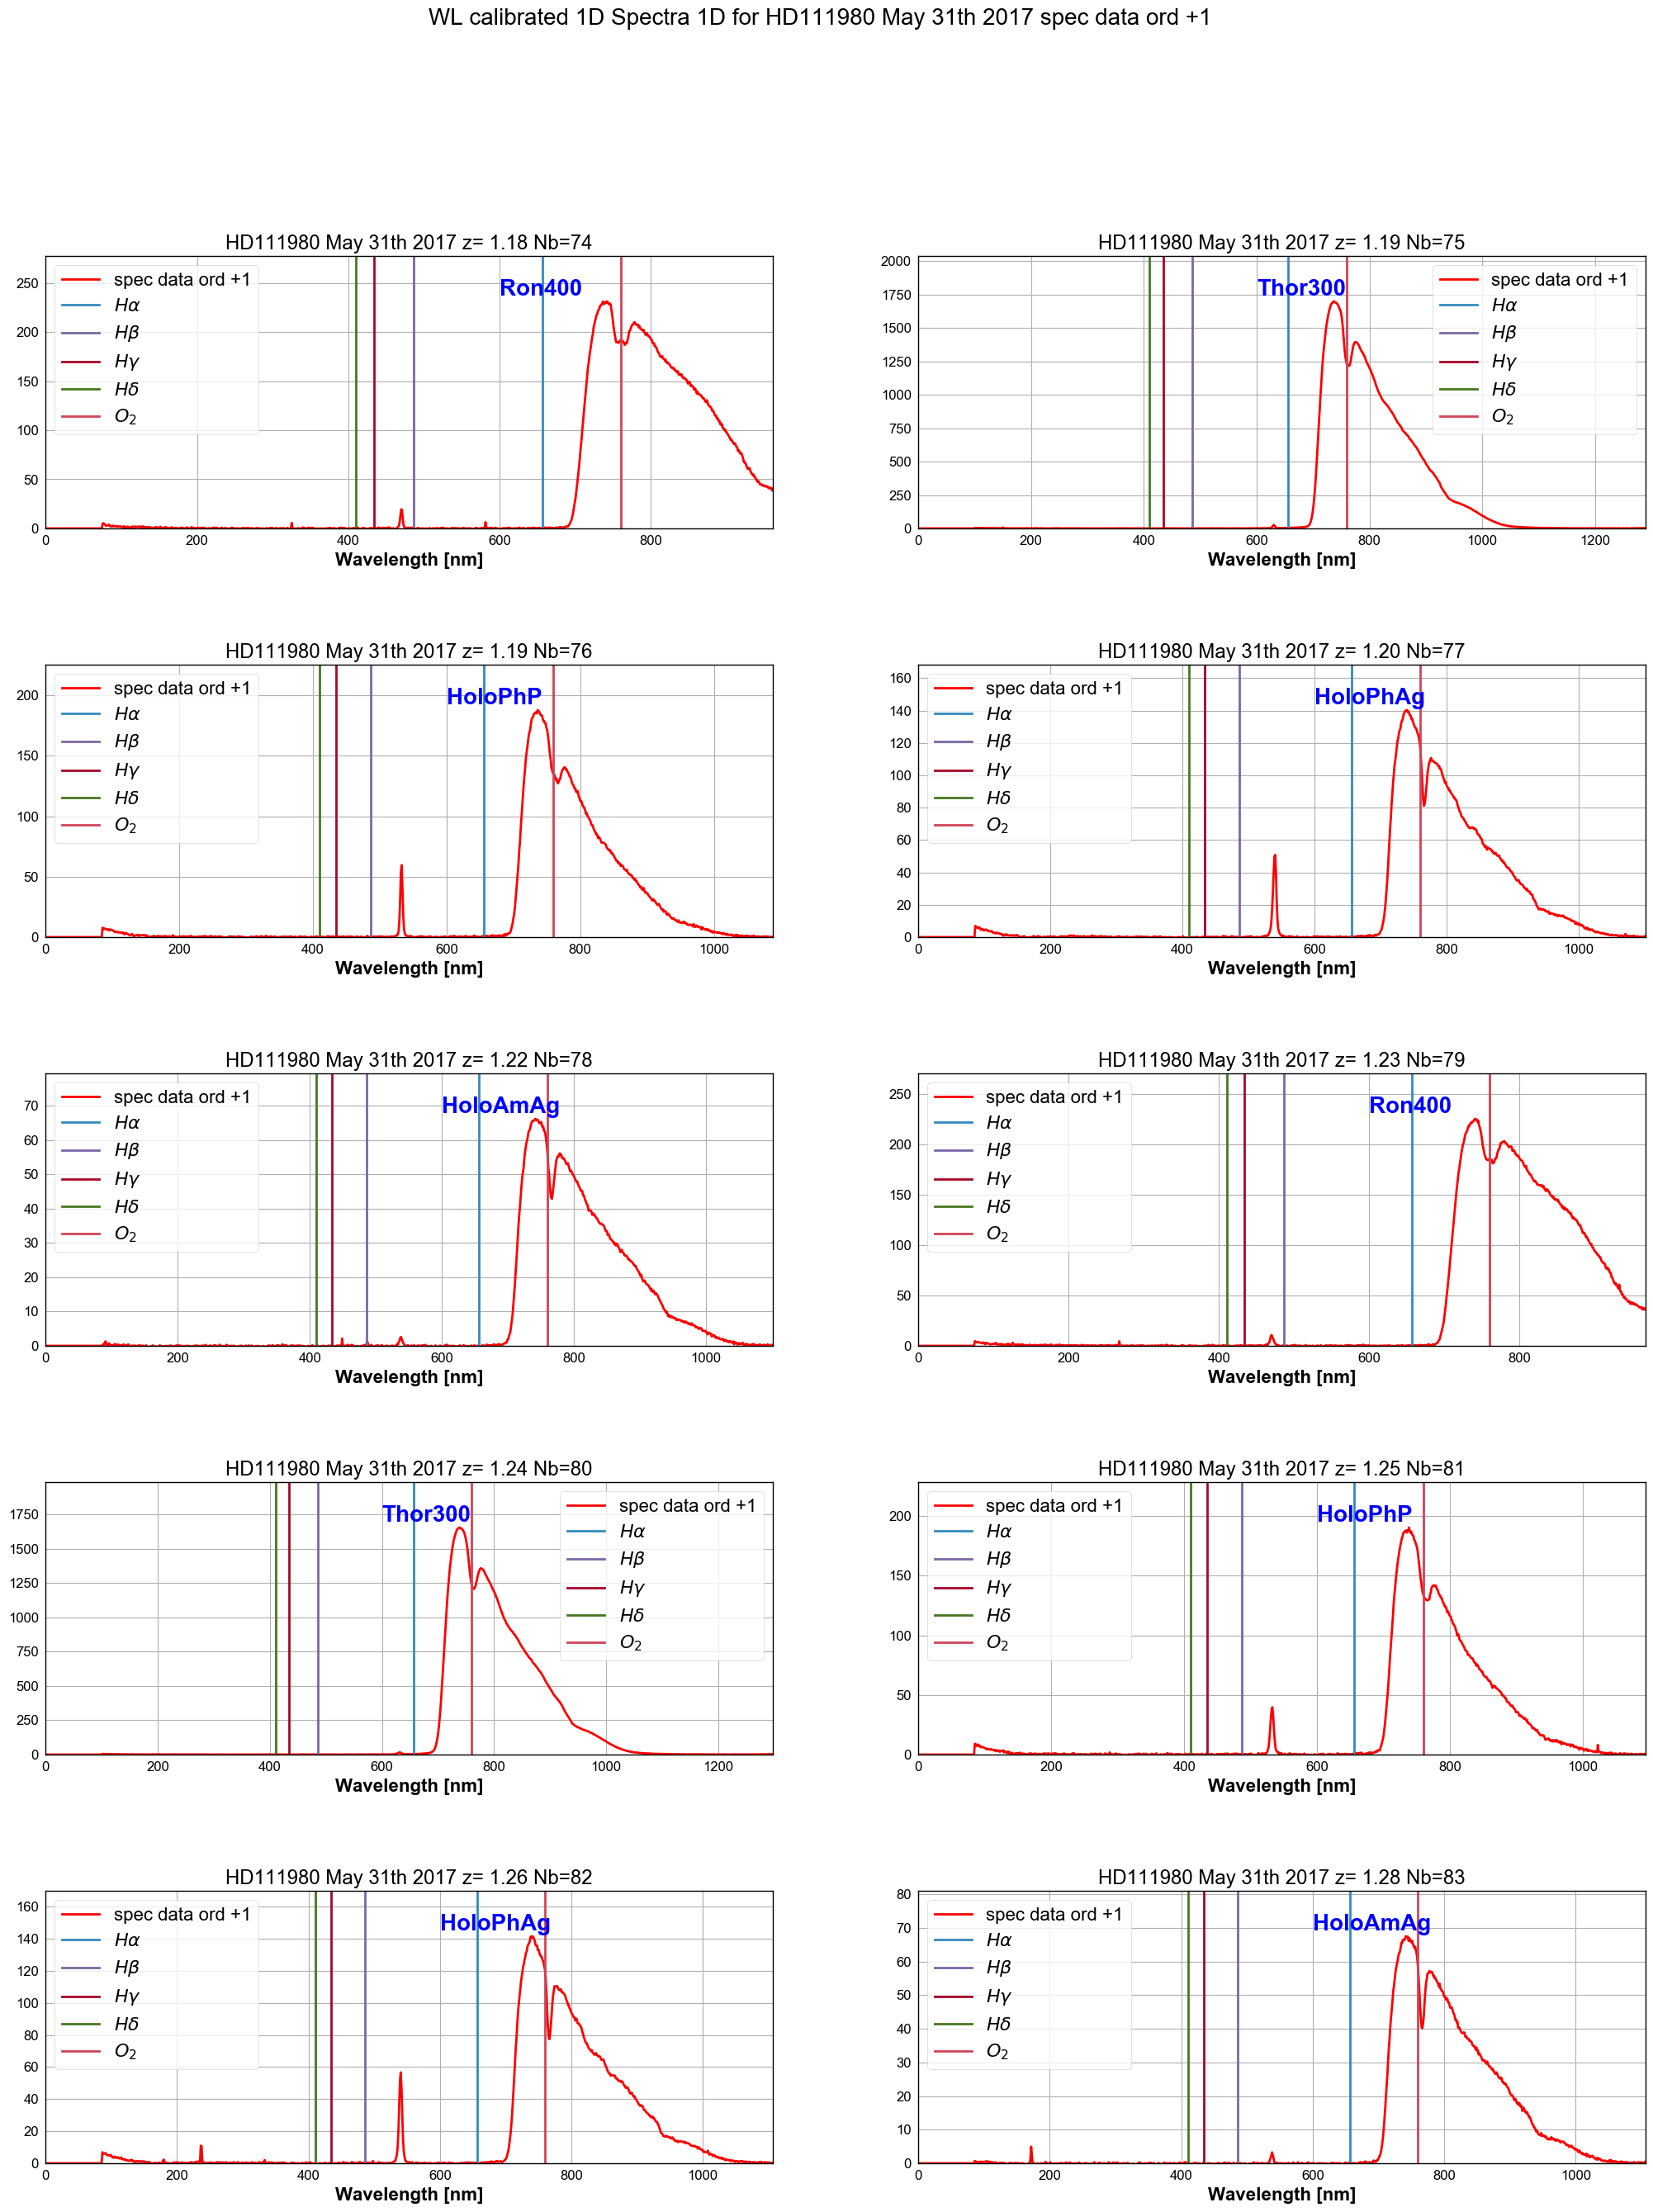

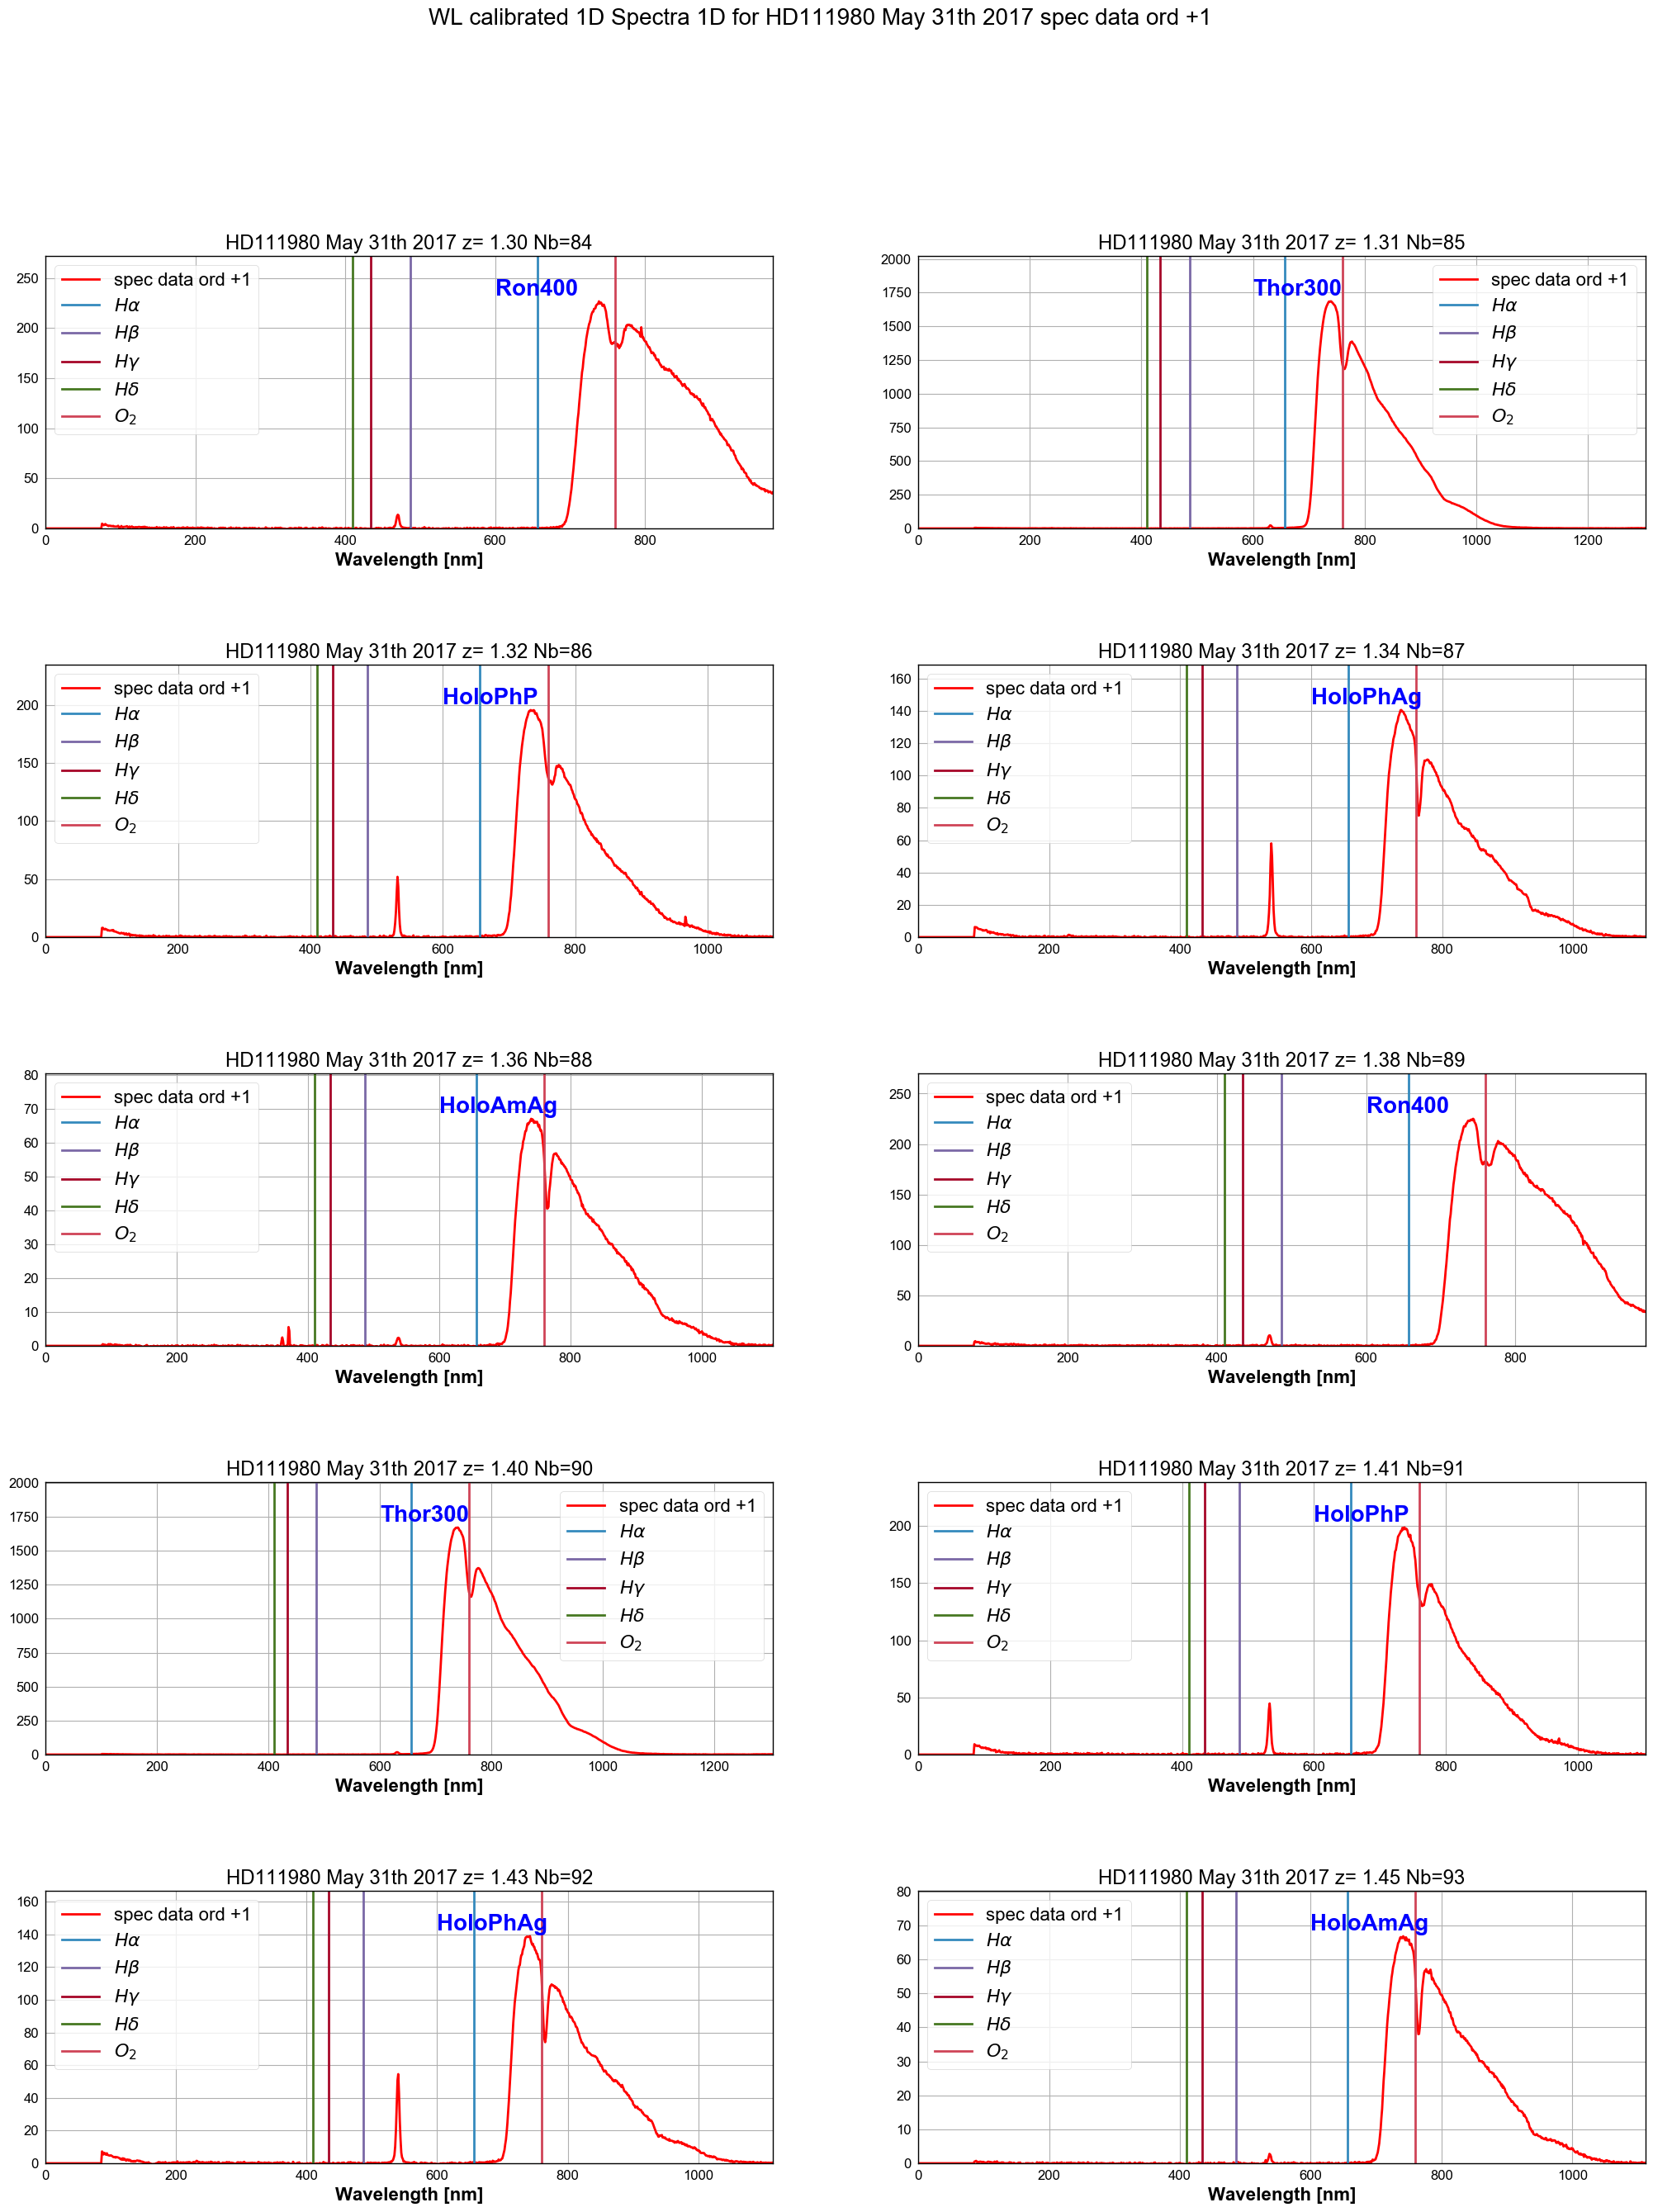

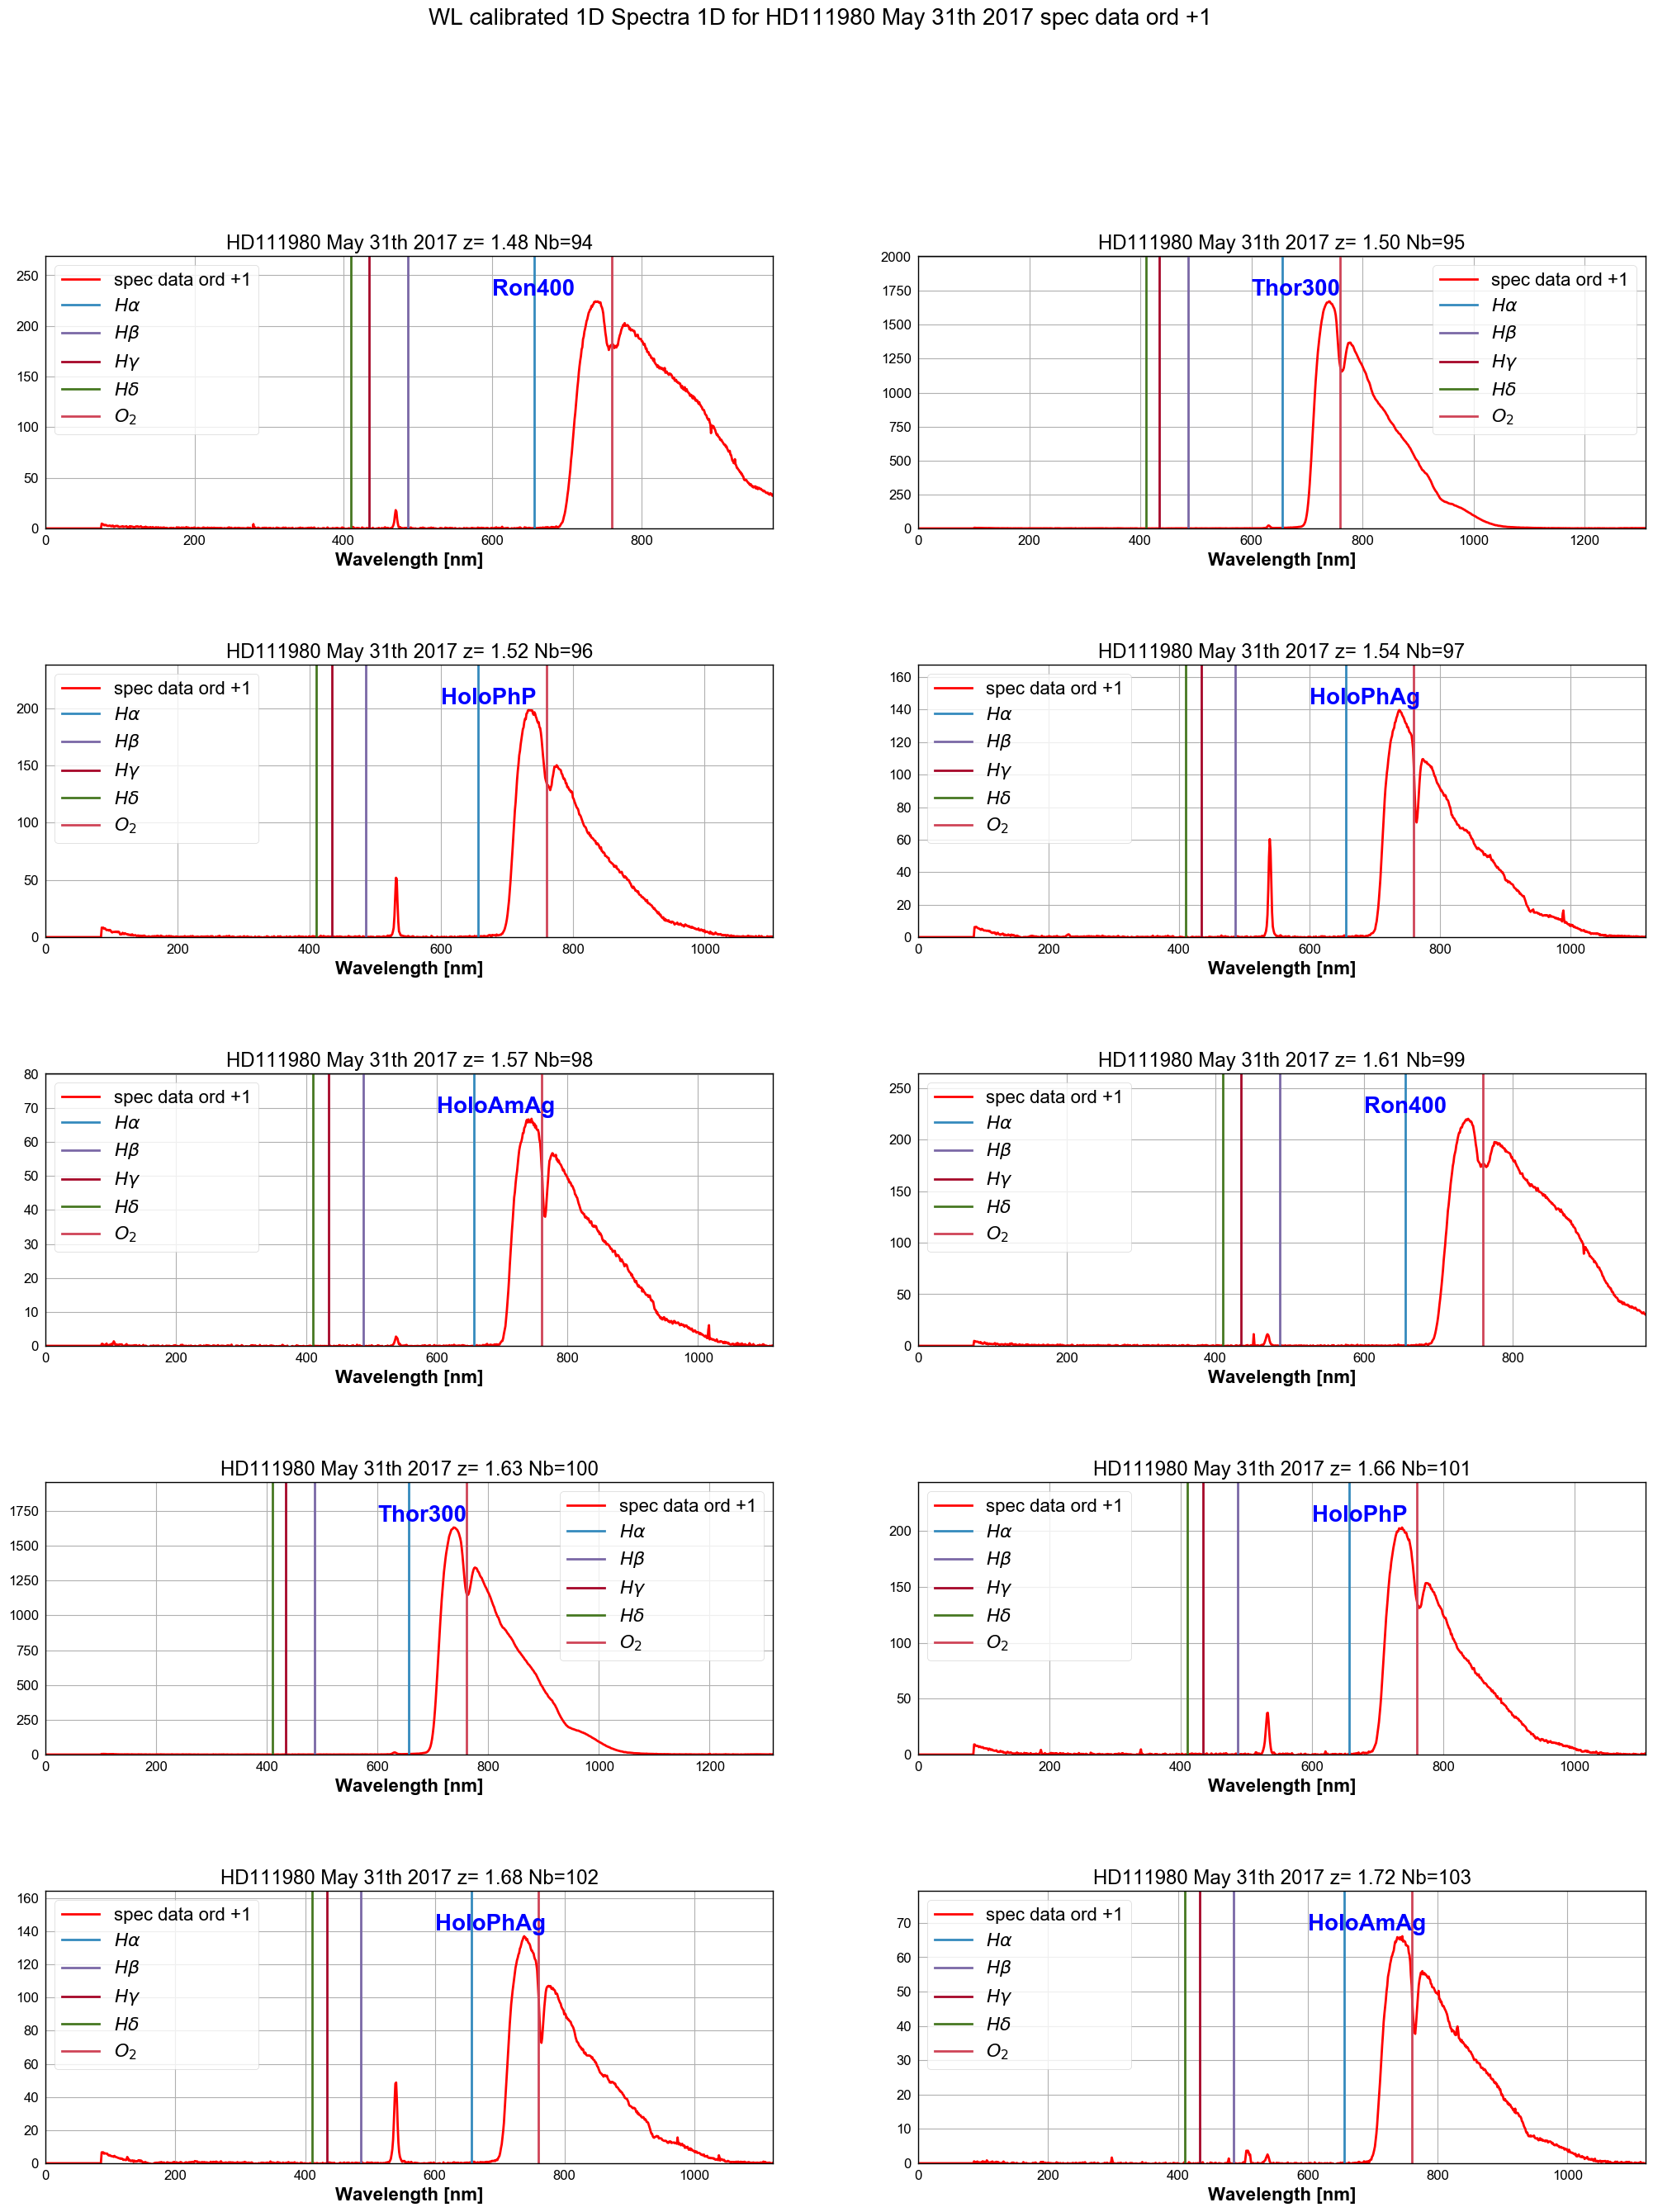

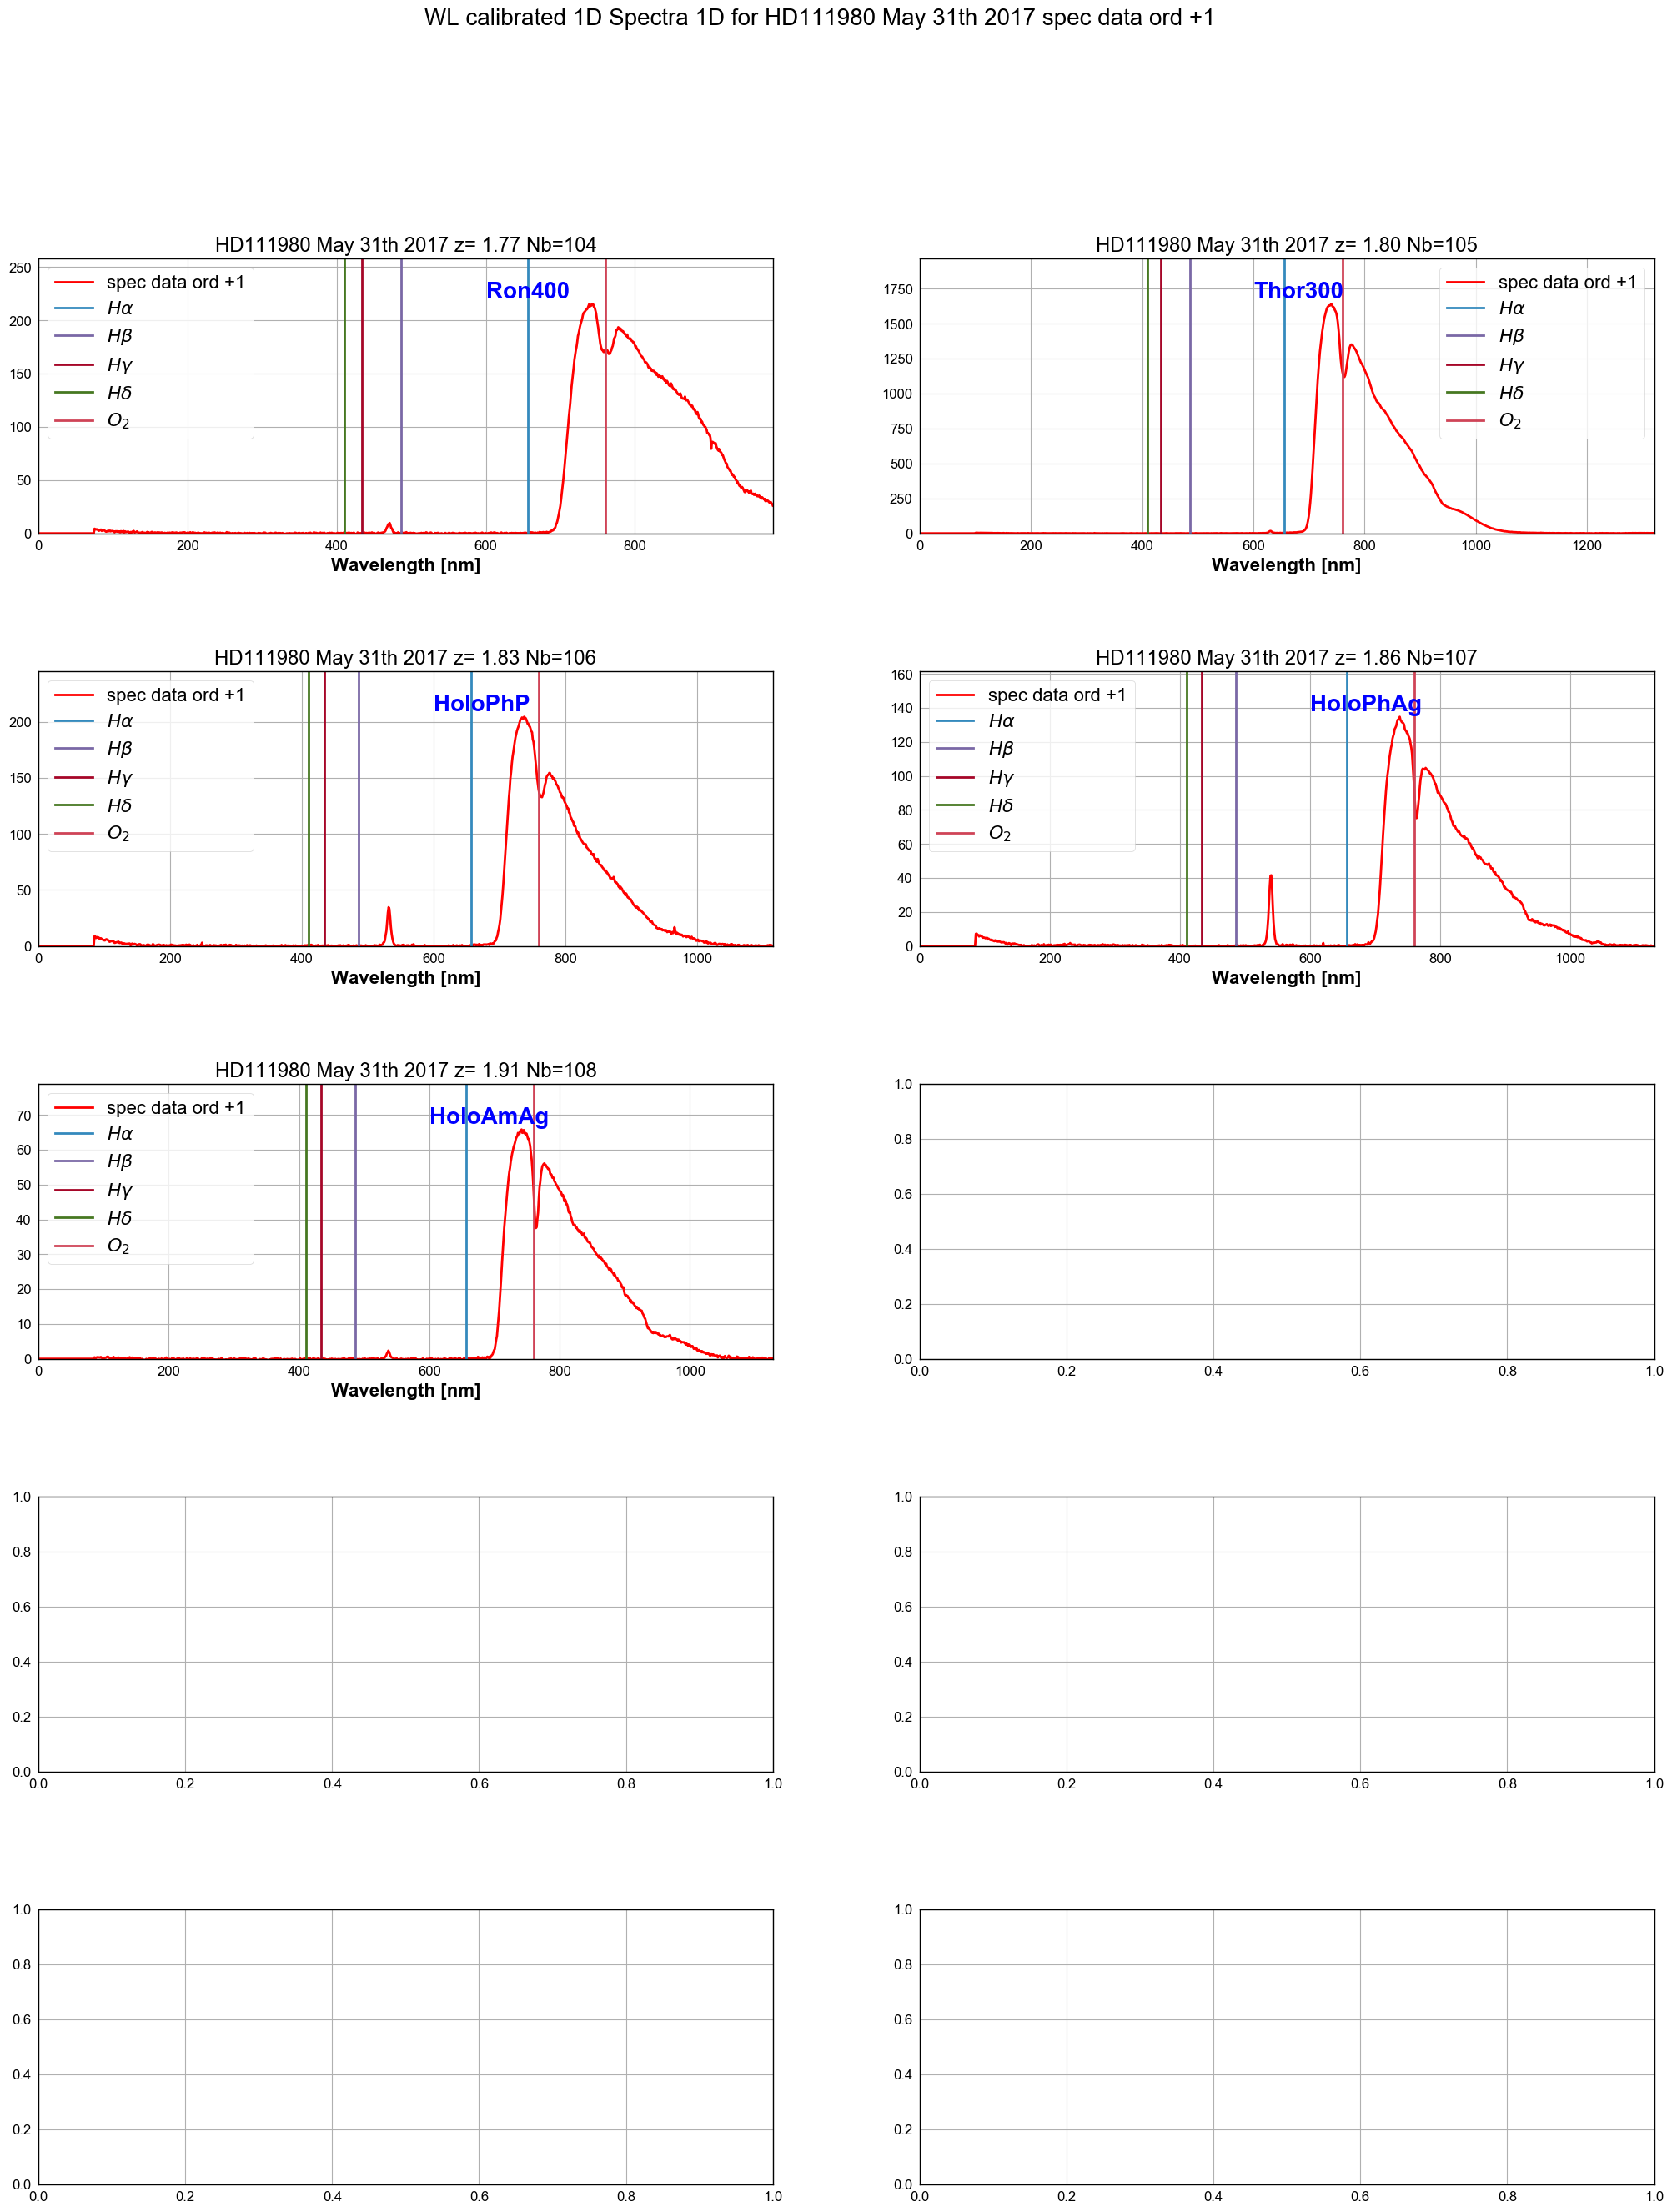

In [48]:
all_wl_right=CALSPECAbsLineIdentification(all_rightspectra,redshift,all_titles,object_name,dir_top_images,all_filt,'CALSPEC_rightspectrum.pdf','spec data ord +1')

-----------------------------------------------------
Ron400
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 401.60 +/- 1.14 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
-----------------------------------------------------
Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.43 +/- 0.88 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 5

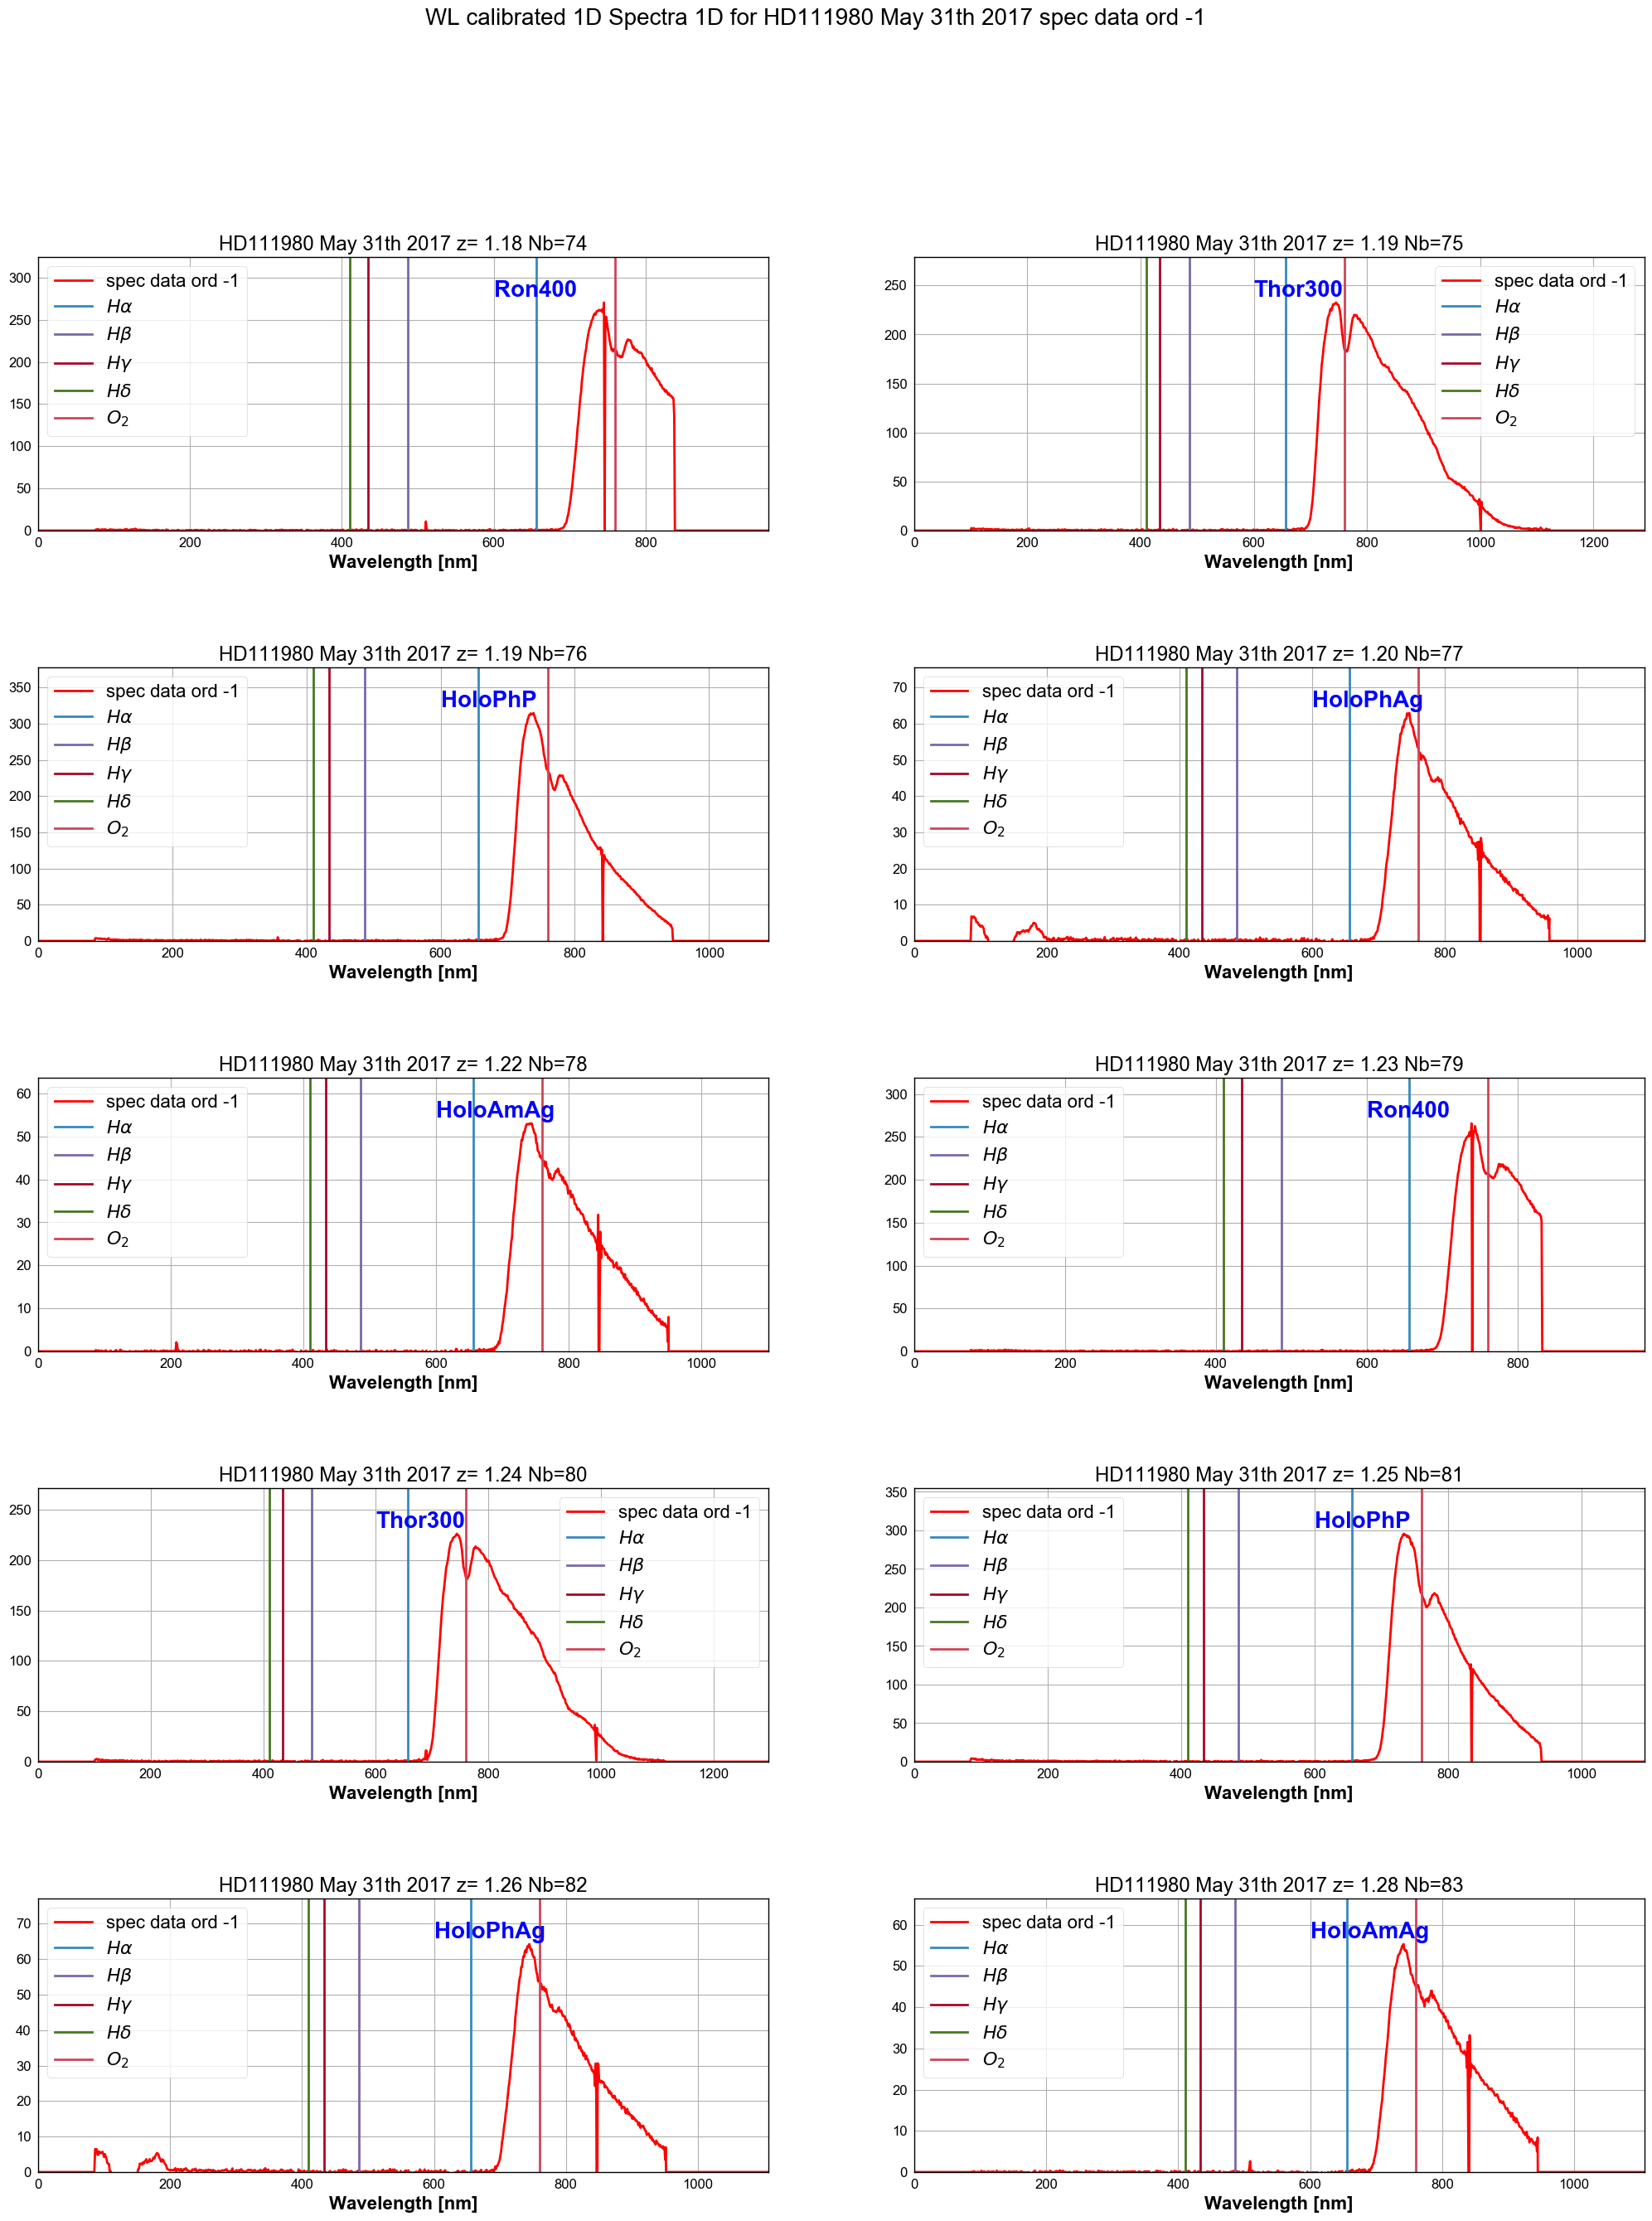

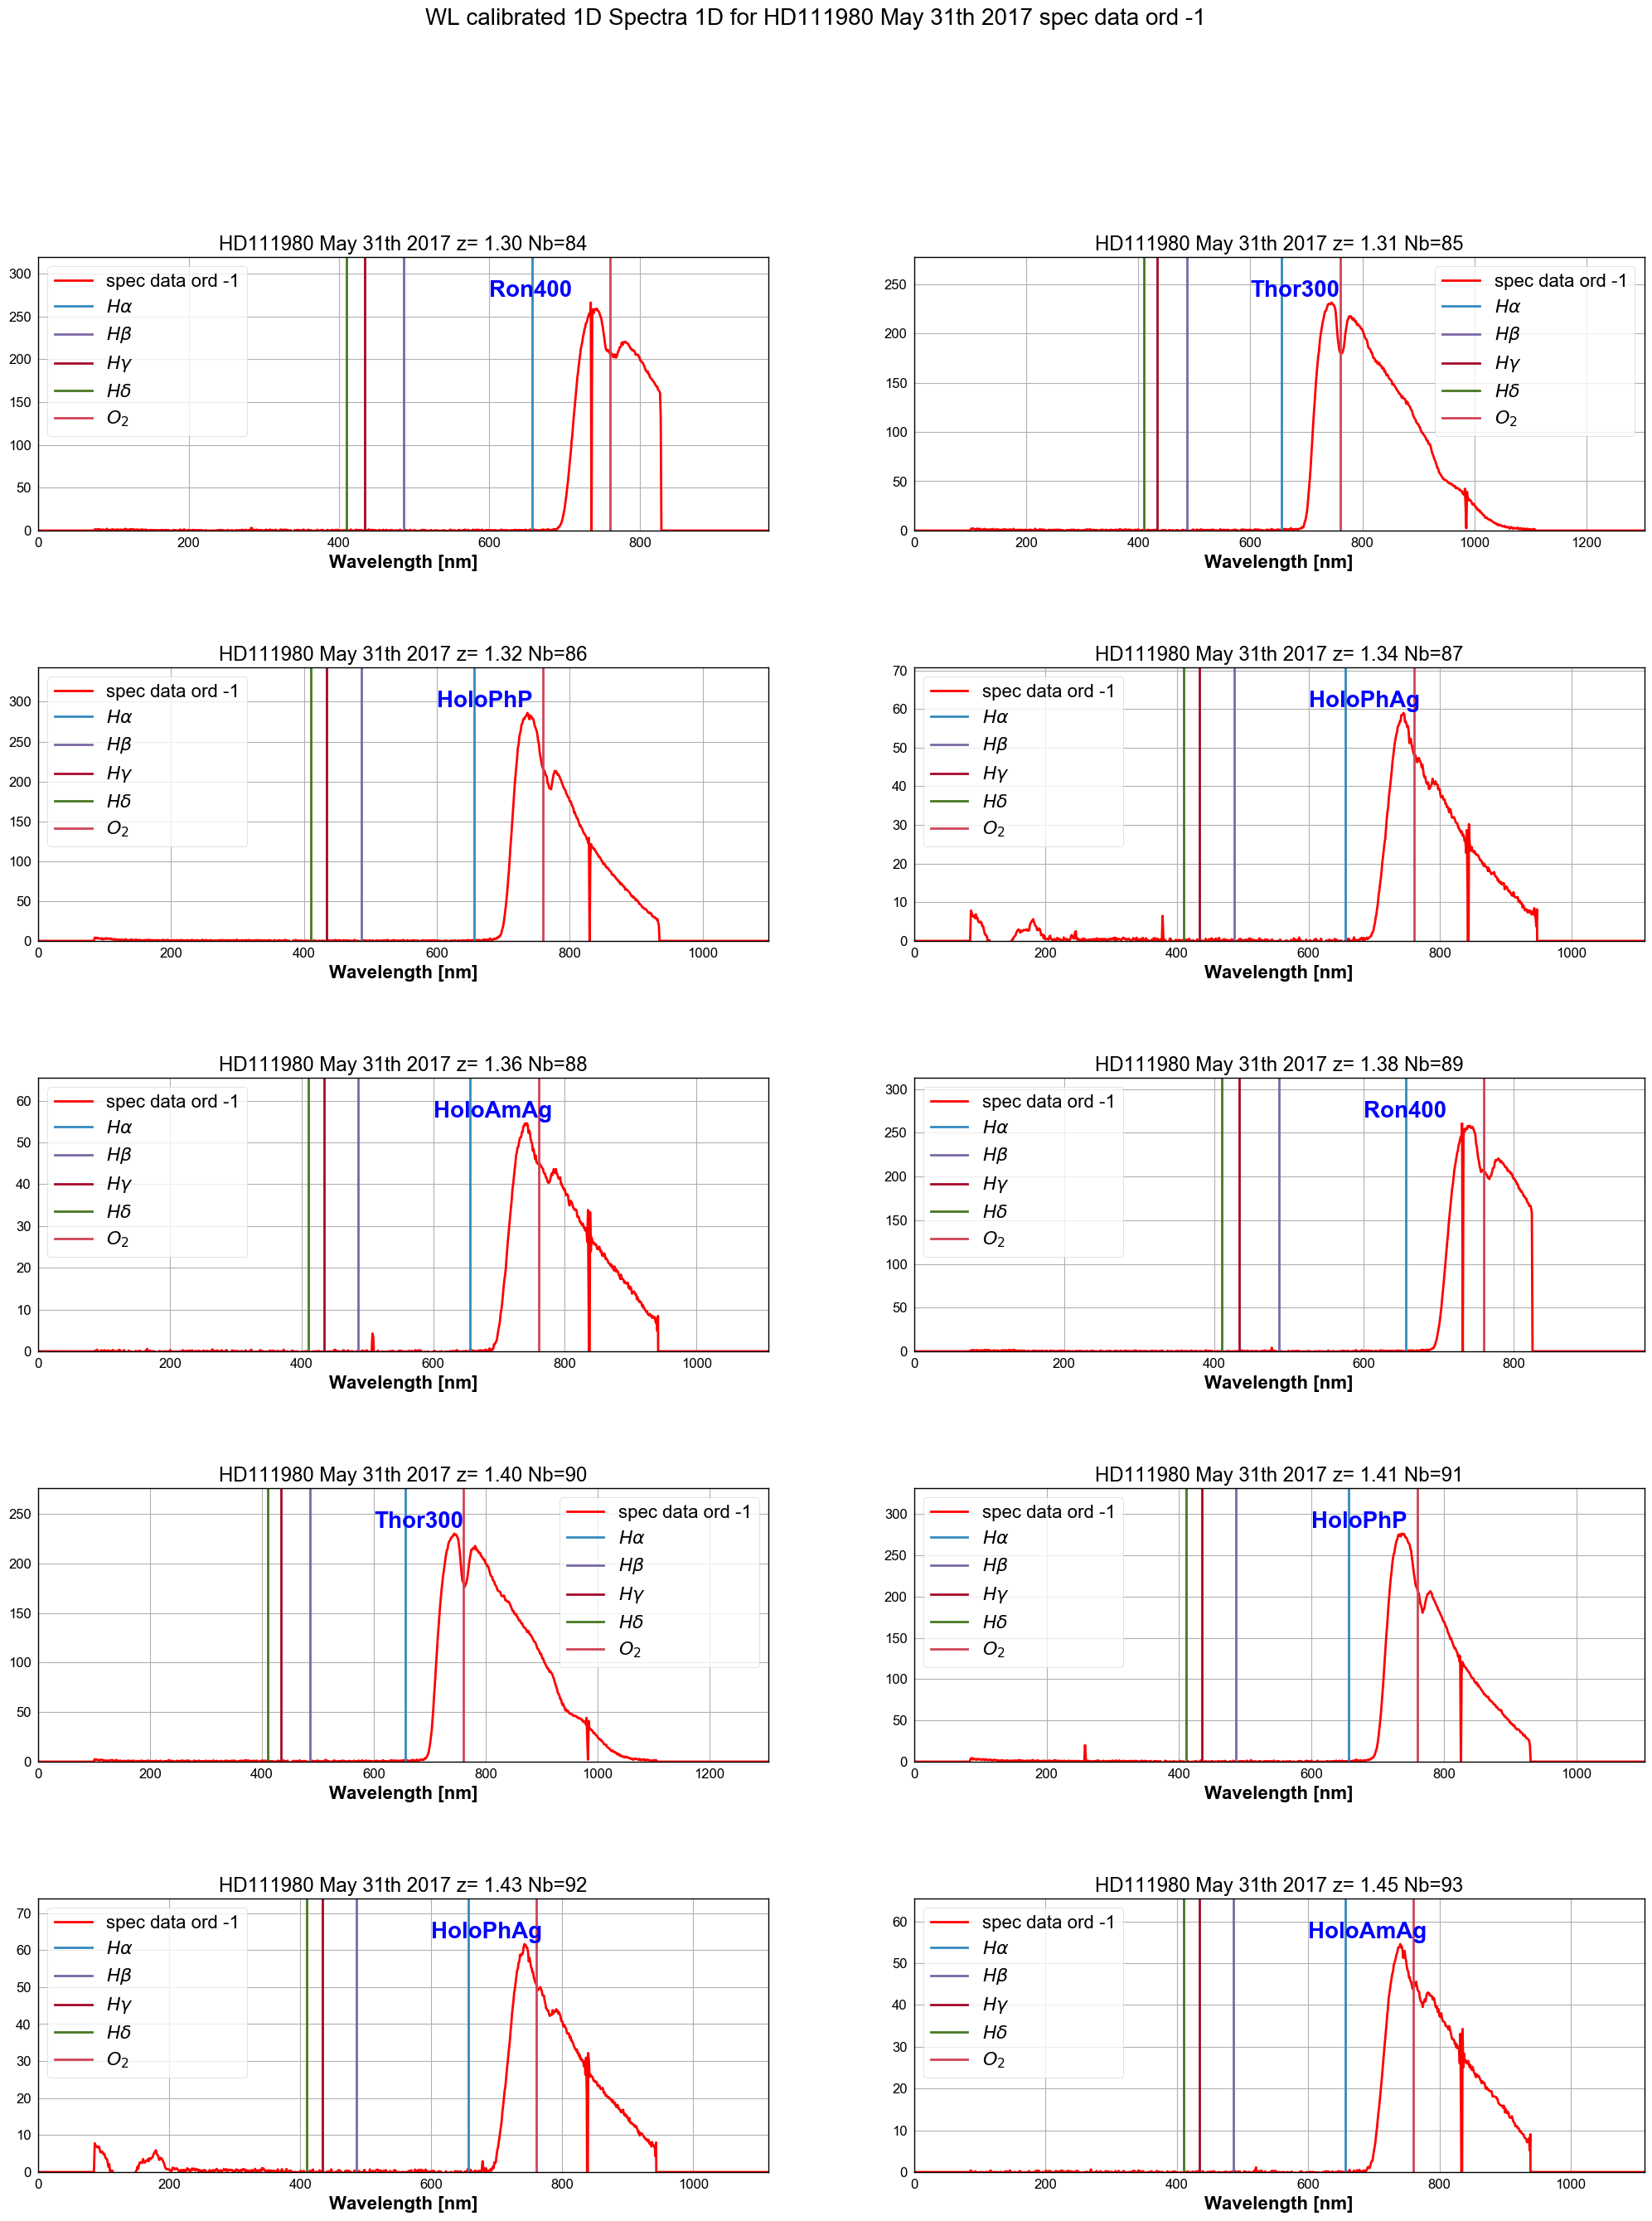

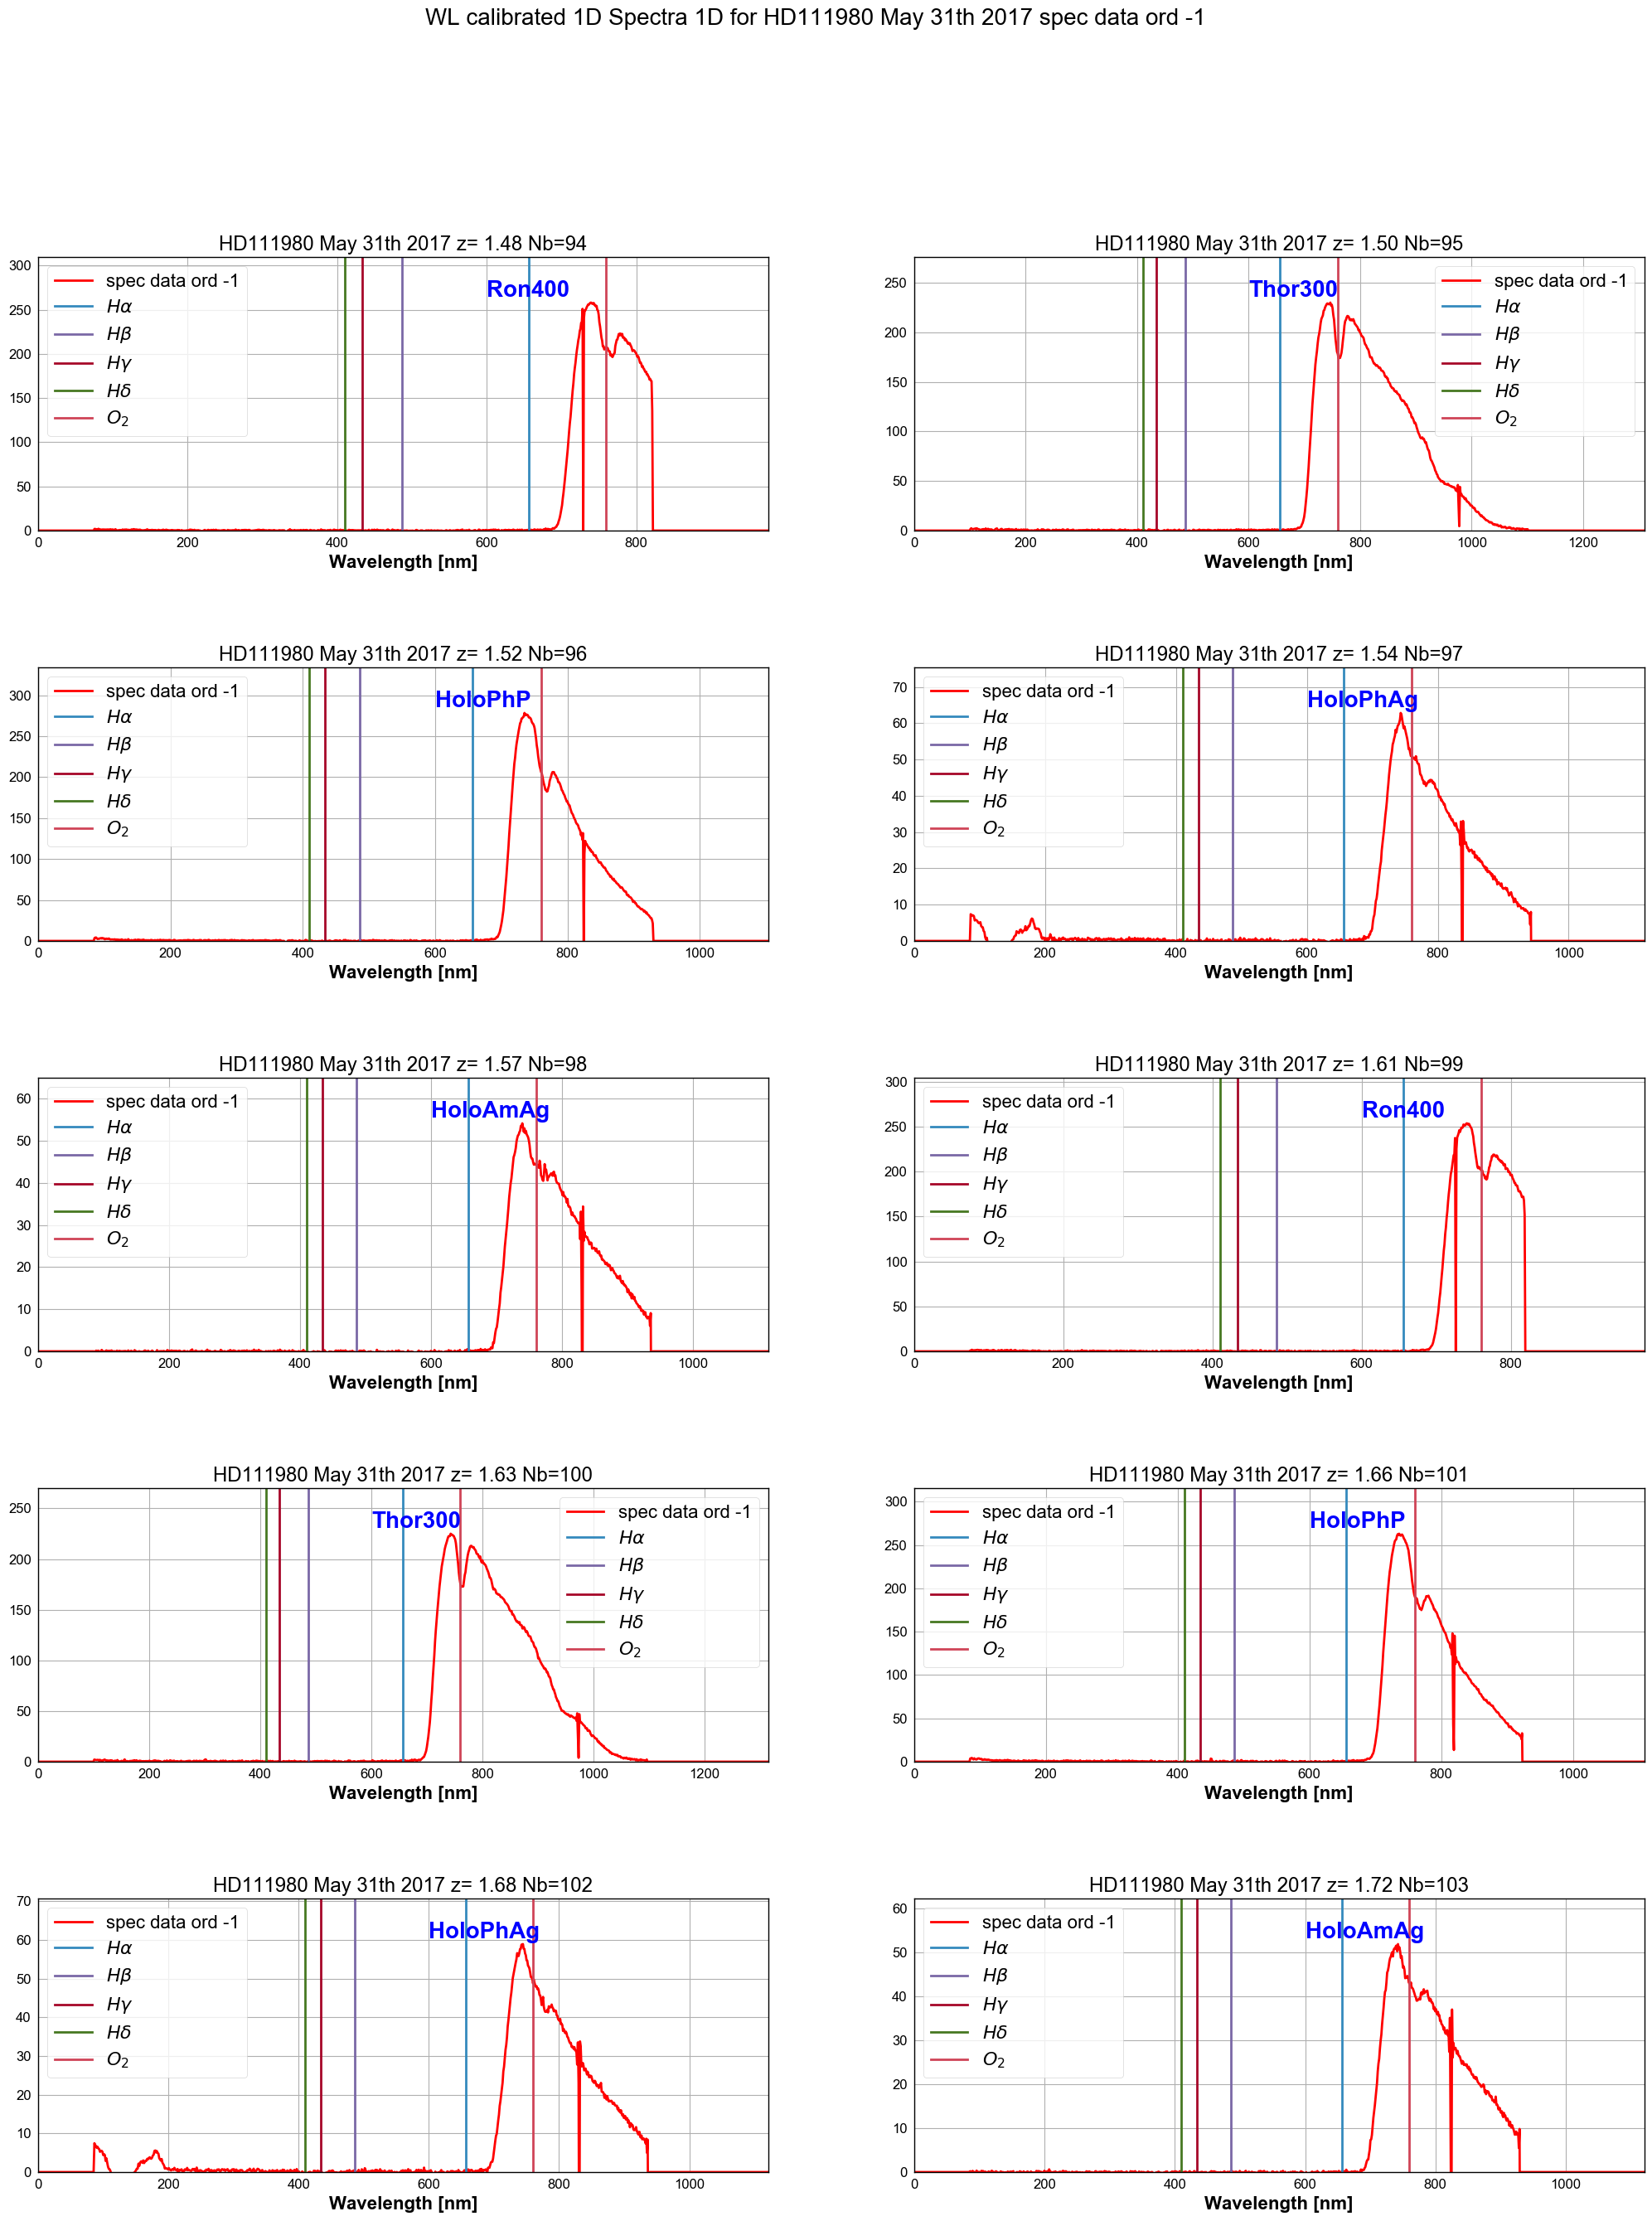

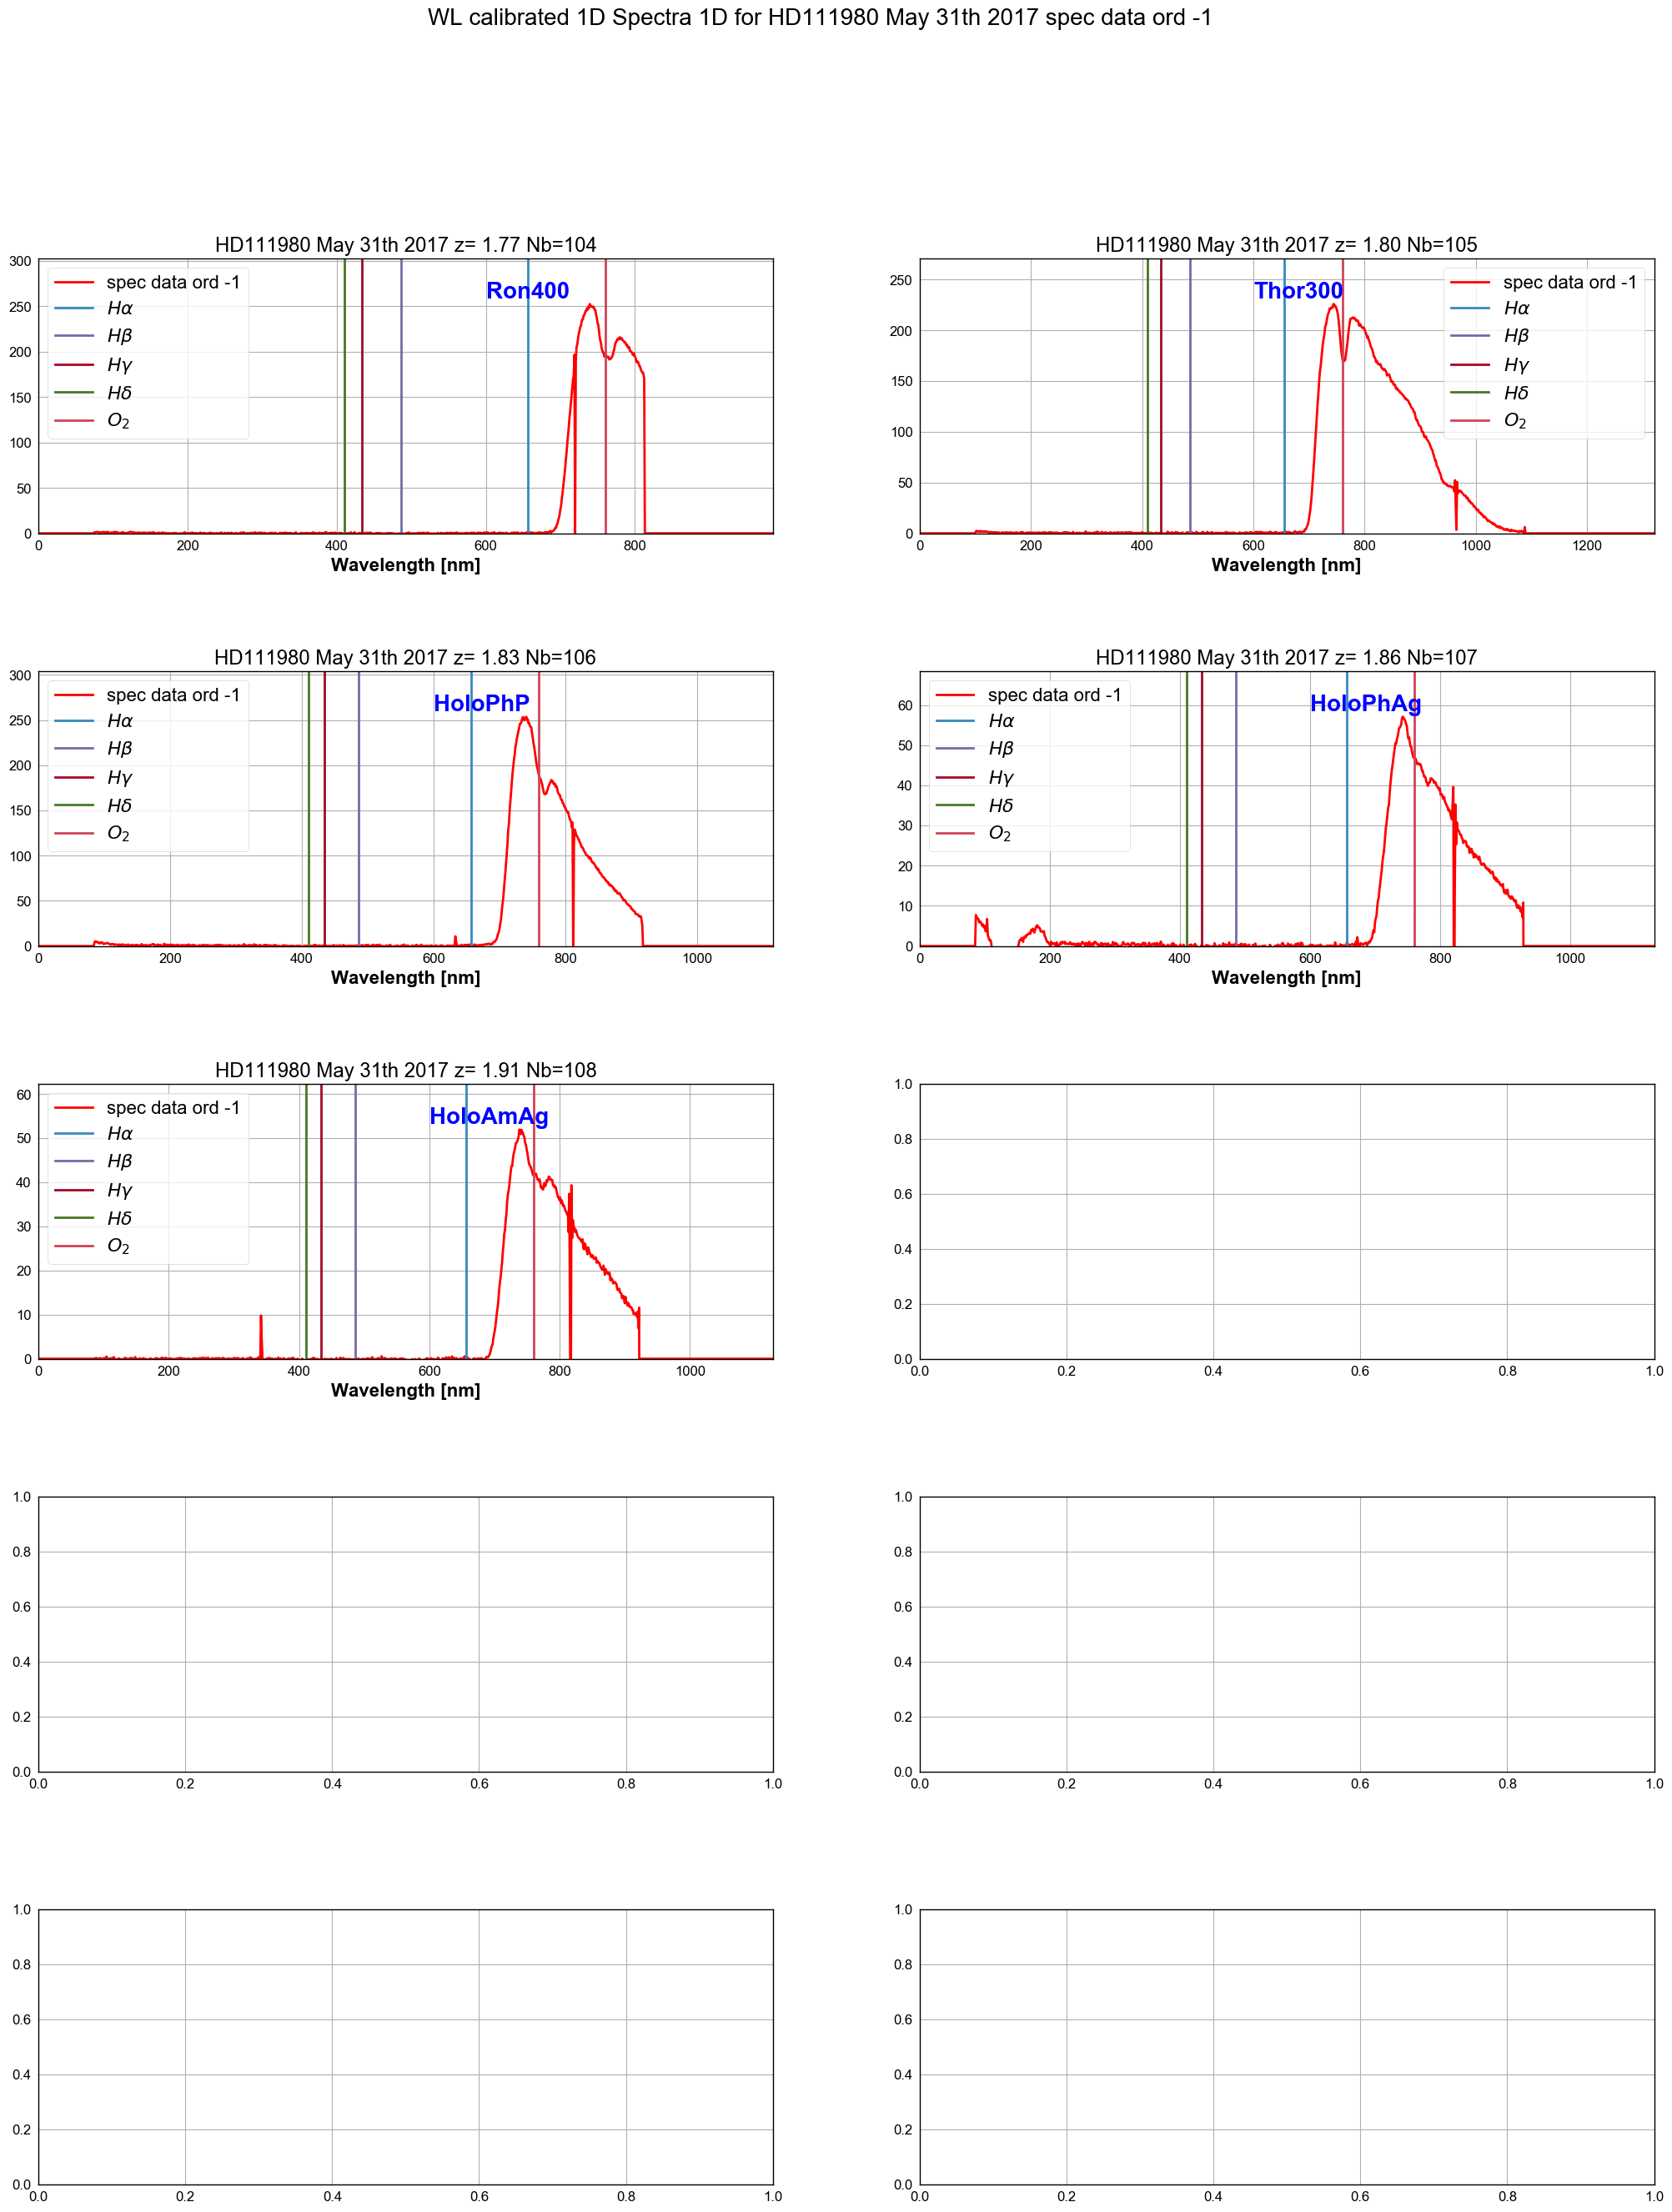

In [49]:
all_wl_left=CALSPECAbsLineIdentification(all_leftspectra,redshift,all_titles,object_name,dir_top_images,all_filt,'CALSPEC_leftspectrum.pdf','spec data ord -1')

## Compare spectra

In [68]:
def CompareSpectrumProfile(wl,spectra,all_titles,object_name,all_filt,dir_top_img,grating_name):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='CompareSpec_'+grating_name+'.pdf'
    title="Compare spectra of {} with disperser {}".format(object_name,grating_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,fontsize=30,fontweight='bold')
    
    NBSPEC=len(spectra)
    
    min_z=min(all_airmass)
    max_z=max(all_airmass)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
        if re.search(grating_name,all_filt[index]):
            axarr.plot(wl[index],spectra[index],'-')
            maxim_y_to_plot.append(spectra[index].max())
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)

    
    
    axarr.set_xlabel("wavelength (nm)",fontsize=25,fontweight='bold')
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

In [69]:
ListOfDisperserNames=['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']

In [70]:
#for dispname in ListOfDisperserNames:
#    CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,dispname)

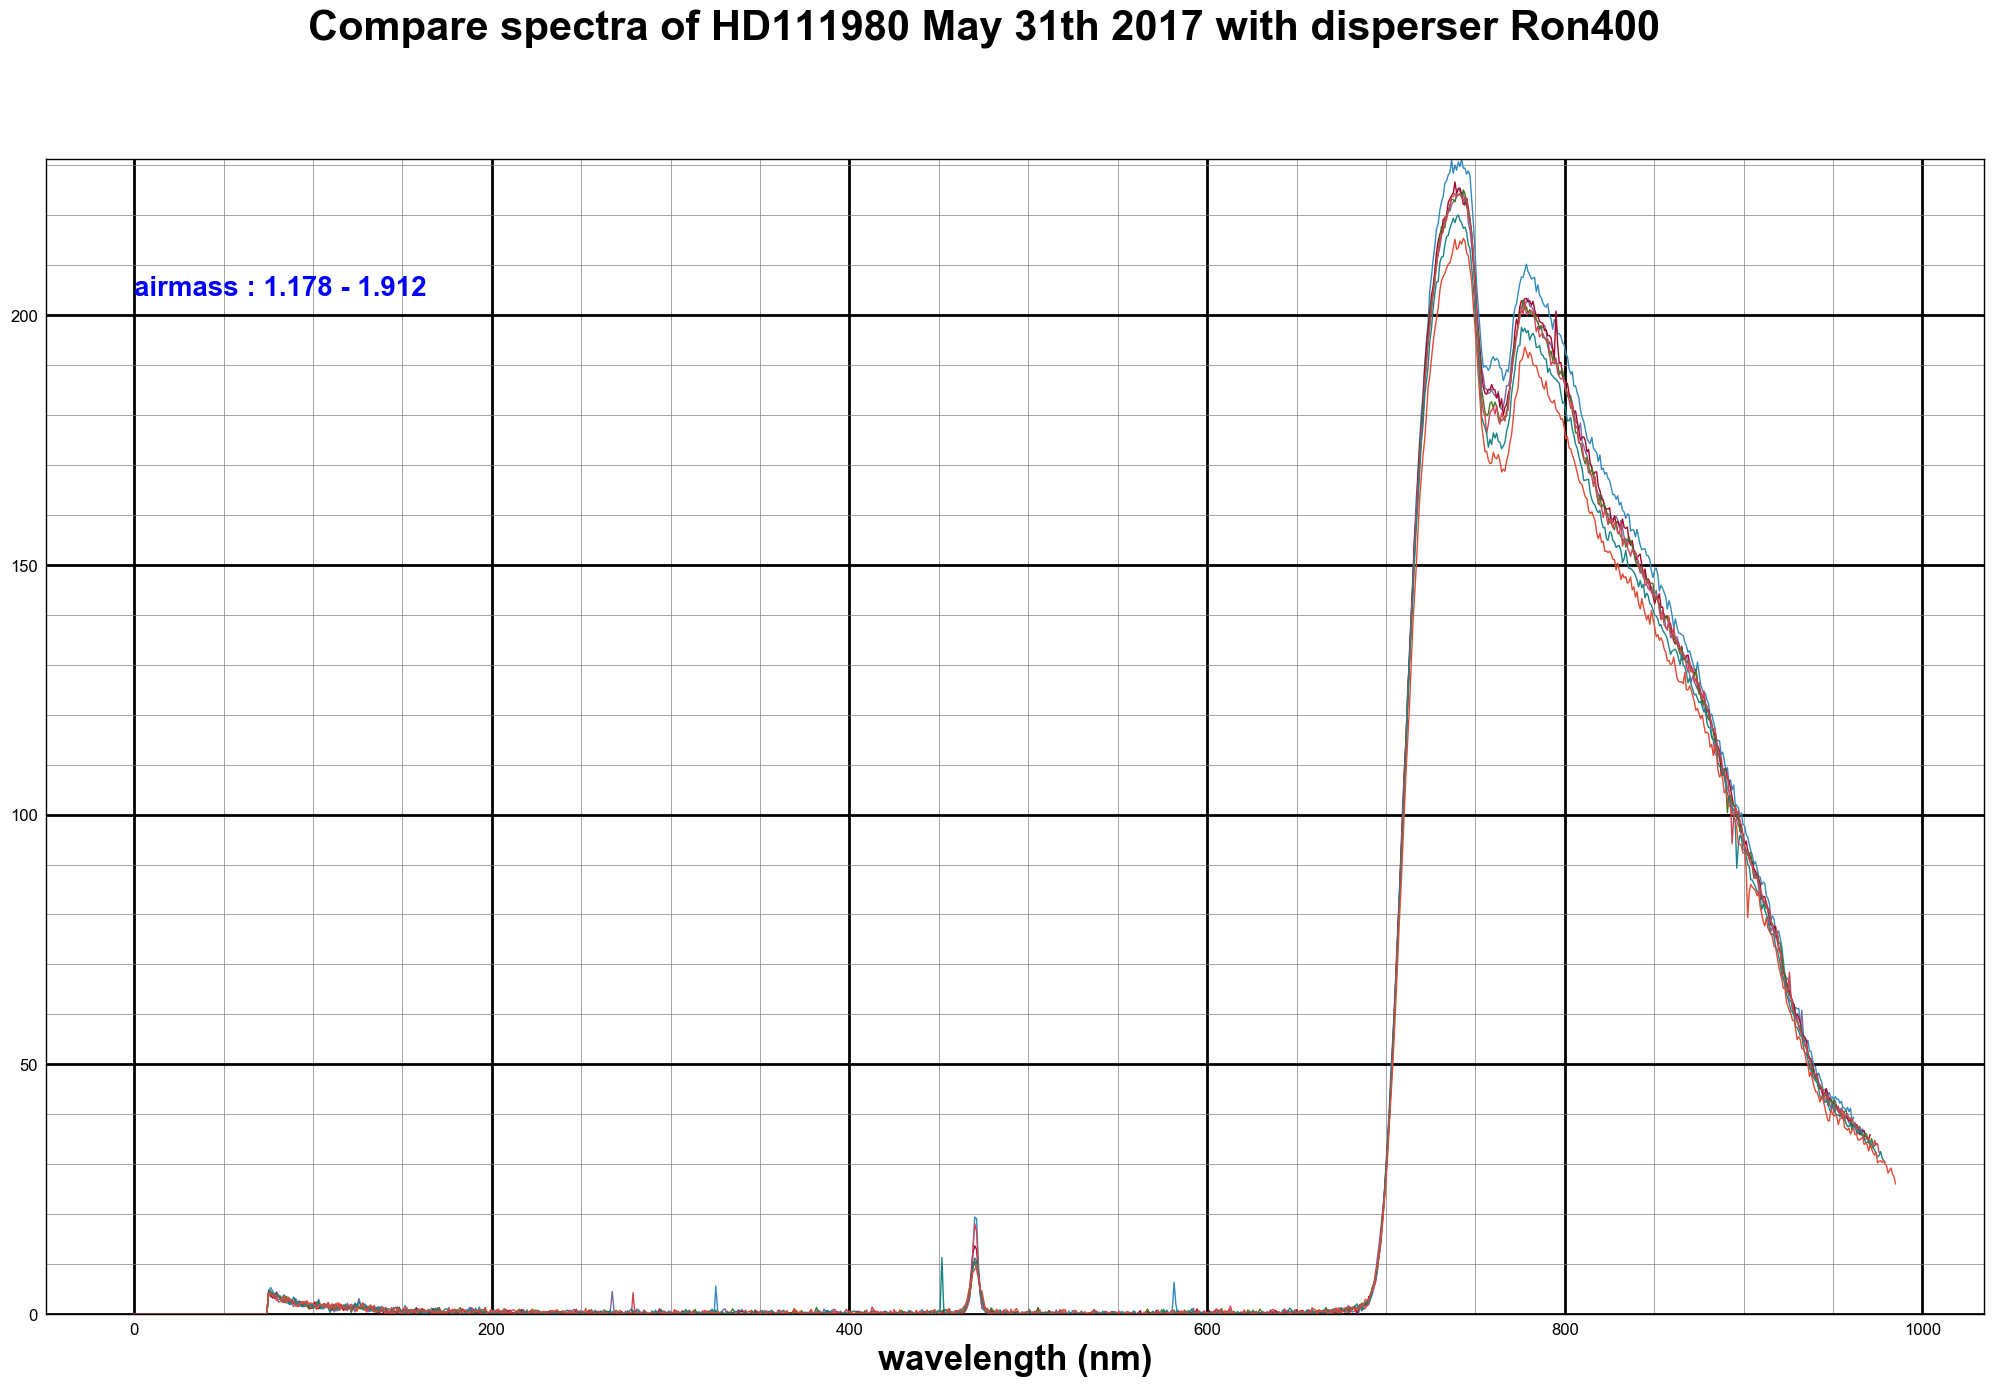

In [71]:
CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,ListOfDisperserNames[0])

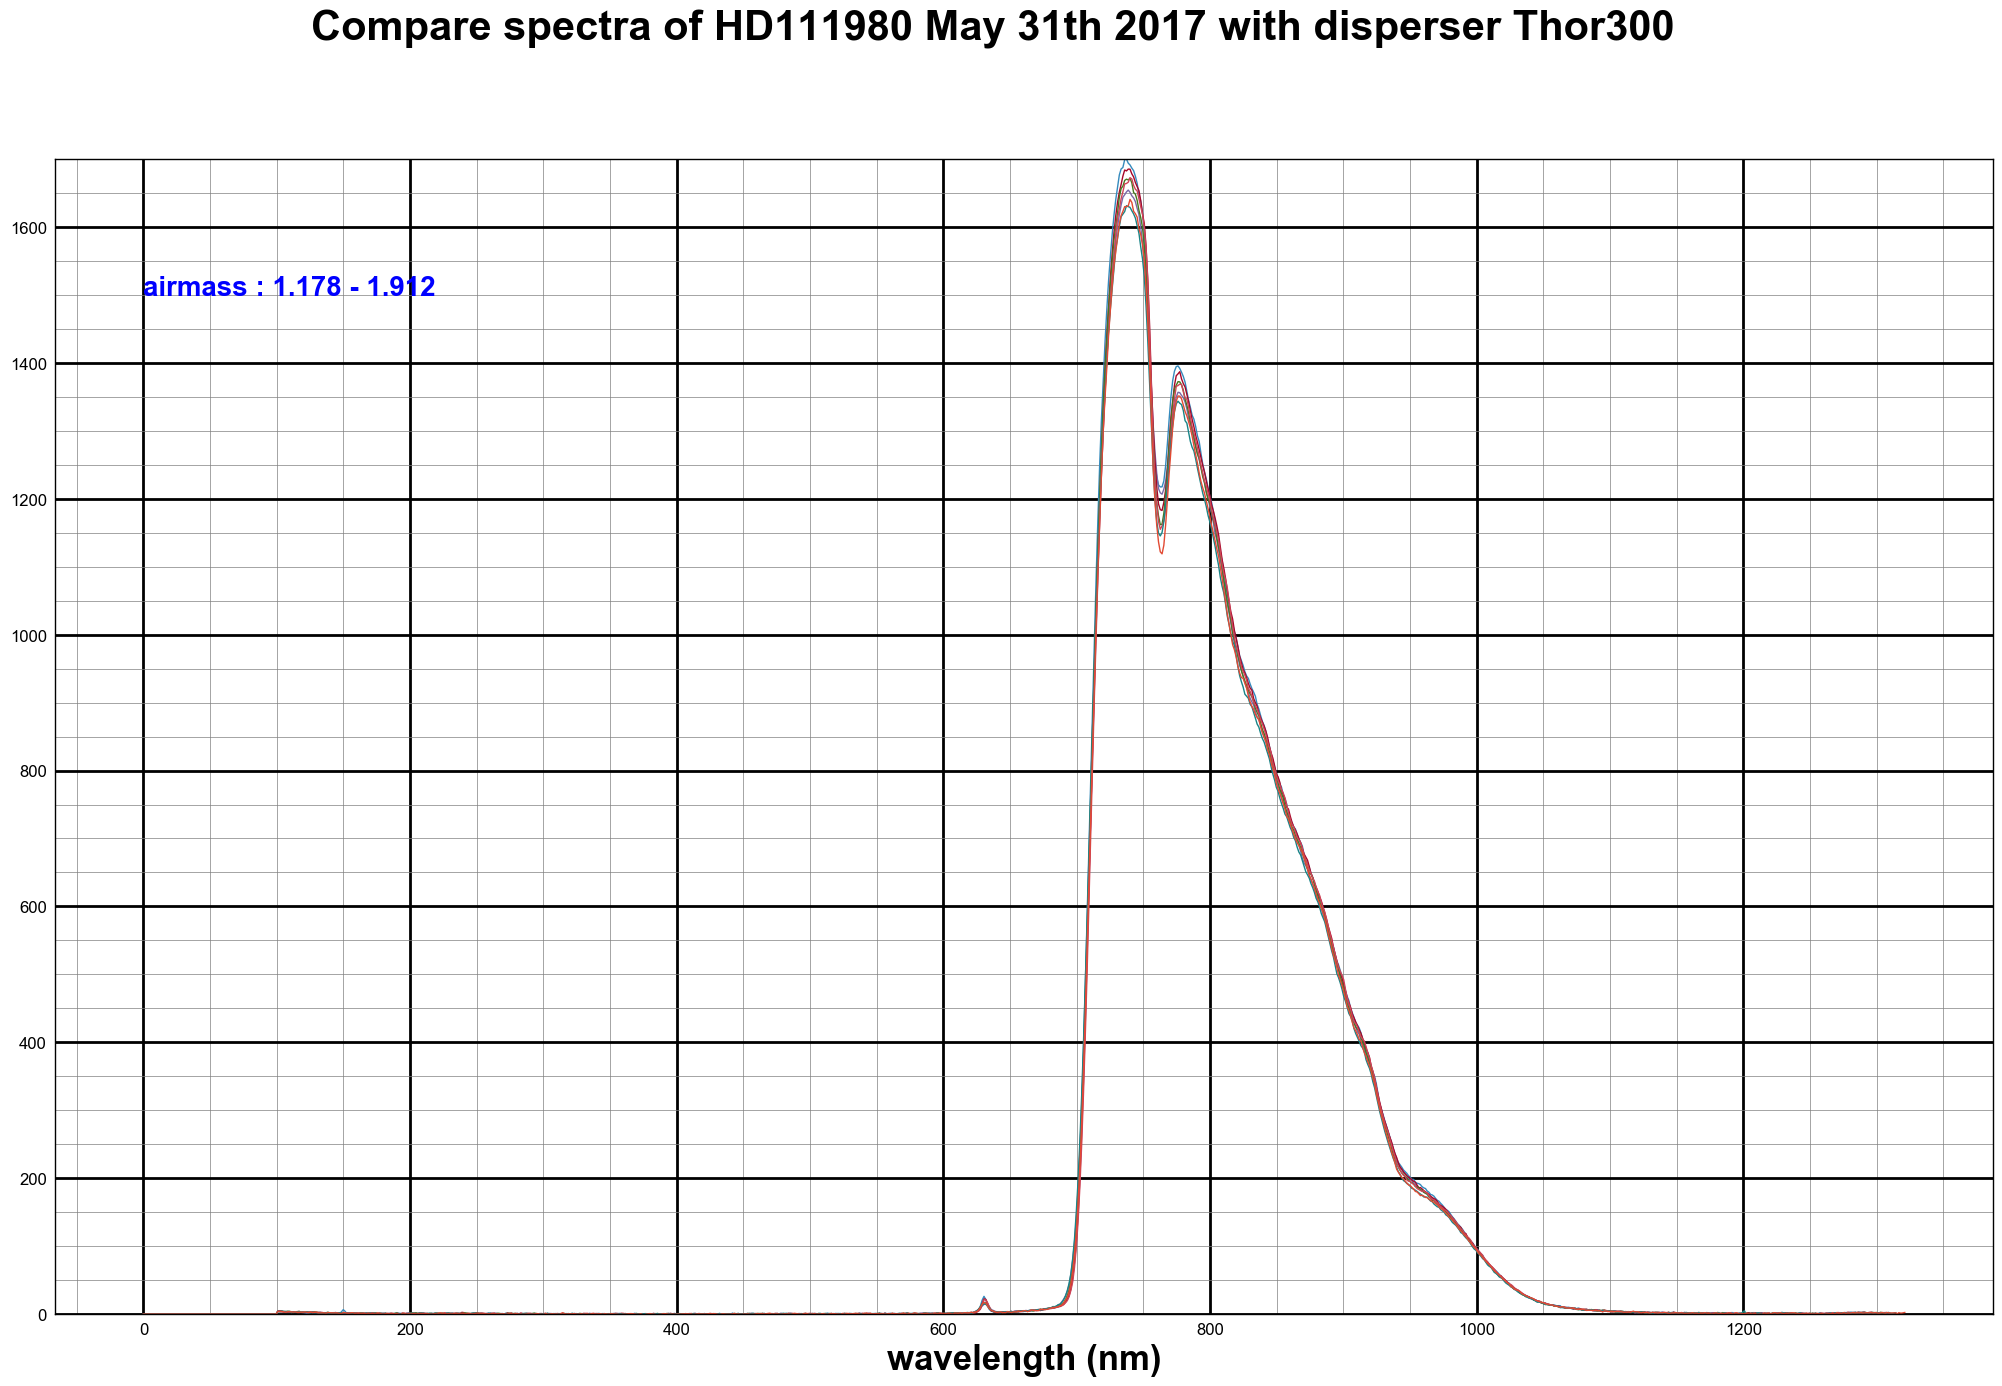

In [72]:
CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,ListOfDisperserNames[1])

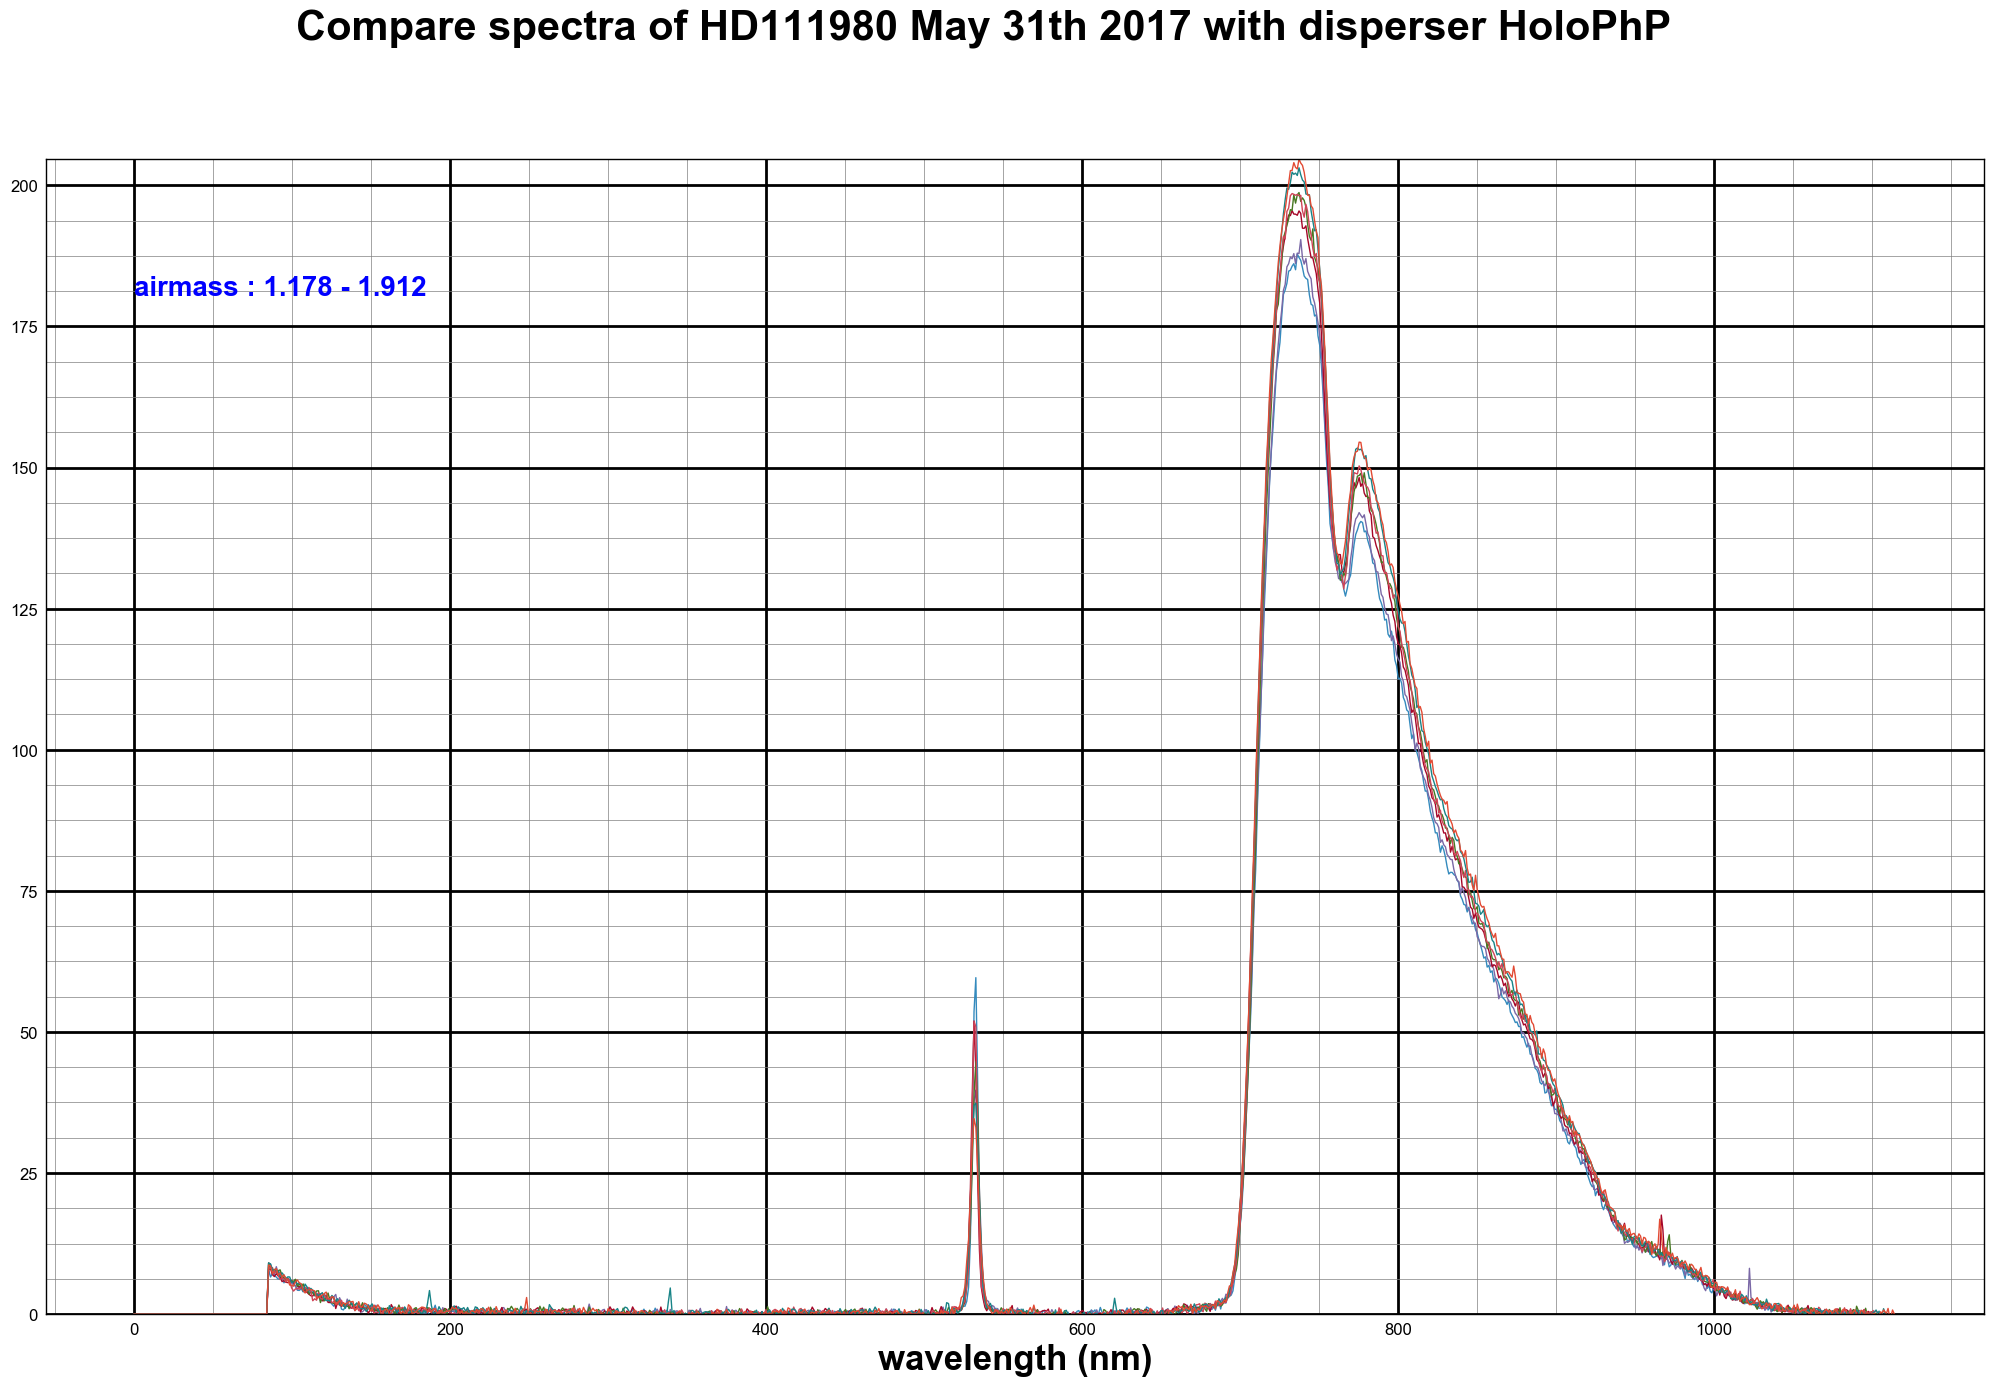

In [73]:
CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,ListOfDisperserNames[2])

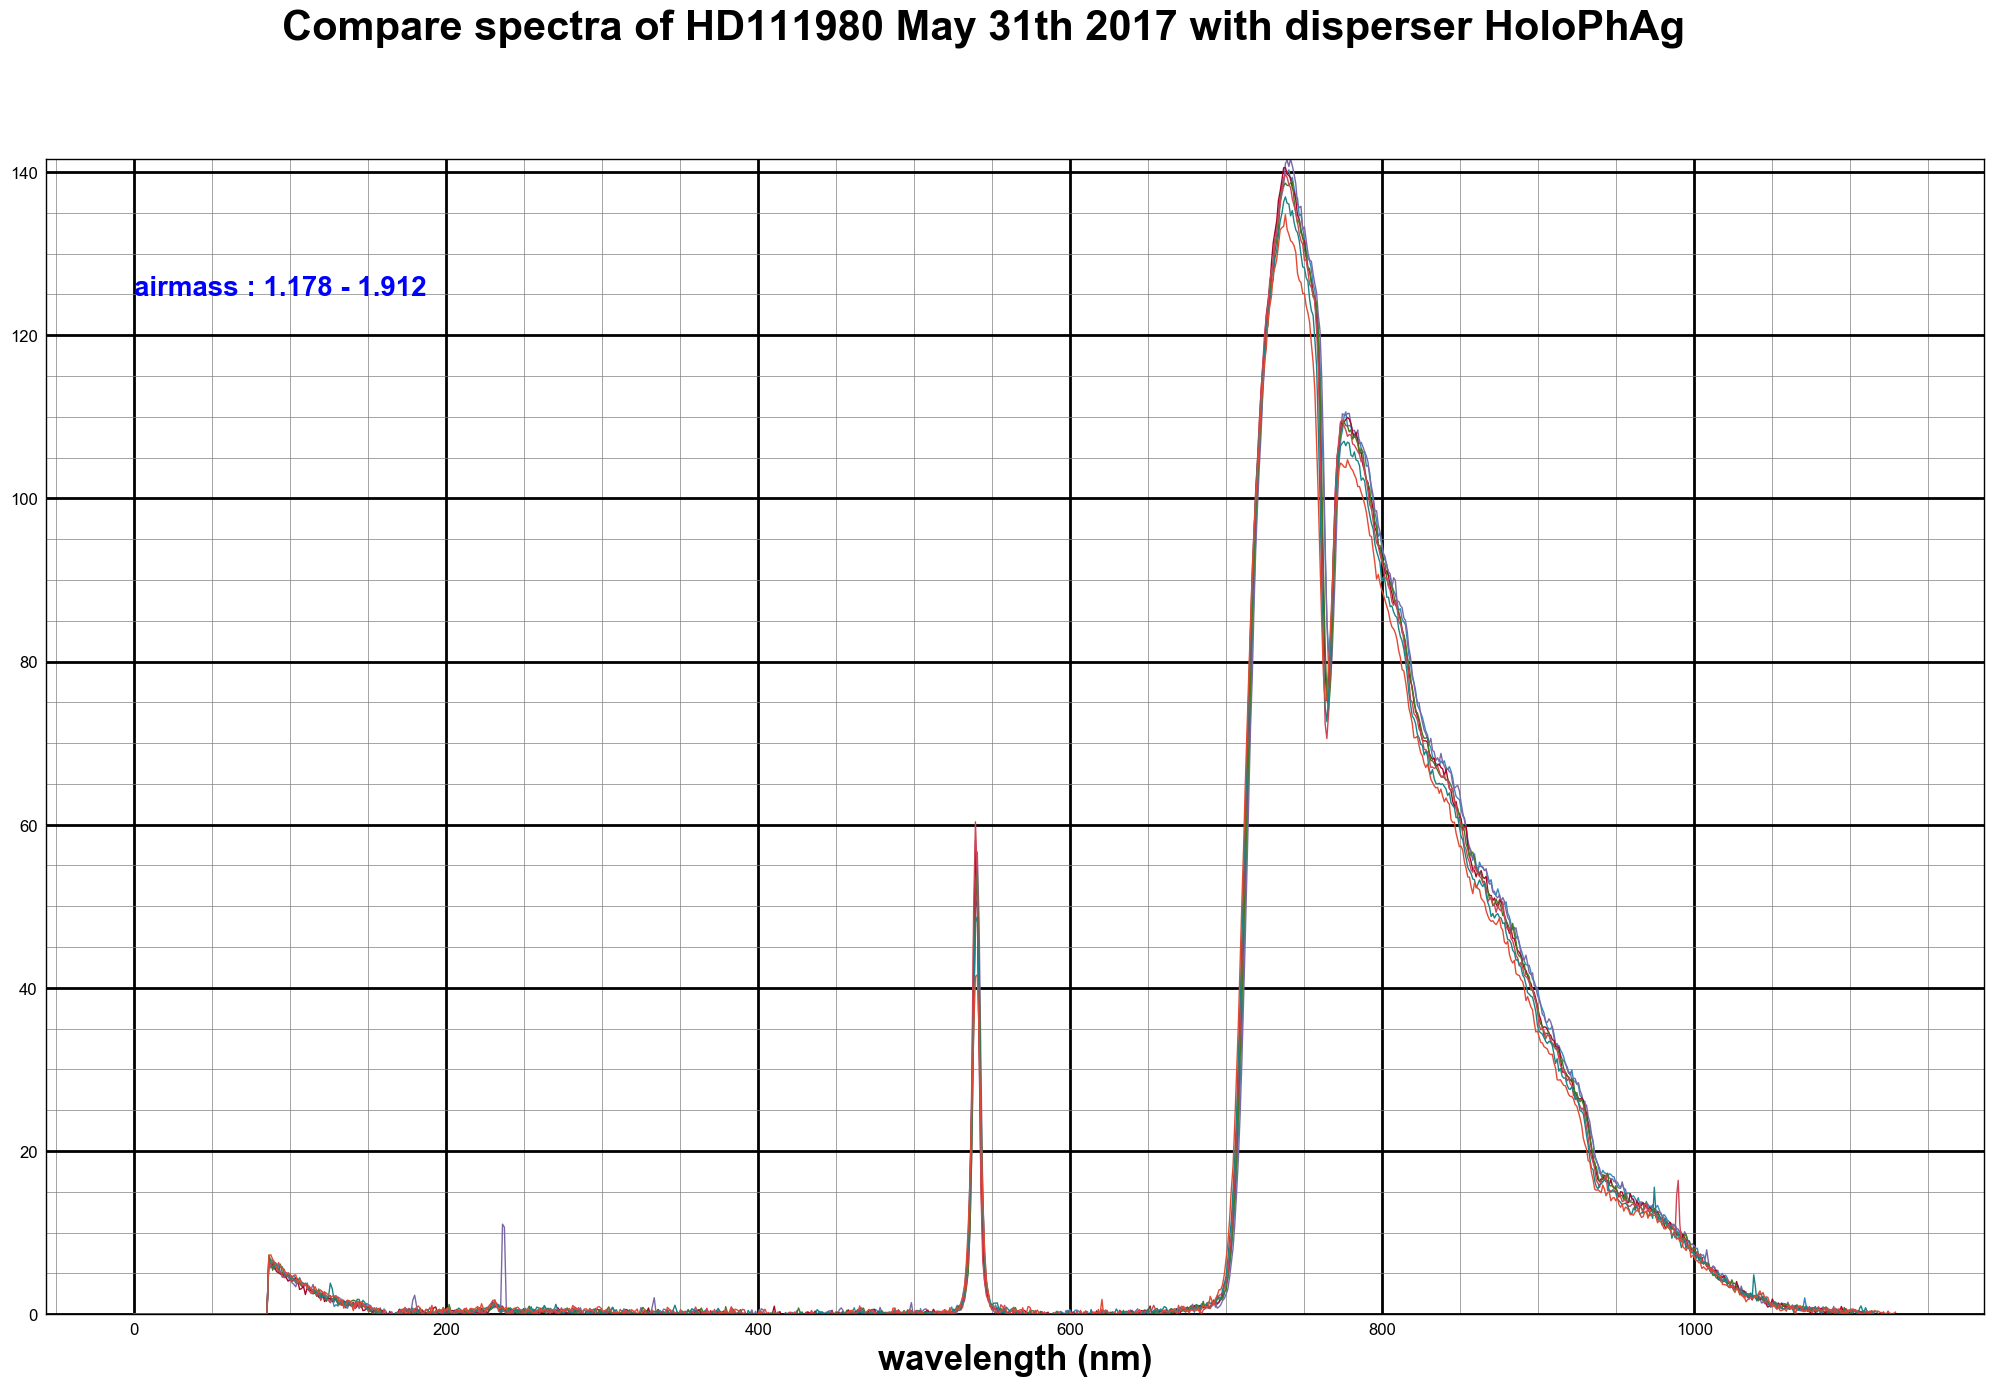

In [74]:
CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,ListOfDisperserNames[3])

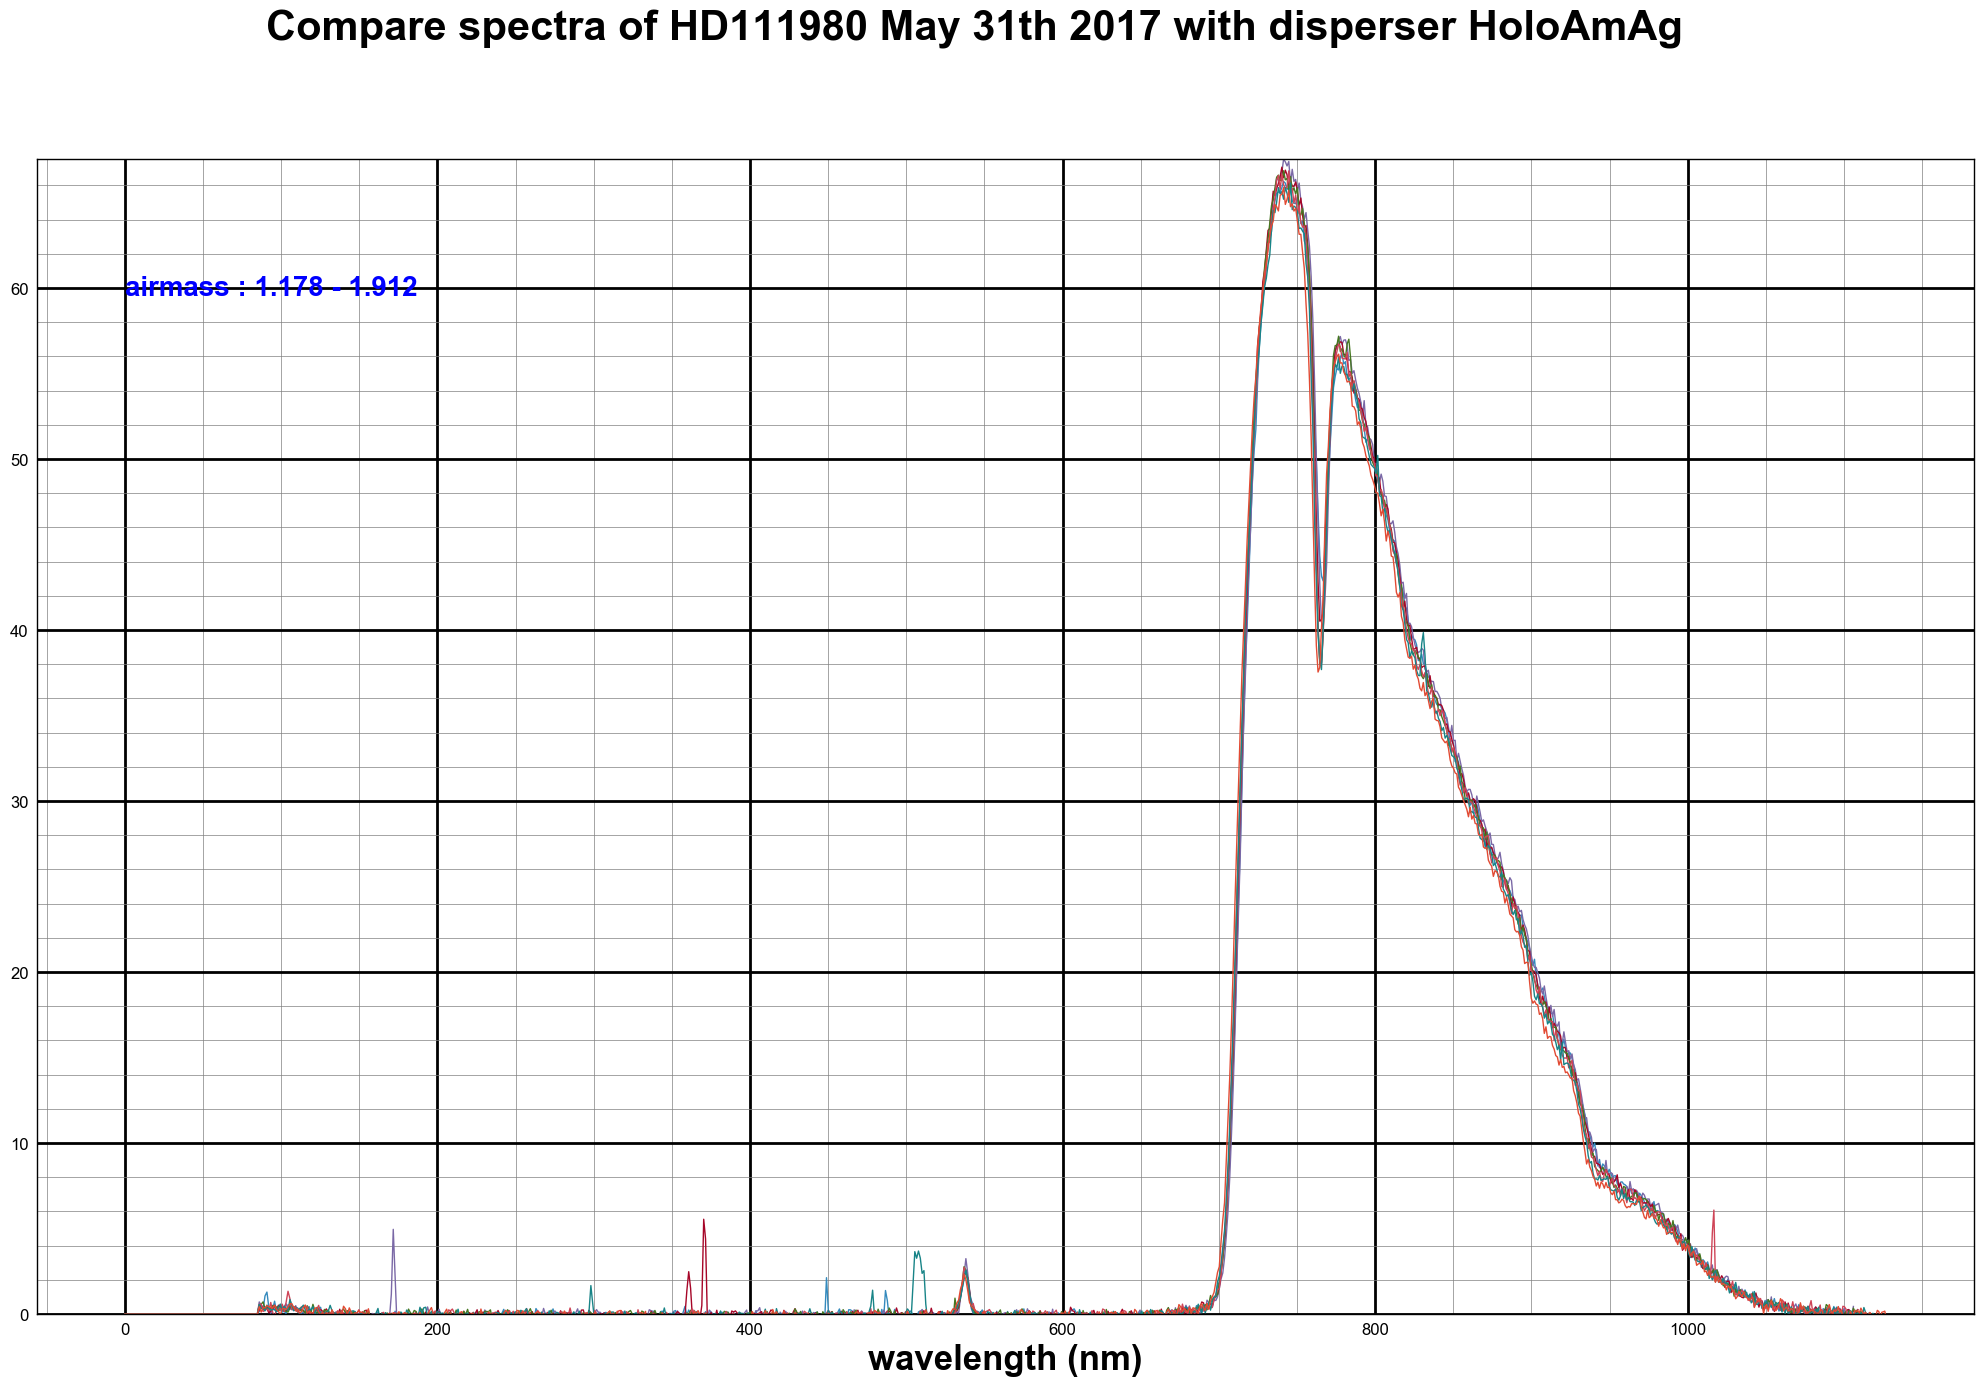

In [75]:
CompareSpectrumProfile(all_wl_right,all_rightspectra,all_titles,object_name,all_filt,dir_top_images,ListOfDisperserNames[4])

### Save outputfilename
Results of the fits for right and left spectra are saved as images

In [76]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra_(.*)',short_infilename)
    short_outfilename='calibSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [77]:
newfullfilenames[0:5]

['./spectrum_calibspec/calibSpectra_20170531_074.fits',
 './spectrum_calibspec/calibSpectra_20170531_075.fits',
 './spectrum_calibspec/calibSpectra_20170531_076.fits',
 './spectrum_calibspec/calibSpectra_20170531_077.fits',
 './spectrum_calibspec/calibSpectra_20170531_078.fits']

In [78]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='CalibLeftSpecWL',format='E',array=all_wl_left[idx[0]])
    col2=fits.Column(name='CalibLeftSpec',format='E',array=all_leftspectra[idx[0]])
    col3=fits.Column(name='CalibTotLeftSpec',format='E',array=all_totleftspectra[idx[0]])
    col4=fits.Column(name='CalibRightSpecWL',format='E',array=all_wl_right[idx[0]])
    col5=fits.Column(name='CalibRightSpec',format='E',array=all_rightspectra[idx[0]])
    col6=fits.Column(name='CalibTotRightSpec',format='E',array=all_totrightspectra[idx[0]])
    cols=fits.ColDefs([col1,col2,col3,col4,col5,col6])
    #cols=fits.ColDefs([col1,col2,col4,col5])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,overwrite=True)

In [79]:
!ls -l ./spectrum_calibspec

total 2800
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_074.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_075.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_076.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_077.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_078.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_079.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_080.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_081.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_082.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  40320 Jun 29 19:40 calibSpectra_20170531_083.fits
-rw-r--r--  1 dagoret-campagnesylvie  s